<h1>DETECÇÃO DE DADOS ANÔMALOS EM POÇOS DE PETRÓLEO UTILIZANDO APRENDIZADO DE MÁQUINA</h1>

<br>A base de dados a ser utilizada neste trabalho é chamada de 3W e foi publicada por Vargas (2019) e Vargas et al. (2019).<br>

Principais referências:

VARGAS, Ricardo Emanuel Vaz. Base de dados e benchmarks para prognóstico de anomalias em sistemas de eleveção de petróleo. Tese de doutorado, UFES, 2019

VARGAS, Ricardo Emanuel Vaz, MUNARO, Celso José, CIARELLI, Patrick Marques, MEDEIROS, André Gonçalves, AMARAL, Bruno Guberfain do, BARRIONUEVO, Daniel Centurion, ARAÚJO, Jean Carlos Dias de, RIBEIRO, Jorge Lins, MAGALHÃES, Lucas Pierezan. A realistic and public dataset with rare undesirable real events in oil wells. Journal of Petroleum Science and Engineering, v. 181, p. 106223, 2019

<br>No presente trabalho, duas análises são executadas a partir da base 3W utilizando o código que se encontra mais abaixo:

<h2>Análise 1:</h2>
Verificar se anomalias em poços de petróleo podem ser detectadas com técnicas de aprendizado de máquina.

<h2>Análise 2:</h2>
Verificar o impacto do uso de instâncias simuladas e desenhadas à mão na detecção de anomalias raras em instâncias reais.

<h1>Análise, Exploração e Visualização dos Dados</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from pathlib import Path
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
from natsort import natsorted
from datetime import datetime

In [2]:
#!pip install natsort

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_path = Path(r'C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master', 'dataset')

In [5]:
data_path0 = Path(r'C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset', '0')

In [6]:
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
columns = ['P-PDG',
           'P-TPT',
           'T-TPT',
           'P-MON-CKP',
           'T-JUS-CKP',
           'P-JUS-CKGL',
           'T-JUS-CKGL',
           'QGL',
           'class']

In [7]:
rare_threshold = 0.01

In [8]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        Aux = 9
        Aux2= str(class_path)
        try:
            Aux = int(Aux2[-1])
        except:
            pass
        if class_path.is_dir() and Aux in events_names.keys():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [9]:
real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))
simulated_instances = list(class_and_file_generator(data_path, real=False, simulated=True, drawn=False))
drawn_instances = list(class_and_file_generator(data_path, real=False, simulated=False, drawn=True))

In [10]:
instances_class = [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'REAL'} for c, p in real_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'DRAWN'} for c, p in drawn_instances]
print(instances_class[1200])

{'TYPE OF EVENT': '3 - Severe Slugging', 'SOURCE': 'SIMULATED'}


In [11]:
instances_class = [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'REAL'} for c, p in real_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'DRAWN'} for c, p in drawn_instances]
df_class = pd.DataFrame(instances_class)
df_class_count = df_class.groupby(['TYPE OF EVENT', 'SOURCE']).size().reset_index().pivot('SOURCE', 'TYPE OF EVENT', 0).fillna(0).astype(int).T
df_class_count = df_class_count.loc[natsorted(df_class_count.index.values)]
df_class_count = df_class_count[['REAL', 'SIMULATED', 'DRAWN']]
df_class_count['TOTAL'] = df_class_count.sum(axis=1)
df_class_count.loc['TOTAL'] = df_class_count.sum(axis=0)
df_class_count

SOURCE                          REAL  SIMULATED  DRAWN  TOTAL
TYPE OF EVENT                                                
0 - Normal                       597          0      0    597
1 - Abrupt Increase of BSW         5        114     10    129
2 - Spurious Closure of DHSV      22         16      0     38
3 - Severe Slugging               32         74      0    106
4 - Flow Instability             344          0      0    344
5 - Rapid Productivity Loss       12        439      0    451
6 - Quick Restriction in PCK       6        215      0    221
7 - Scaling in PCK                 4          0     10     14
8 - Hydrate in Production Line     0         81      0     81
TOTAL                           1022        939     20   1981

In [12]:
df_class_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 - Normal to TOTAL
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   REAL       10 non-null     int64
 1   SIMULATED  10 non-null     int64
 2   DRAWN      10 non-null     int64
 3   TOTAL      10 non-null     int64
dtypes: int64(4)
memory usage: 400.0+ bytes


In [13]:
rare_threshold*df_class_count['REAL'][-1]

10.22

In [14]:
th = rare_threshold*df_class_count['REAL'][-1]
df_class_count.loc[df_class_count['REAL'] < th]

SOURCE                          REAL  SIMULATED  DRAWN  TOTAL
TYPE OF EVENT                                                
1 - Abrupt Increase of BSW         5        114     10    129
6 - Quick Restriction in PCK       6        215      0    221
7 - Scaling in PCK                 4          0     10     14
8 - Hydrate in Production Line     0         81      0     81

In [15]:
th = rare_threshold*(df_class_count['REAL'][-1]+df_class_count['SIMULATED'][-1])
df_class_count.loc[df_class_count['REAL']+df_class_count['SIMULATED'] < th]

SOURCE              REAL  SIMULATED  DRAWN  TOTAL
TYPE OF EVENT                                    
7 - Scaling in PCK     4          0     10     14

In [16]:
def load_instance(instances):
    class_code, instance_path = instances
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        assert (df.columns == columns).all(), "invalid columns in the file {}: {}".format(str(instance_path), str(df.columns.tolist()))
        df['class_code'] = class_code
        df['well'] = well
        df['instance_id'] = instance_id
        df = df[['class_code', 'well', 'instance_id'] + columns]
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [17]:
def load_instances(instances):
    pool = ThreadPool()
    all_df = []
    try:
        for df in pool.imap_unordered(load_instance, instances):
            all_df.append(df)
    finally:
        pool.terminate()
    df_all = pd.concat(all_df)
    del all_df
    return df_all

In [18]:
df_real = load_instances(real_instances)
df_time = df_real.reset_index().groupby(['well', 'instance_id', 'class_code'])['timestamp'].agg(['min', 'max'])

In [19]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13952911 entries, 2017-02-01 02:02:07 to 2018-06-19 22:11:43
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   class_code   int64  
 1   well         object 
 2   instance_id  object 
 3   P-PDG        float64
 4   P-TPT        float64
 5   T-TPT        float64
 6   P-MON-CKP    float64
 7   T-JUS-CKP    float64
 8   P-JUS-CKGL   float64
 9   T-JUS-CKGL   float64
 10  QGL          float64
 11  class        float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.4+ GB


In [20]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1022 entries, ('WELL-00001', '20140124213136', 1) to ('WELL-00018', '20180611040207', 7)
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   min     1022 non-null   datetime64[ns]
 1   max     1022 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 28.3+ KB


In [21]:
df_simulated = load_instances(simulated_instances)

In [22]:
df_simulated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33902803 entries, 2018-10-06 03:57:02 to 2018-05-19 19:01:09
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   class_code   int64  
 1   well         object 
 2   instance_id  object 
 3   P-PDG        float64
 4   P-TPT        float64
 5   T-TPT        float64
 6   P-MON-CKP    float64
 7   T-JUS-CKP    float64
 8   P-JUS-CKGL   float64
 9   T-JUS-CKGL   float64
 10  QGL          float64
 11  class        int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 3.3+ GB


In [23]:
df_drawn = load_instances(drawn_instances)

In [24]:
df_drawn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2966410 entries, 2018-09-05 20:44:36 to 2018-08-24 11:25:44
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   class_code   int64  
 1   well         object 
 2   instance_id  object 
 3   P-PDG        float64
 4   P-TPT        float64
 5   T-TPT        float64
 6   P-MON-CKP    float64
 7   T-JUS-CKP    float64
 8   P-JUS-CKGL   float64
 9   T-JUS-CKGL   float64
 10  QGL          float64
 11  class        int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 294.2+ MB


In [25]:
df_all = load_instances(real_instances+simulated_instances+drawn_instances)

In [26]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50822124 entries, 2017-02-01 07:01:14 to 2018-08-24 11:25:44
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   class_code   int64  
 1   well         object 
 2   instance_id  object 
 3   P-PDG        float64
 4   P-TPT        float64
 5   T-TPT        float64
 6   P-MON-CKP    float64
 7   T-JUS-CKP    float64
 8   P-JUS-CKGL   float64
 9   T-JUS-CKGL   float64
 10  QGL          float64
 11  class        float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.9+ GB


In [27]:
well_times = defaultdict(list)
well_classes = defaultdict(list)
for (well, instance_id, class_code), (tmin, tmax) in df_time.iterrows():
    well_times[well].append((tmin.date(), (tmax.date() - tmin.date())))
    well_classes[well].append(int(class_code))

In [28]:
wells = df_real['well'].unique()
well_code = {w:i for i, w in enumerate(sorted(wells))}

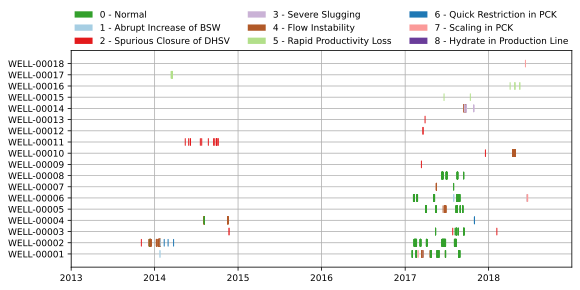

In [29]:
cmap = plt.get_cmap('Paired')
my_colors = [cmap(i) for i in [3, 0, 5, 8, 11, 2, 1, 4, 9, 7, 6, 10]]
my_cmap = mcolors.ListedColormap(my_colors, name='my_cmap')
plt.register_cmap(name='my_cmap', cmap=my_cmap)
cmap = plt.get_cmap('my_cmap')
height = 5
border = 2
first_year = np.min(df_time['min']).year
last_year = np.max(df_time['max']).year
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9
fig, ax = plt.subplots(figsize=(9, 4))
yticks = []
yticks_labels = []
for well in well_times.keys():
    times = well_times[well]
    class_names = well_classes[well]    
    class_colors = list(map(cmap, class_names))
    well_id = well_code[well]
    yticks.append(well_id * height + height/2 - border/2)
    yticks_labels.append(well)
    ax.broken_barh(times, (well_id * height, height - border), facecolors=class_colors, edgecolors=class_colors)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(datetime(first_year, 1, 1).date(), datetime(last_year, 12, 31).date())
legend_colors = [Patch(facecolor=cmap(i), label=str(i) + ' - ' + events_name) for i, events_name in events_names.items()]
ax.legend(frameon=False, handles=legend_colors, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3);
#fig.savefig('figure.png', dpi=500, bbox_inches='tight')

In [30]:
def calc_stats_instance(instances):
    _, instance_path = instances
    n_vars_missing = 0
    n_vars_frozen = 0
    try:    
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        vars = df.columns[:-1]
        n_vars = len(vars)
        for var in vars:
            if df[var].isnull().all(): 
                n_vars_missing += 1
            u_values = df[var].unique()
            if len(u_values) == 1 and not np.isnan(u_values):
                n_vars_frozen += 1
        n_obs = len(df)
        n_obs_unlabeled = df['class'].isnull().sum()
        return pd.DataFrame({'n_vars':[n_vars], 
                             'n_vars_missing':[n_vars_missing],
                             'n_vars_frozen':[n_vars_frozen],
                             'n_obs':[n_obs],
                             'n_obs_unlabeled':[n_obs_unlabeled]
                            })
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [31]:
def calc_stats_instances(instances):
    pool = ThreadPool()
    all_stats = []
    try:
        for stats in pool.imap_unordered(calc_stats_instance, instances):
            all_stats.append(stats)
    finally:
        pool.terminate()
    df_all_stats = pd.concat(all_stats)
    del all_stats
    return df_all_stats.sum()

In [32]:
def calc_stats_instance_test(instances):
    _, instance_path = instances
    n_vars_missing = 0
    n_vars_frozen = 0
    try:    
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        vars = df.columns[:-1]
        n_vars = len(vars)
        for var in vars:
            print(var)
            if df[var].isnull().all(): 
                n_vars_missing += 1
            u_values = df[var].unique()
            if len(u_values) == 1 and not np.isnan(u_values):
                print(u_values)
                n_vars_frozen += 1
        n_obs = len(df)
        n_obs_unlabeled = df['class'].isnull().sum()
        return pd.DataFrame({'n_vars':[n_vars], 
                             'n_vars_missing':[n_vars_missing],
                             'n_vars_frozen':[n_vars_frozen],
                             'n_obs':[n_obs],
                             'n_obs_unlabeled':[n_obs_unlabeled]
                            })
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

def calc_stats_instances_test(instances):
    pool = ThreadPool()
    all_stats = []
    try:
        for stats in pool.imap_unordered(calc_stats_instance_test, instances):
            all_stats.append(stats)
    finally:
        pool.terminate()
    df_all_stats = pd.concat(all_stats)
    del all_stats
    return df_all_stats.sum()


print(real_instances[0:1])
global_stats = calc_stats_instances_test(real_instances[0:1])
print('number of variables: {}'.format(global_stats['n_vars']))
print('number of observations: {}'.format(global_stats['n_obs']))
print('missing variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_missing'], global_stats['n_vars'], 100*global_stats['n_vars_missing']/global_stats['n_vars']))
print('frozen variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_frozen'], global_stats['n_vars'], 100*global_stats['n_vars_frozen']/global_stats['n_vars']))
print('unlabeled observations: {} of {} ({:.2f}%)'.format(global_stats['n_obs_unlabeled'], global_stats['n_obs'], 100*global_stats['n_obs_unlabeled']/global_stats['n_obs']))

[(0, WindowsPath('C:/Users/leonardo.pinheiro/Downloads/PUC-Minas/16 - Projeto Integrado/3W-master/dataset/0/WELL-00001_20170201020207.csv'))]
P-PDG
[0.]
P-TPT
T-TPT
P-MON-CKP
T-JUS-CKP
P-JUS-CKGL
T-JUS-CKGL
QGL
[0.]
number of variables: 8
number of observations: 17874
missing variables: 1 of 8 (12.50%)
frozen variables: 2 of 8 (25.00%)
unlabeled observations: 0 of 17874 (0.00%)


In [33]:
global_stats = calc_stats_instances(real_instances+simulated_instances+drawn_instances)

In [34]:
print('Number of variables: {}'.format(global_stats['n_vars']))
print('Number of observations: {}'.format(global_stats['n_obs']))
print('Missing variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_missing'], global_stats['n_vars'], 100*global_stats['n_vars_missing']/global_stats['n_vars']))
print('Frozen variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_frozen'], global_stats['n_vars'], 100*global_stats['n_vars_frozen']/global_stats['n_vars']))
print('Unlabeled observations: {} of {} ({:.2f}%)'.format(global_stats['n_obs_unlabeled'], global_stats['n_obs'], 100*global_stats['n_obs_unlabeled']/global_stats['n_obs']))

Number of variables: 15848
Number of observations: 50822124
Missing variables: 4941 of 15848 (31.18%)
Frozen variables: 1532 of 15848 (9.67%)
Unlabeled observations: 4761 of 50822124 (0.01%)


In [35]:
global_stats

n_vars                15848
n_vars_missing         4941
n_vars_frozen          1532
n_obs              50822124
n_obs_unlabeled        4761
dtype: int64

In [36]:
import sys
import os

sys.path.append(os.path.join('..','..'))
import toolkit as tk

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [37]:
tk.count_properties_instance(real_instances[100])

{'n_vars_missing': 1,
 'n_vars_frozen': 4,
 'n_vars': 8,
 'n_obs': 7165,
 'n_obs_unlabeled': 0}

In [38]:
tk.count_properties_instances(real_instances)

{'n_vars_missing': 1849,
 'n_vars_frozen': 1532,
 'n_vars': 8176,
 'n_obs': 13952911,
 'n_obs_unlabeled': 4761}

In [39]:
tk.count_properties_instances(simulated_instances)

{'n_vars_missing': 3032,
 'n_vars_frozen': 0,
 'n_vars': 7512,
 'n_obs': 33902803,
 'n_obs_unlabeled': 0}

In [40]:
tk.count_properties_instances(drawn_instances)

{'n_vars_missing': 60,
 'n_vars_frozen': 0,
 'n_vars': 160,
 'n_obs': 2966410,
 'n_obs_unlabeled': 0}

In [41]:
tk.count_properties_instances(real_instances+simulated_instances+drawn_instances)

{'n_vars_missing': 4941,
 'n_vars_frozen': 1532,
 'n_vars': 15848,
 'n_obs': 50822124,
 'n_obs_unlabeled': 4761}

In [42]:
calc_stats_instances(
    real_instances)

n_vars                 8176
n_vars_missing         1849
n_vars_frozen          1532
n_obs              13952911
n_obs_unlabeled        4761
dtype: int64

In [43]:
calc_stats_instances(
    simulated_instances)

n_vars                 7512
n_vars_missing         3032
n_vars_frozen             0
n_obs              33902803
n_obs_unlabeled           0
dtype: int64

In [44]:
calc_stats_instances(
    drawn_instances)

n_vars                 160
n_vars_missing          60
n_vars_frozen            0
n_obs              2966410
n_obs_unlabeled          0
dtype: int64

In [45]:
calc_stats_instances(
    real_instances+
    simulated_instances+
    drawn_instances)

n_vars                15848
n_vars_missing         4941
n_vars_frozen          1532
n_obs              50822124
n_obs_unlabeled        4761
dtype: int64

In [46]:
real_instances, simulated_instances, drawn_instances = tk.get_all_labels_and_files()
tk.load_instance(real_instances[100])

label        well              id  P-PDG       P-TPT  \
timestamp                                                                   
2013-12-14 18:00:36      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 18:00:37      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 18:00:38      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 18:00:39      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 18:00:40      0  WELL-00002  20131214180036    0.0  16538200.0   
...                    ...         ...             ...    ...         ...   
2013-12-14 19:59:56      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 19:59:57      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 19:59:58      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 19:59:59      0  WELL-00002  20131214180036    0.0  16538200.0   
2013-12-14 20:00:00      0  WELL-00002  20131214180036    0.0  16538200.0   

                        T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  \
timestamp                                                                     
2013-12-14 18:00:36  118.1093  7293205.0   173.0961   3831379.0         NaN   
2013-12-14 18:00:37  118.1094  7296677.0   173.0961   3831374.0         NaN   
2013-12-14 18:00:38  118.1096  7300150.0   173.0961   3831369.0         NaN   
2013-12-14 18:00:39  118.1097  7299884.0   173.0961   3831364.0         NaN   
2013-12-14 18:00:40  118.1099  7299619.0   173.0961   3831359.0         NaN   
...                       ...        ...        ...         ...         ...   
2013-12-14 19:59:56  118.1080  7200880.0   173.0961   3951584.0         NaN   
2013-12-14 19:59:57  118.1083  7199120.0   173.0961   3951621.0         NaN   
2013-12-14 19:59:58  118.1086  7197360.0   173.0961   3951658.0         NaN   
2013-12-14 19:59:59  118.1089  7195600.0   173.0961   3951694.0         NaN   
2013-12-14 20:00:00  118.1092  7193840.0   173.0961   3951731.0         NaN   

                     QGL  class  
timestamp                        
2013-12-14 18:00:36  0.0      0  
2013-12-14 18:00:37  0.0      0  
2013-12-14 18:00:38  0.0      0  
2013-12-14 18:00:39  0.0      0  
2013-12-14 18:00:40  0.0      0  
...                  ...    ...  
2013-12-14 19:59:56  0.0      0  
2013-12-14 19:59:57  0.0      0  
2013-12-14 19:59:58  0.0      0  
2013-12-14 19:59:59  0.0      0  
2013-12-14 20:00:00  0.0      0  

[7165 rows x 12 columns]

In [47]:
real_obs = 0
for i in range(len(real_instances)):
    real_obs = real_obs + len(tk.load_instance(real_instances[i]))
print('Real observations =',real_obs)
sim_obs = 0
for i in range(len(simulated_instances)):
    sim_obs = sim_obs + len(tk.load_instance(simulated_instances[i]))
print('Simulated observations =',sim_obs)
drawn_obs = 0
for i in range(len(drawn_instances)):
    drawn_obs = drawn_obs + len(tk.load_instance(drawn_instances[i]))
print('Drawn observations =',drawn_obs)
print('Total number of observations =',real_obs+sim_obs+drawn_obs)

Real observations = 13952911
Simulated observations = 33902803
Drawn observations = 2966410
Total number of observations = 50822124


In [48]:
dmin = []
dmax = []
for i in range(0,len(real_instances)):
    p = tk.load_instance(real_instances[i])
    dmin.append(np.min(p.index.year))
    dmax.append(np.max(p.index.year))
print(np.min(dmin))
print(np.max(dmax))

2013
2018


In [49]:
dmin = []
dmax = []
for i in range(0,len(simulated_instances)):
    p = tk.load_instance(simulated_instances[i])
    dmin.append(np.min(p.index.year))
    dmax.append(np.max(p.index.year))
print(np.min(dmin))
print(np.max(dmax))

2018
2018


In [50]:
dmin = []
dmax = []
for i in range(0,len(drawn_instances)):
    p = tk.load_instance(drawn_instances[i])
    dmin.append(np.min(p.index.year))
    dmax.append(np.max(p.index.year))
print(np.min(dmin))
print(np.max(dmax))

2018
2018


In [51]:
pdf_real = tk.load_instance(real_instances[596])
pdf_real.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17633 entries, 2017-09-14 12:02:46 to 2017-09-14 16:56:38
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       17633 non-null  int64  
 1   well        17633 non-null  object 
 2   id          17633 non-null  object 
 3   P-PDG       17633 non-null  float64
 4   P-TPT       17633 non-null  float64
 5   T-TPT       17633 non-null  float64
 6   P-MON-CKP   0 non-null      float64
 7   T-JUS-CKP   0 non-null      float64
 8   P-JUS-CKGL  0 non-null      float64
 9   T-JUS-CKGL  0 non-null      float64
 10  QGL         0 non-null      float64
 11  class       17633 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 1.7+ MB


In [52]:
tk.load_instance(simulated_instances[938])

label       well     id       P-PDG       P-TPT  \
timestamp                                                              
2018-05-19 11:31:11      8  SIMULATED  00081  28785550.0  20528020.0   
2018-05-19 11:31:12      8  SIMULATED  00081  28785380.0  20528020.0   
2018-05-19 11:31:13      8  SIMULATED  00081  28785550.0  20528020.0   
2018-05-19 11:31:14      8  SIMULATED  00081  28785380.0  20528020.0   
2018-05-19 11:31:15      8  SIMULATED  00081  28785550.0  20528020.0   
...                    ...        ...    ...         ...         ...   
2018-05-19 19:01:05      8  SIMULATED  00081  33586320.0  28076270.0   
2018-05-19 19:01:06      8  SIMULATED  00081  33586440.0  28076420.0   
2018-05-19 19:01:07      8  SIMULATED  00081  33586900.0  28076490.0   
2018-05-19 19:01:08      8  SIMULATED  00081  33586480.0  28076560.0   
2018-05-19 19:01:09      8  SIMULATED  00081  33587020.0  28076570.0   

                          T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  \
timestamp                                                                       
2018-05-19 11:31:11  125.860700  4063142.0   98.28446         NaN         NaN   
2018-05-19 11:31:12  125.860700  4063142.0   98.28446         NaN         NaN   
2018-05-19 11:31:13  125.860700  4063142.0   98.28446         NaN         NaN   
2018-05-19 11:31:14  125.860700  4063142.0   98.28445         NaN         NaN   
2018-05-19 11:31:15  125.860700  4063142.0   98.28445         NaN         NaN   
...                         ...        ...        ...         ...         ...   
2018-05-19 19:01:05    3.253794  4002285.0   37.74498         NaN         NaN   
2018-05-19 19:01:06    3.253723  4002285.0   38.21421         NaN         NaN   
2018-05-19 19:01:07    3.253835  4002278.0   38.75061         NaN         NaN   
2018-05-19 19:01:08    3.253942  4002255.0   39.31084         NaN         NaN   
2018-05-19 19:01:09    3.254185  4002234.0   39.83253         NaN         NaN   

                     QGL  class  
timestamp                        
2018-05-19 11:31:11  NaN      0  
2018-05-19 11:31:12  NaN      0  
2018-05-19 11:31:13  NaN      0  
2018-05-19 11:31:14  NaN      0  
2018-05-19 11:31:15  NaN      0  
...                  ...    ...  
2018-05-19 19:01:05  NaN    108  
2018-05-19 19:01:06  NaN    108  
2018-05-19 19:01:07  NaN    108  
2018-05-19 19:01:08  NaN    108  
2018-05-19 19:01:09  NaN    108  

[26999 rows x 12 columns]

In [53]:
tk.load_instance(drawn_instances[19])

label   well     id     P-PDG     P-TPT     T-TPT  \
timestamp                                                                
2018-08-20 11:25:44      7  DRAWN  00010  260.0206  211.0180  117.9769   
2018-08-20 11:25:45      7  DRAWN  00010  260.0206  211.0180  117.9769   
2018-08-20 11:25:46      7  DRAWN  00010  260.0206  211.0180  117.9769   
2018-08-20 11:25:47      7  DRAWN  00010  260.0206  211.0180  117.9769   
2018-08-20 11:25:48      7  DRAWN  00010  260.0206  211.0180  117.9769   
...                    ...    ...    ...       ...       ...       ...   
2018-08-21 11:25:40      7  DRAWN  00010  260.9383  211.8869  117.8766   
2018-08-21 11:25:41      7  DRAWN  00010  260.9383  211.8869  117.8766   
2018-08-21 11:25:42      7  DRAWN  00010  260.9383  211.8869  117.8766   
2018-08-21 11:25:43      7  DRAWN  00010  260.9383  211.8869  117.8766   
2018-08-21 11:25:44      7  DRAWN  00010  260.9383  211.8869  117.8766   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2018-08-20 11:25:44   120.0578   65.44730         NaN         NaN  NaN      0  
2018-08-20 11:25:45   120.0578   65.44730         NaN         NaN  NaN      0  
2018-08-20 11:25:46   120.0578   65.44730         NaN         NaN  NaN      0  
2018-08-20 11:25:47   120.0578   65.44730         NaN         NaN  NaN      0  
2018-08-20 11:25:48   120.0578   65.44730         NaN         NaN  NaN      0  
...                        ...        ...         ...         ...  ...    ...  
2018-08-21 11:25:40   122.9152   65.02185         NaN         NaN  NaN      7  
2018-08-21 11:25:41   122.9152   65.02185         NaN         NaN  NaN      7  
2018-08-21 11:25:42   122.9152   65.02185         NaN         NaN  NaN      7  
2018-08-21 11:25:43   122.9152   65.02185         NaN         NaN  NaN      7  
2018-08-21 11:25:44   122.9152   65.02185         NaN         NaN  NaN      7  

[86401 rows x 12 columns]

In [54]:
toi = tk.create_table_of_instances(real_instances, simulated_instances, drawn_instances)
toi

SOURCE                          REAL  SIMULATED  HAND-DRAWN  TOTAL
INSTANCE LABEL                                                    
0 - Normal Operation             597          0           0    597
1 - Abrupt Increase of BSW         5        114          10    129
2 - Spurious Closure of DHSV      22         16           0     38
3 - Severe Slugging               32         74           0    106
4 - Flow Instability             344          0           0    344
5 - Rapid Productivity Loss       12        439           0    451
6 - Quick Restriction in PCK       6        215           0    221
7 - Scaling in PCK                 4          0          10     14
8 - Hydrate in Production Line     0         81           0     81
TOTAL                           1022        939          20   1981

In [55]:
threshold = 0.01
rue = tk.filter_rare_undesirable_events(toi, threshold)
rue

SOURCE                          REAL  SIMULATED  HAND-DRAWN  TOTAL
INSTANCE LABEL                                                    
1 - Abrupt Increase of BSW         5        114          10    129
6 - Quick Restriction in PCK       6        215           0    221
7 - Scaling in PCK                 4          0          10     14
8 - Hydrate in Production Line     0         81           0     81
TOTAL                             15        410          20    445

In [56]:
rue = tk.filter_rare_undesirable_events(toi, threshold,
                                        simulated=True)
rue

SOURCE              REAL  SIMULATED  HAND-DRAWN  TOTAL
INSTANCE LABEL                                        
7 - Scaling in PCK     4          0          10     14
TOTAL                  4          0          10     14

In [57]:
rue = tk.filter_rare_undesirable_events(toi, threshold, simulated=True, drawn=True)
rue

SOURCE              REAL  SIMULATED  HAND-DRAWN  TOTAL
INSTANCE LABEL                                        
7 - Scaling in PCK     4          0          10     14
TOTAL                  4          0          10     14

In [58]:
import pandas as pd
import os
current_directory = os.getcwd()
print(current_directory) 

C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master


In [59]:
ylabel = [r"Pa",r"Pa",r"°C",r"Pa",r"°C",r"Pa",r"°C",r"$\mathregular{m^{3}}$/s",r""]
colors = [r"blue", r"orange", r"green", r"red", r"purple", r"brown", r"pink", r"grey", r"black"]
fontsize = 8
linewidth = 1.5
ticklabelsize = 8
plot_ticklength = 3
labelsize = 8

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True, fontsize=7):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

In [61]:
WELL0 = current_directory+r"\dataset\0\WELL-00002_20170623100032.csv"
pdf0 = pd.read_csv(WELL0)
pdf0['timestamp'] = pd.to_datetime(pdf0['timestamp'],utc=False)
pdf0 = pdf0.set_index(pdf0['timestamp'])
pdf0.info()
pdf0.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17969 entries, 2017-06-23 10:00:32 to 2017-06-23 15:00:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   17969 non-null  datetime64[ns]
 1   P-PDG       17969 non-null  float64       
 2   P-TPT       17969 non-null  float64       
 3   T-TPT       17969 non-null  float64       
 4   P-MON-CKP   17969 non-null  float64       
 5   T-JUS-CKP   17969 non-null  float64       
 6   P-JUS-CKGL  17969 non-null  float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         17969 non-null  float64       
 9   class       17969 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.5 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  17969.0  1.796900e+04  17969.000000  1.796900e+04  17969.000000   
mean       0.0  8.608375e+06    117.491111  1.734250e+06     76.196252   
std        0.0  4.958608e+04      0.128588  2.262192e+05      0.504276   
min        0.0  8.478569e+06    117.223400  1.205118e+06     74.365110   
25%        0.0  8.578317e+06    117.388100  1.559275e+06     75.861380   
50%        0.0  8.618216e+06    117.535900  1.709493e+06     76.203930   
75%        0.0  8.638166e+06    117.597200  1.890863e+06     76.547230   
max        0.0  8.717964e+06    117.653100  2.506442e+06     78.101990   

         P-JUS-CKGL  T-JUS-CKGL      QGL    class  
count  1.796900e+04         0.0  17969.0  17969.0  
mean   2.324151e+06         NaN      0.0      0.0  
std    7.317434e+02         NaN      0.0      0.0  
min    2.322316e+06         NaN      0.0      0.0  
25%    2.323687e+06         NaN      0.0      0.0  
50%    2.324489e+06         NaN      0.0      0.0  
75%    2.324684e+06         NaN      0.0      0.0  
max    2.324879e+06         NaN      0.0      0.0

In [62]:
pdf0.head()

timestamp  P-PDG      P-TPT     T-TPT  \
timestamp                                                             
2017-06-23 10:00:32 2017-06-23 10:00:32    0.0  8717964.0  117.6108   
2017-06-23 10:00:33 2017-06-23 10:00:33    0.0  8717964.0  117.6107   
2017-06-23 10:00:34 2017-06-23 10:00:34    0.0  8717964.0  117.6105   
2017-06-23 10:00:35 2017-06-23 10:00:35    0.0  8717964.0  117.6104   
2017-06-23 10:00:36 2017-06-23 10:00:36    0.0  8717964.0  117.6102   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2017-06-23 10:00:32  1712121.0   76.63559   2324394.0         NaN  0.0      0  
2017-06-23 10:00:33  1722175.0   76.64268   2324394.0         NaN  0.0      0  
2017-06-23 10:00:34  1732230.0   76.64977   2324394.0         NaN  0.0      0  
2017-06-23 10:00:35  1742285.0   76.65686   2324394.0         NaN  0.0      0  
2017-06-23 10:00:36  1752340.0   76.66395   2324395.0         NaN  0.0      0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

Criando plot  6
Criando plot  7
Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


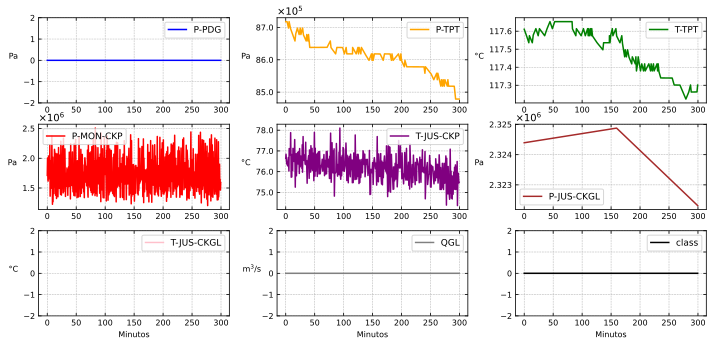

In [63]:
X = pdf0.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf0.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig0, ax0 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [-1, 5, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.3f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax0 = plt.subplot(3,3,i)
    NaN = pdf0.iloc[:,i].isna().sum()
    Y   = pdf0.iloc[:,i].values
    YMIN= Y.min()
    YMAX= Y.max()
    sd  = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax0.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax0.set_xlabel("",fontsize=labelsize)
    else:
        ax0.set_xlabel("Minutos",fontsize=labelsize)
    ax0.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax0.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax0.set_ylim(-2,2)
        ax0.ticklabel_format(style='plain', axis='y')
    else:
        ax0.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax0.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax0.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig0.savefig('figure_instance_0.png', dpi=600, bbox_inches='tight')


In [64]:
WELL1 = current_directory+r"\dataset\1\SIMULATED_00009.csv"
pdf1 = pd.read_csv(WELL1)
pdf1['timestamp'] = pd.to_datetime(pdf1['timestamp'],utc=False)
pdf1 = pdf1.set_index(pdf1['timestamp'])
pdf1.info()
pdf1.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88800 entries, 2018-10-06 06:45:16 to 2018-10-07 07:25:15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   88800 non-null  datetime64[ns]
 1   P-PDG       88800 non-null  float64       
 2   P-TPT       88800 non-null  float64       
 3   T-TPT       88800 non-null  float64       
 4   P-MON-CKP   88800 non-null  float64       
 5   T-JUS-CKP   88800 non-null  float64       
 6   P-JUS-CKGL  0 non-null      float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         0 non-null      float64       
 9   class       88800 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 7.5 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  8.880000e+04  8.880000e+04  88800.000000  8.880000e+04  88800.000000   
mean   2.648994e+07  1.578547e+07     97.715577  1.168722e+06     82.459463   
std    4.033306e+05  1.017847e+05      0.388606  1.794405e+04      2.219998   
min    2.585197e+07  1.566899e+07     97.040490  1.151034e+06     78.613670   
25%    2.608586e+07  1.570979e+07     97.375375  1.151447e+06     80.533840   
50%    2.667860e+07  1.575580e+07     97.773505  1.161151e+06     82.907980   
75%    2.690575e+07  1.580375e+07     98.137770  1.184496e+06     84.853490   
max    2.690586e+07  1.605402e+07     98.139990  1.201226e+06     84.858940   

       P-JUS-CKGL  T-JUS-CKGL  QGL         class  
count         0.0         0.0  0.0  88800.000000  
mean          NaN         NaN  NaN     65.797297  
std           NaN         NaN  NaN     47.831894  
min           NaN         NaN  NaN      0.000000  
25%           NaN         NaN  NaN      1.000000  
50%           NaN         NaN  NaN    101.000000  
75%           NaN         NaN  NaN    101.000000  
max           NaN         NaN  NaN    101.000000

In [65]:
pdf1.head()

timestamp       P-PDG       P-TPT     T-TPT  \
timestamp                                                                   
2018-10-06 06:45:16 2018-10-06 06:45:16  25856770.0  15761370.0  97.04049   
2018-10-06 06:45:17 2018-10-06 06:45:17  25856770.0  15761370.0  97.04049   
2018-10-06 06:45:18 2018-10-06 06:45:18  25856770.0  15761370.0  97.04049   
2018-10-06 06:45:19 2018-10-06 06:45:19  25856770.0  15761370.0  97.04049   
2018-10-06 06:45:20 2018-10-06 06:45:20  25856770.0  15761370.0  97.04050   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2018-10-06 06:45:16  1201226.0   78.61367         NaN         NaN  NaN      0  
2018-10-06 06:45:17  1201226.0   78.61367         NaN         NaN  NaN      0  
2018-10-06 06:45:18  1201226.0   78.61368         NaN         NaN  NaN      0  
2018-10-06 06:45:19  1201226.0   78.61369         NaN         NaN  NaN      0  
2018-10-06 06:45:20  1201226.0   78.61370         NaN         NaN  NaN      0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot 

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

 5
Criando plot  6
Criando plot  7
Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


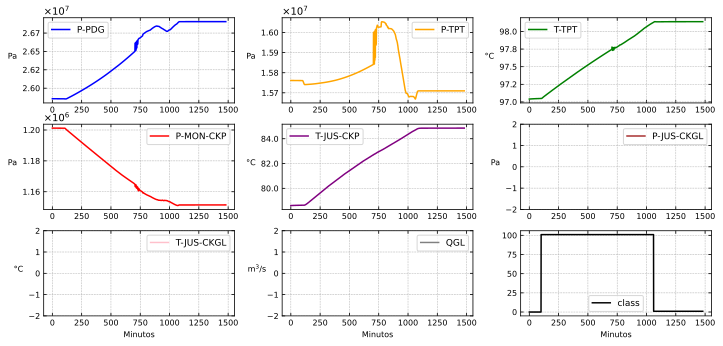

In [66]:
X = pdf1.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf1.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig1, ax1 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.2f", r"%.2f", r"%.1f", r"%.2f", r"%.1f", r"%.3f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax1= plt.subplot(3,3,i)
    NaN= pdf1.iloc[:,i].isna().sum()
    Y  = pdf1.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax1.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax1.set_xlabel("",fontsize=labelsize)
    else:
        ax1.set_xlabel("Minutos",fontsize=labelsize)
    ax1.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax1.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax1.set_ylim(-2,2)
        ax1.ticklabel_format(style='plain', axis='y')
    else:
        ax1.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax1.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax1.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig1.savefig('figure_instance_1.png', dpi=600, bbox_inches='tight')


In [67]:
WELL2 = current_directory+r"\dataset\2\SIMULATED_00010.csv"
pdf2 = pd.read_csv(WELL2)
pdf2['timestamp'] = pd.to_datetime(pdf2['timestamp'],utc=False)
pdf2 = pdf2.set_index(pdf2['timestamp'])
pdf2.info()
pdf2.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28799 entries, 2018-05-13 05:12:11 to 2018-05-13 13:12:09
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   28799 non-null  datetime64[ns]
 1   P-PDG       28799 non-null  float64       
 2   P-TPT       28799 non-null  float64       
 3   T-TPT       28799 non-null  float64       
 4   P-MON-CKP   28799 non-null  float64       
 5   T-JUS-CKP   28799 non-null  float64       
 6   P-JUS-CKGL  0 non-null      float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         0 non-null      float64       
 9   class       28799 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.4 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  2.879900e+04  2.879900e+04  28799.000000  2.879900e+04  28799.000000   
mean   3.314230e+07  1.644157e+07     21.633272  1.001134e+07     40.772353   
std    1.350740e+06  2.380761e+06     41.347689  1.143213e+04     23.112625   
min    2.963383e+07  1.424606e+07      3.423201  1.000533e+07     26.088250   
25%    3.358768e+07  1.486698e+07      3.439835  1.000670e+07     27.720450   
50%    3.368216e+07  1.562908e+07      3.531825  1.000681e+07     30.203840   
75%    3.368747e+07  1.682100e+07      5.380304  1.000697e+07     38.591750   
max    3.381416e+07  2.212881e+07    125.543200  1.004012e+07     95.518300   

       P-JUS-CKGL  T-JUS-CKGL  QGL         class  
count         0.0         0.0  0.0  28799.000000  
mean          NaN         NaN  NaN     14.250425  
std           NaN         NaN  NaN     33.173916  
min           NaN         NaN  NaN      0.000000  
25%           NaN         NaN  NaN      2.000000  
50%           NaN         NaN  NaN      2.000000  
75%           NaN         NaN  NaN      2.000000  
max           NaN         NaN  NaN    102.000000

In [68]:
pdf2.head()

timestamp       P-PDG       P-TPT     T-TPT  \
timestamp                                                                   
2018-05-13 05:12:11 2018-05-13 05:12:11  29633870.0  22128350.0  125.5223   
2018-05-13 05:12:12 2018-05-13 05:12:12  29633850.0  22128350.0  125.5223   
2018-05-13 05:12:13 2018-05-13 05:12:13  29633870.0  22128350.0  125.5223   
2018-05-13 05:12:14 2018-05-13 05:12:14  29633850.0  22128350.0  125.5223   
2018-05-13 05:12:15 2018-05-13 05:12:15  29633870.0  22128350.0  125.5223   

                      P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                       
2018-05-13 05:12:11  10040120.0   95.51830         NaN         NaN  NaN      0  
2018-05-13 05:12:12  10040120.0   95.51830         NaN         NaN  NaN      0  
2018-05-13 05:12:13  10040120.0   95.51829         NaN         NaN  NaN      0  
2018-05-13 05:12:14  10040120.0   95.51828         NaN         NaN  NaN      0  
2018-05-13 05:12:15  10040120.0   95.51827         NaN         NaN  NaN      0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5
Criando plot  6
Criando plot  7


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


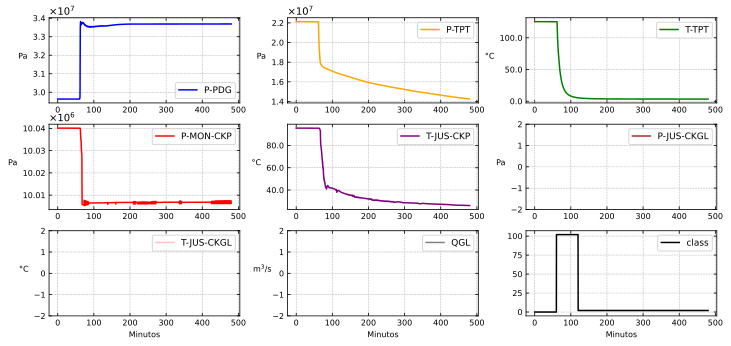

In [69]:
X = pdf2.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf2.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig2, ax2 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.1f", r"%.1f", r"%.1f", r"%.2f", r"%.1f", r"%.3f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax2= plt.subplot(3,3,i)
    NaN= pdf2.iloc[:,i].isna().sum()
    Y  = pdf2.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax2.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax2.set_xlabel("",fontsize=labelsize)
    else:
        ax2.set_xlabel("Minutos",fontsize=labelsize)
    ax2.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax2.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax2.set_ylim(-2,2)
        ax2.ticklabel_format(style='plain', axis='y')
    else:
        ax2.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax2.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax2.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig2.savefig('figure_instance_2.png', dpi=600, bbox_inches='tight')


In [70]:
WELL3 = current_directory+r"\dataset\3\WELL-00014_20170921200114.csv"
pdf3 = pd.read_csv(WELL3)
pdf3['timestamp'] = pd.to_datetime(pdf3['timestamp'],utc=False)
pdf3 = pdf3.set_index(pdf3['timestamp'])
pdf3.info()
pdf3.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17927 entries, 2017-09-21 20:01:14 to 2017-09-22 01:00:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   17927 non-null  datetime64[ns]
 1   P-PDG       17927 non-null  float64       
 2   P-TPT       17927 non-null  float64       
 3   T-TPT       17927 non-null  float64       
 4   P-MON-CKP   17927 non-null  float64       
 5   T-JUS-CKP   17927 non-null  float64       
 6   P-JUS-CKGL  17927 non-null  float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         17927 non-null  float64       
 9   class       17927 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.5 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  1.792700e+04  1.792700e+04  17927.000000  1.792700e+04  17927.000000   
mean   2.414165e+07  1.510830e+07     50.517979  1.922014e+06     28.017603   
std    3.145016e+05  9.133911e+05      5.176223  1.255221e+06      4.462926   
min    2.347051e+07  1.338152e+07     41.599950  1.164159e+06     14.630000   
25%    2.386105e+07  1.426396e+07     45.327265  1.245750e+06     26.299995   
50%    2.428248e+07  1.535210e+07     51.182450  1.310977e+06     30.358630   
75%    2.441368e+07  1.595444e+07     55.903170  2.031506e+06     31.065185   
max    2.451162e+07  1.630224e+07     56.591760  7.507486e+06     32.640000   

         P-JUS-CKGL  T-JUS-CKGL           QGL    class  
count  1.792700e+04         0.0  17927.000000  17927.0  
mean   1.945772e+07         NaN      1.245166      3.0  
std    1.914734e+05         NaN      0.243795      0.0  
min    1.925465e+07         NaN      0.818370      3.0  
25%    1.931871e+07         NaN      1.098915      3.0  
50%    1.936119e+07         NaN      1.163512      3.0  
75%    1.957398e+07         NaN      1.270602      3.0  
max    1.997865e+07         NaN      2.029262      3.0

In [71]:
pdf3.head()

timestamp       P-PDG       P-TPT     T-TPT  \
timestamp                                                                   
2017-09-21 20:01:14 2017-09-21 20:01:14  24389400.0  15923800.0  43.65952   
2017-09-21 20:01:15 2017-09-21 20:01:15  24388900.0  15923280.0  43.65860   
2017-09-21 20:01:16 2017-09-21 20:01:16  24388410.0  15922750.0  43.65767   
2017-09-21 20:01:17 2017-09-21 20:01:17  24388120.0  15921120.0  43.65464   
2017-09-21 20:01:18 2017-09-21 20:01:18  24387820.0  15919480.0  43.65160   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL       QGL  \
timestamp                                                                     
2017-09-21 20:01:14  1490977.0   31.00947  19415620.0         NaN  1.243595   
2017-09-21 20:01:15  1492114.0   31.00781  19415860.0         NaN  1.239152   
2017-09-21 20:01:16  1493250.0   31.00614  19416100.0         NaN  1.234708   
2017-09-21 20:01:17  1494386.0   31.00448  19416350.0         NaN  1.230265   
2017-09-21 20:01:18  1495523.0   31.00282  19416590.0         NaN  1.225821   

                     class  
timestamp                   
2017-09-21 20:01:14      3  
2017-09-21 20:01:15      3  
2017-09-21 20:01:16      3  
2017-09-21 20:01:17      3  
2017-09-21 20:01:18      3

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

Criando plot  6
Criando plot  7
Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


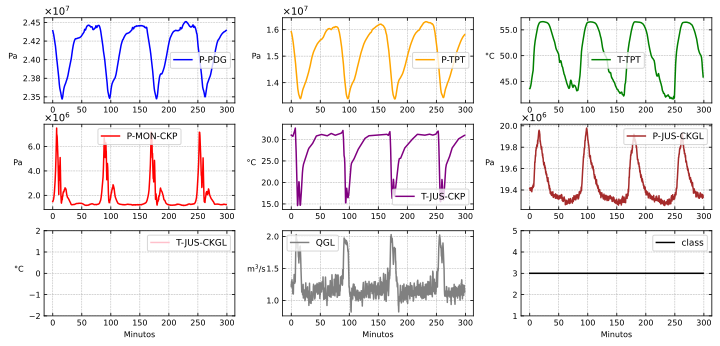

In [72]:
X = pdf3.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf3.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig3, ax3 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, 0, 0]
fmt = [r"%.2f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax3= plt.subplot(3,3,i)
    NaN= pdf3.iloc[:,i].isna().sum()
    Y  = pdf3.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax3.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax3.set_xlabel("",fontsize=labelsize)
    else:
        ax3.set_xlabel("Minutos",fontsize=labelsize)
    ax3.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax3.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax3.set_ylim(-2,2)
        ax3.ticklabel_format(style='plain', axis='y')
    else:
        ax3.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax3.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax3.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig3.savefig('figure_instance_3.png', dpi=600, bbox_inches='tight')


In [73]:
WELL4 = current_directory+r"\dataset\4\WELL-00002_20140109170010.csv"
pdf4 = pd.read_csv(WELL4)
pdf4['timestamp'] = pd.to_datetime(pdf4['timestamp'],utc=False)
pdf4 = pdf4.set_index(pdf4['timestamp'])
pdf4.info()
pdf4.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7191 entries, 2014-01-09 17:00:10 to 2014-01-09 19:00:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   7191 non-null   datetime64[ns]
 1   P-PDG       7191 non-null   float64       
 2   P-TPT       7191 non-null   float64       
 3   T-TPT       7191 non-null   float64       
 4   P-MON-CKP   7191 non-null   float64       
 5   T-JUS-CKP   7191 non-null   float64       
 6   P-JUS-CKGL  7191 non-null   float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         7191 non-null   float64       
 9   class       7191 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 618.0 KB


P-PDG         P-TPT        T-TPT     P-MON-CKP     T-JUS-CKP  \
count  7191.0  7.191000e+03  7191.000000  7.191000e+03  7.191000e+03   
mean      0.0  1.614699e+07   117.759368  7.010464e+06  1.730961e+02   
std       0.0  1.712914e+05     0.062197  3.917237e+05  1.520667e-11   
min       0.0  1.589981e+07   117.653100  5.749265e+06  1.730961e+02   
25%       0.0  1.598719e+07   117.702500  6.816264e+06  1.730961e+02   
50%       0.0  1.614286e+07   117.759800  7.022018e+06  1.730961e+02   
75%       0.0  1.633179e+07   117.816550  7.296894e+06  1.730961e+02   
max       0.0  1.637860e+07   117.887400  7.925856e+06  1.730961e+02   

         P-JUS-CKGL  T-JUS-CKGL     QGL   class  
count  7.191000e+03         0.0  7191.0  7191.0  
mean   4.321504e+06         NaN     0.0     4.0  
std    1.199722e+05         NaN     0.0     0.0  
min    4.126046e+06         NaN     0.0     4.0  
25%    4.208994e+06         NaN     0.0     4.0  
50%    4.324847e+06         NaN     0.0     4.0  
75%    4.445076e+06         NaN     0.0     4.0  
max    4.494959e+06         NaN     0.0     4.0

In [74]:
pdf4.head()

timestamp  P-PDG       P-TPT     T-TPT  \
timestamp                                                              
2014-01-09 17:00:10 2014-01-09 17:00:10    0.0  16305450.0  117.7637   
2014-01-09 17:00:11 2014-01-09 17:00:11    0.0  16305780.0  117.7631   
2014-01-09 17:00:12 2014-01-09 17:00:12    0.0  16306120.0  117.7624   
2014-01-09 17:00:13 2014-01-09 17:00:13    0.0  16306450.0  117.7618   
2014-01-09 17:00:14 2014-01-09 17:00:14    0.0  16306780.0  117.7611   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2014-01-09 17:00:10  7347578.0   173.0961   4255727.0         NaN  0.0      4  
2014-01-09 17:00:11  7345853.0   173.0961   4255632.0         NaN  0.0      4  
2014-01-09 17:00:12  7344130.0   173.0961   4255536.0         NaN  0.0      4  
2014-01-09 17:00:13  7342406.0   173.0961   4255440.0         NaN  0.0      4  
2014-01-09 17:00:14  7340681.0   173.0961   4255345.0         NaN  0.0      4

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot 

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


 4
Criando plot  5
Criando plot  6
Criando plot  7
Criando plot 

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

 8
Criando plot  9


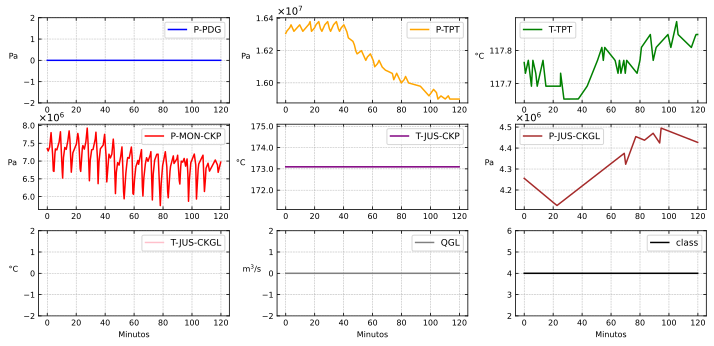

In [75]:
X = pdf4.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf4.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig4, ax4 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.2f", r"%.2f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax4= plt.subplot(3,3,i)
    NaN= pdf4.iloc[:,i].isna().sum()
    Y  = pdf4.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax4.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax4.set_xlabel("",fontsize=labelsize)
    else:
        ax4.set_xlabel("Minutos",fontsize=labelsize)
    ax4.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax4.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax4.set_ylim(-2,2)
        ax4.ticklabel_format(style='plain', axis='y')
    else:
        ax4.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax4.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax4.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig4.savefig('figure_instance_4.png', dpi=600, bbox_inches='tight')


In [76]:
WELL5 = current_directory+r"\dataset\5\SIMULATED_00424.csv"
pdf5 = pd.read_csv(WELL5)
pdf5['timestamp'] = pd.to_datetime(pdf5['timestamp'],utc=False)
pdf5 = pdf5.set_index(pdf5['timestamp'])
pdf5.info()
pdf5.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29299 entries, 2018-04-26 18:30:54 to 2018-04-27 02:39:12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   29299 non-null  datetime64[ns]
 1   P-PDG       29299 non-null  float64       
 2   P-TPT       29299 non-null  float64       
 3   T-TPT       29299 non-null  float64       
 4   P-MON-CKP   29299 non-null  float64       
 5   T-JUS-CKP   29299 non-null  float64       
 6   P-JUS-CKGL  0 non-null      float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         0 non-null      float64       
 9   class       29299 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.5 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  2.929900e+04  2.929900e+04  29299.000000  2.929900e+04  29299.000000   
mean   2.734398e+07  1.831909e+07    125.712182  1.493962e+06     98.334515   
std    3.461969e+04  2.791594e+04      0.006480  1.308648e+03      0.027402   
min    2.733008e+07  1.830673e+07    125.707300  1.493312e+06     98.320890   
25%    2.733177e+07  1.830914e+07    125.709900  1.493450e+06     98.321180   
50%    2.733181e+07  1.830922e+07    125.710100  1.493452e+06     98.322710   
75%    2.733187e+07  1.830931e+07    125.710400  1.493460e+06     98.329820   
max    2.747737e+07  1.842443e+07    125.740700  1.498276e+06     98.423510   

       P-JUS-CKGL  T-JUS-CKGL  QGL         class  
count         0.0         0.0  0.0  29299.000000  
mean          NaN         NaN  NaN     19.590942  
std           NaN         NaN  NaN     35.428813  
min           NaN         NaN  NaN      0.000000  
25%           NaN         NaN  NaN      5.000000  
50%           NaN         NaN  NaN      5.000000  
75%           NaN         NaN  NaN      5.000000  
max           NaN         NaN  NaN    105.000000

In [77]:
pdf5.head()

timestamp       P-PDG       P-TPT     T-TPT  \
timestamp                                                                   
2018-04-26 18:30:54 2018-04-26 18:30:54  27477200.0  18424010.0  125.7405   
2018-04-26 18:30:55 2018-04-26 18:30:55  27477240.0  18423970.0  125.7406   
2018-04-26 18:30:56 2018-04-26 18:30:56  27477250.0  18424060.0  125.7404   
2018-04-26 18:30:57 2018-04-26 18:30:57  27477260.0  18424010.0  125.7405   
2018-04-26 18:30:58 2018-04-26 18:30:58  27477260.0  18424030.0  125.7403   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2018-04-26 18:30:54  1498269.0   98.42351         NaN         NaN  NaN      0  
2018-04-26 18:30:55  1498269.0   98.42349         NaN         NaN  NaN      0  
2018-04-26 18:30:56  1498269.0   98.42349         NaN         NaN  NaN      0  
2018-04-26 18:30:57  1498269.0   98.42348         NaN         NaN  NaN      0  
2018-04-26 18:30:58  1498271.0   98.42347         NaN         NaN  NaN      0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5
Criando plot  6
Criando plot 

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

 7
Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


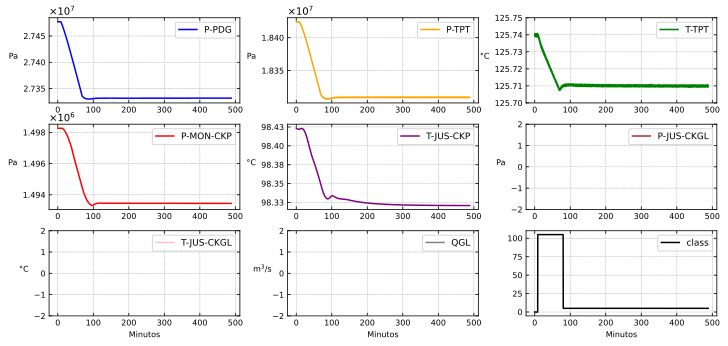

In [78]:
X = pdf5.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf5.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig5, ax5 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.3f", r"%.3f", r"%.2f", r"%.3f", r"%.2f", r"%.3f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax5= plt.subplot(3,3,i)
    NaN= pdf5.iloc[:,i].isna().sum()
    Y  = pdf5.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax5.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax5.set_xlabel("",fontsize=labelsize)
    else:
        ax5.set_xlabel("Minutos",fontsize=labelsize)
    ax5.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax5.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax5.set_ylim(-2,2)
        ax5.ticklabel_format(style='plain', axis='y')
    else:
        if i!=3:
            ax5.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
            ax5.ticklabel_format(style='sci', axis='y', scilimits=(-4,2))
        else:
            ax5.set_ylim(125.7,125.75)
            ax5.ticklabel_format(style='plain', axis='y',useOffset=False)
            
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax5.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig5.savefig('figure_instance_5.png', dpi=600, bbox_inches='tight')


In [79]:
WELL6 = current_directory+r"\dataset\6\WELL-00002_20140212170333.csv"
pdf6 = pd.read_csv(WELL6)
pdf6['timestamp'] = pd.to_datetime(pdf6['timestamp'],utc=False)
pdf6 = pdf6.set_index(pdf6['timestamp'])
pdf6.info()
pdf6.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24370 entries, 2014-02-12 17:03:33 to 2014-02-12 23:49:42
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   24370 non-null  datetime64[ns]
 1   P-PDG       24370 non-null  float64       
 2   P-TPT       24370 non-null  float64       
 3   T-TPT       24370 non-null  float64       
 4   P-MON-CKP   24370 non-null  float64       
 5   T-JUS-CKP   24370 non-null  float64       
 6   P-JUS-CKGL  24370 non-null  float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         24370 non-null  float64       
 9   class       24131 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.0 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  24370.0  2.437000e+04  24370.000000  2.437000e+04  24370.000000   
mean       0.0  1.299669e+07    118.756768  2.783573e+06     83.204105   
std        0.0  2.386221e+05      0.081393  3.588506e+05      0.150806   
min        0.0  1.276773e+07    118.590500  2.463764e+06     83.054110   
25%        0.0  1.280763e+07    118.715900  2.513813e+06     83.067880   
50%        0.0  1.287711e+07    118.747800  2.514753e+06     83.138060   
75%        0.0  1.327930e+07    118.785800  3.279012e+06     83.347045   
max        0.0  1.340611e+07    118.942100  3.373924e+06     83.496640   

         P-JUS-CKGL  T-JUS-CKGL      QGL         class  
count  2.437000e+04         0.0  24370.0  24131.000000  
mean   4.517797e+06         NaN      0.0     12.236459  
std    1.741340e+05         NaN      0.0     31.314687  
min    4.297972e+06         NaN      0.0      0.000000  
25%    4.361370e+06         NaN      0.0      0.000000  
50%    4.458938e+06         NaN      0.0      0.000000  
75%    4.722709e+06         NaN      0.0      6.000000  
max    4.802594e+06         NaN      0.0    106.000000

In [80]:
pdf6.head()

timestamp  P-PDG       P-TPT     T-TPT  \
timestamp                                                              
2014-02-12 17:03:33 2014-02-12 17:03:33    0.0  12804630.0  118.7102   
2014-02-12 17:03:34 2014-02-12 17:03:34    0.0  12804800.0  118.7104   
2014-02-12 17:03:35 2014-02-12 17:03:35    0.0  12804970.0  118.7106   
2014-02-12 17:03:36 2014-02-12 17:03:36    0.0  12805130.0  118.7108   
2014-02-12 17:03:37 2014-02-12 17:03:37    0.0  12805300.0  118.7110   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2014-02-12 17:03:33  2514857.0   83.49664   4802594.0         NaN  0.0    0.0  
2014-02-12 17:03:34  2514857.0   83.49661   4802581.0         NaN  0.0    0.0  
2014-02-12 17:03:35  2514857.0   83.49659   4802568.0         NaN  0.0    0.0  
2014-02-12 17:03:36  2514856.0   83.49656   4802555.0         NaN  0.0    0.0  
2014-02-12 17:03:37  2514856.0   83.49654   4802542.0         NaN  0.0    0.0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5
Criando plot  6
Criando plot  7


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


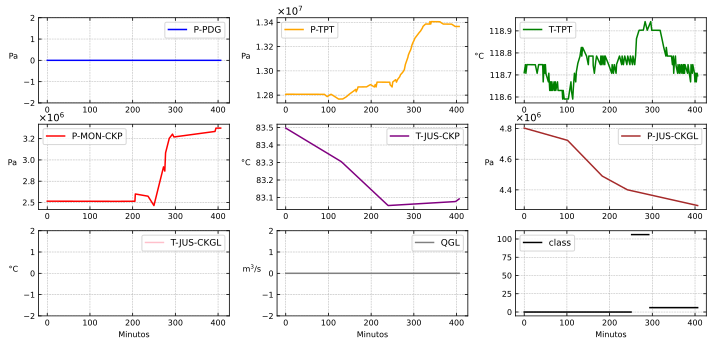

In [81]:
X = pdf6.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf6.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig6, ax6 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.2f", r"%.2f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax6= plt.subplot(3,3,i)
    NaN= pdf6.iloc[:,i].isna().sum()
    Y  = pdf6.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax6.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax6.set_xlabel("",fontsize=labelsize)
    else:
        ax6.set_xlabel("Minutos",fontsize=labelsize)
    ax6.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax6.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax6.set_ylim(-2,2)
        ax6.ticklabel_format(style='plain', axis='y')
    else:
        ax6.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax6.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax6.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig6.savefig('figure_instance_6.png', dpi=600, bbox_inches='tight')


In [82]:
WELL7 = current_directory+r"\dataset\7\WELL-00001_20170226220309.csv"
pdf7 = pd.read_csv(WELL7)
pdf7['timestamp'] = pd.to_datetime(pdf7['timestamp'],utc=False)
pdf7 = pdf7.set_index(pdf7['timestamp'])
pdf7.info()
pdf7.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44150 entries, 2017-02-26 22:03:09 to 2017-02-27 10:18:58
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   44150 non-null  datetime64[ns]
 1   P-PDG       44150 non-null  float64       
 2   P-TPT       44150 non-null  float64       
 3   T-TPT       44150 non-null  float64       
 4   P-MON-CKP   44150 non-null  float64       
 5   T-JUS-CKP   44150 non-null  float64       
 6   P-JUS-CKGL  44150 non-null  float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         44150 non-null  float64       
 9   class       43962 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 3.7 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  44150.0  4.415000e+04  44150.000000  4.415000e+04  44150.000000   
mean       0.0  1.344511e+07    117.926466  5.504004e+06     72.753016   
std        0.0  1.144027e+05      0.172113  1.166919e+05      1.021727   
min        0.0  1.328642e+07    117.614000  5.257381e+06     70.635830   
25%        0.0  1.334207e+07    117.750400  5.399864e+06     71.828845   
50%        0.0  1.340611e+07    117.977600  5.482106e+06     73.121395   
75%        0.0  1.355183e+07    118.104700  5.610805e+06     73.659510   
max        0.0  1.368541e+07    118.160900  5.752159e+06     74.296750   

         P-JUS-CKGL  T-JUS-CKGL      QGL         class  
count  4.415000e+04         0.0  44150.0  43962.000000  
mean   3.384735e+06         NaN      0.0     92.609959  
std    5.894624e+02         NaN      0.0     36.326554  
min    3.383878e+06         NaN      0.0      0.000000  
25%    3.384157e+06         NaN      0.0    107.000000  
50%    3.384696e+06         NaN      0.0    107.000000  
75%    3.385251e+06         NaN      0.0    107.000000  
max    3.385812e+06         NaN      0.0    107.000000

In [83]:
pdf7.head()

timestamp  P-PDG       P-TPT     T-TPT  \
timestamp                                                              
2017-02-26 22:03:09 2017-02-26 22:03:09    0.0  13342350.0  118.1273   
2017-02-26 22:03:10 2017-02-26 22:03:10    0.0  13342390.0  118.1273   
2017-02-26 22:03:11 2017-02-26 22:03:11    0.0  13342430.0  118.1273   
2017-02-26 22:03:12 2017-02-26 22:03:12    0.0  13342470.0  118.1273   
2017-02-26 22:03:13 2017-02-26 22:03:13    0.0  13342510.0  118.1272   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2017-02-26 22:03:09  5390925.0   73.97794   3385812.0         NaN  0.0    0.0  
2017-02-26 22:03:10  5390720.0   73.97781   3385812.0         NaN  0.0    0.0  
2017-02-26 22:03:11  5390515.0   73.97768   3385812.0         NaN  0.0    0.0  
2017-02-26 22:03:12  5390310.0   73.97756   3385812.0         NaN  0.0    0.0  
2017-02-26 22:03:13  5390105.0   73.97743   3385812.0         NaN  0.0    0.0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot 

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


 5
Criando plot  6
Criando plot  7
Criando plot  8
Criando plot  9


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

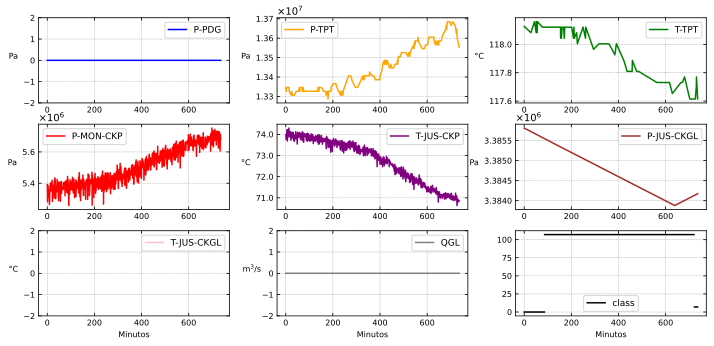

In [84]:
X = pdf7.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf7.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig7, ax7 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.2f", r"%.2f", r"%.1f", r"%.1f", r"%.1f", r"%.4f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax7= plt.subplot(3,3,i)
    NaN= pdf7.iloc[:,i].isna().sum()
    Y  = pdf7.iloc[:,i].values
    YC = pdf7.iloc[:,i].fillna(0).values
    YMIN = YC.min()
    YMAX = YC.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax7.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax7.set_xlabel("",fontsize=labelsize)
    else:
        ax7.set_xlabel("Minutos",fontsize=labelsize)
    ax7.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax7.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN>-1 and YMAX<1):
        ax7.set_ylim(-2,2)
        ax7.ticklabel_format(style='plain', axis='y')
    else:
        ax7.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax7.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax7.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig7.savefig('figure_instance_7.png', dpi=600, bbox_inches='tight')


In [85]:
WELL8 = current_directory+r"\dataset\8\SIMULATED_00056.csv"
pdf8 = pd.read_csv(WELL8)
pdf8['timestamp'] = pd.to_datetime(pdf8['timestamp'],utc=False)
pdf8 = pdf8.set_index(pdf8['timestamp'])
pdf8.info()
pdf8.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26999 entries, 2018-05-18 20:18:55 to 2018-05-19 03:48:53
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   26999 non-null  datetime64[ns]
 1   P-PDG       26999 non-null  float64       
 2   P-TPT       26999 non-null  float64       
 3   T-TPT       26999 non-null  float64       
 4   P-MON-CKP   26999 non-null  float64       
 5   T-JUS-CKP   26999 non-null  float64       
 6   P-JUS-CKGL  0 non-null      float64       
 7   T-JUS-CKGL  0 non-null      float64       
 8   QGL         0 non-null      float64       
 9   class       26999 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.3 MB


P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  2.699900e+04  2.699900e+04  26999.000000  2.699900e+04  26999.000000   
mean   2.842599e+07  2.169536e+07     75.856298  4.030605e+06     77.187201   
std    2.445799e+06  3.427518e+06     58.839010  2.333235e+04     23.774753   
min    2.600337e+07  1.833130e+07      3.126950  4.001628e+06     34.681930   
25%    2.603742e+07  1.837682e+07      3.409614  4.002549e+06     52.271330   
50%    2.687903e+07  1.948725e+07    125.317800  4.047246e+06     94.820430   
75%    3.116230e+07  2.558206e+07    125.320500  4.052339e+06     95.837810   
max    3.130916e+07  2.593616e+07    125.358400  4.052604e+06     95.891140   

       P-JUS-CKGL  T-JUS-CKGL  QGL         class  
count         0.0         0.0  0.0  26999.000000  
mean          NaN         NaN  NaN     86.543650  
std           NaN         NaN  NaN     41.748374  
min           NaN         NaN  NaN      0.000000  
25%           NaN         NaN  NaN    108.000000  
50%           NaN         NaN  NaN    108.000000  
75%           NaN         NaN  NaN    108.000000  
max           NaN         NaN  NaN    108.000000

In [86]:
pdf8.head()

timestamp       P-PDG       P-TPT     T-TPT  \
timestamp                                                                   
2018-05-18 20:18:55 2018-05-18 20:18:55  26003370.0  18331500.0  125.3177   
2018-05-18 20:18:56 2018-05-18 20:18:56  26003400.0  18331470.0  125.3188   
2018-05-18 20:18:57 2018-05-18 20:18:57  26003370.0  18331670.0  125.3179   
2018-05-18 20:18:58 2018-05-18 20:18:58  26003400.0  18331680.0  125.3174   
2018-05-18 20:18:59 2018-05-18 20:18:59  26003370.0  18331630.0  125.3183   

                     P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
timestamp                                                                      
2018-05-18 20:18:55  4052603.0   95.89114         NaN         NaN  NaN      0  
2018-05-18 20:18:56  4052603.0   95.89113         NaN         NaN  NaN      0  
2018-05-18 20:18:57  4052603.0   95.89113         NaN         NaN  NaN      0  
2018-05-18 20:18:58  4052603.0   95.89113         NaN         NaN  NaN      0  
2018-05-18 20:18:59  4052603.0   95.89113         NaN         NaN  NaN      0

Criando plot  1
Criando plot  2
Criando plot  3
Criando plot  4
Criando plot  5
Criando plot  6
Criando plot  7
Criando plot  8


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

Criando plot  9


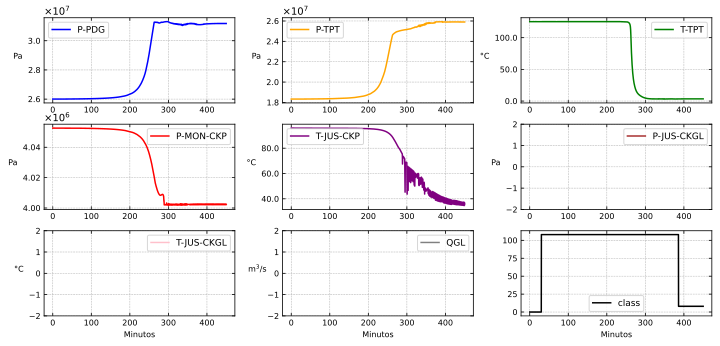

In [87]:
X = pdf8.iloc[:,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf8.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig8, ax8 = plt.subplots(nrows=3, ncols=3, figsize=(12,5.5))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.1f", r"%.1f", r"%.1f", r"%.2f", r"%.1f", r"%.3f", r"%.1f", r"%.1f", r"%.0f"]

for i in range(1,10):
    print("Criando plot ",i)
    ax8= plt.subplot(3,3,i)
    NaN= pdf8.iloc[:,i].isna().sum()
    Y  = pdf8.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i-1], label=columns[i-1])
    ax8.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<7):
        ax8.set_xlabel("",fontsize=labelsize)
    else:
        ax8.set_xlabel("Minutos",fontsize=labelsize)
    ax8.set_ylabel(ylabel[i-1],fontsize=labelsize,rotation="horizontal",labelpad=10)
    if (YMIN==YMAX):
        ax8.set_ylim(YMIN-2,YMAX+2)
    if (NaN==NROW) or (YMIN==0 and YMAX==0):
        ax8.set_ylim(-2,2)
        ax8.ticklabel_format(style='plain', axis='y')
    else:
        ax8.yaxis.set_major_formatter(OOMFormatter(sci[i-1],fmt[i-1]))
        ax8.ticklabel_format(style='sci', axis='y', scilimits=(-4,1))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax8.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig8.savefig('figure_instance_8.png', dpi=600, bbox_inches='tight')


In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [89]:
scaler = StandardScaler()

In [90]:
pdf8t = pd.read_csv(WELL8,index_col='timestamp', parse_dates=['timestamp'])
pdf8t.describe()

P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP  \
count  2.699900e+04  2.699900e+04  26999.000000  2.699900e+04  26999.000000   
mean   2.842599e+07  2.169536e+07     75.856298  4.030605e+06     77.187201   
std    2.445799e+06  3.427518e+06     58.839010  2.333235e+04     23.774753   
min    2.600337e+07  1.833130e+07      3.126950  4.001628e+06     34.681930   
25%    2.603742e+07  1.837682e+07      3.409614  4.002549e+06     52.271330   
50%    2.687903e+07  1.948725e+07    125.317800  4.047246e+06     94.820430   
75%    3.116230e+07  2.558206e+07    125.320500  4.052339e+06     95.837810   
max    3.130916e+07  2.593616e+07    125.358400  4.052604e+06     95.891140   

       P-JUS-CKGL  T-JUS-CKGL  QGL         class  
count         0.0         0.0  0.0  26999.000000  
mean          NaN         NaN  NaN     86.543650  
std           NaN         NaN  NaN     41.748374  
min           NaN         NaN  NaN      0.000000  
25%           NaN         NaN  NaN    108.000000  
50%           NaN         NaN  NaN    108.000000  
75%           NaN         NaN  NaN    108.000000  
max           NaN         NaN  NaN    108.000000

In [91]:
cols8 = pdf8t.columns[~(pdf8t.isnull().mean()>0.1) & ~((pdf8t.std())/(pdf8t.isnull().mean())<0.01)]
cols_drop = pdf8t.columns[(pdf8t.isnull().mean()>0.1) | ((pdf8t.std())/(pdf8t.isnull().mean())<0.01)]
pdf8t.drop(cols_drop, axis=1, inplace=True)
print(cols8)
print(cols_drop)
print(pdf8t.keys())
#pdf8t = pdf8t.replace(np.nan, 0)
print(pdf8t.shape)
pdf8t_scaled = scaler.fit_transform(pdf8t.iloc[::60, 0:5].to_numpy())
newcols = pdf8t.iloc[:, 0:5].columns
print(newcols)

Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'], dtype='object')
Index(['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL'], dtype='object')
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'], dtype='object')
(26999, 6)
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], dtype='object')


In [92]:
pdf8t_scaled = pd.DataFrame(pdf8t_scaled, columns=newcols)
pdf8t_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   P-PDG      450 non-null    float64
 1   P-TPT      450 non-null    float64
 2   T-TPT      450 non-null    float64
 3   P-MON-CKP  450 non-null    float64
 4   T-JUS-CKP  450 non-null    float64
dtypes: float64(5)
memory usage: 17.7 KB


In [93]:
pdf8t_scaled.describe()

P-PDG         P-TPT         T-TPT     P-MON-CKP     T-JUS-CKP
count  4.500000e+02  4.500000e+02  4.500000e+02  4.500000e+02  4.500000e+02
mean  -4.065883e-16 -3.784627e-16  3.903051e-16 -2.689700e-15  4.505038e-16
std    1.001113e+00  1.001113e+00  1.001113e+00  1.001113e+00  1.001113e+00
min   -9.884132e-01 -9.793935e-01 -1.238487e+00 -1.234472e+00 -1.768435e+00
25%   -9.745792e-01 -9.661917e-01 -1.234033e+00 -1.205000e+00 -1.073482e+00
50%   -6.380668e-01 -6.493379e-01  8.387840e-01  7.153233e-01  7.426098e-01
75%    1.120655e+00  1.134987e+00  8.388341e-01  9.295681e-01  7.850197e-01
max    1.181167e+00  1.239297e+00  8.394530e-01  9.408678e-01  7.872736e-01

Criando plot  0
-0.9884132411871127 1.1811672018979291
Criando plot  1
-0.9793935039599398 1.239296516751797
Criando plot  2
-1.2384867048814927 0.8394530215125997
Criando plot  3
-1.234471609362866 0.9408678053862662
Criando plot  4
-1.7684348517242157

C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwis

 0.7872736476457008
Criando plot  5
0 108


C:\PGS\Anaconda\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


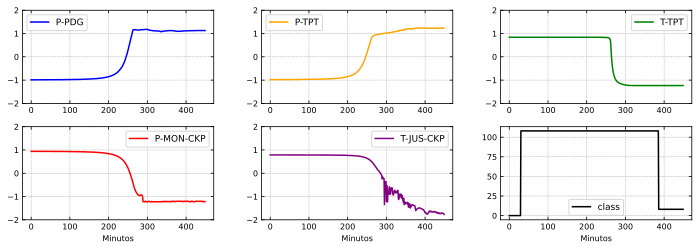

In [94]:
X = pdf8.iloc[::60,0].values
X_MIN = float(X.min())
Xsec = np.array([])
NROW = pdf8.shape[0]
for i in range(0,len(X)):
    Xsec = np.append(Xsec, ((float(X[i])-X_MIN)/1.0e9)/60.0)
    
fig8t, ax8t = plt.subplots(nrows=3, ncols=3, figsize=(12,6))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
sci = [7, 7, 0, 6, 0, 6, -1, -1, 0]
fmt = [r"%.2f", r"%.2f", r"%.2f", r"%.2f", r"%.2f", r"%.2f", r"%.2f", r"%.2f", r"%.0f"]
fig8t.delaxes(ax8t[2][2])
fig8t.delaxes(ax8t[2][1])
fig8t.delaxes(ax8t[2][0])
fig8t.delaxes(ax8t[1][2])

for i in range(0,6):
    print("Criando plot ",i)
    ax8t= plt.subplot(3,3,i+1)
    if i==5:
        NaN= pdf8.iloc[::60,9].isna().sum()
        Y  = pdf8.iloc[::60,9].values
    else:
        NaN= pdf8t_scaled.iloc[:,i].isna().sum()
        Y  = pdf8t_scaled.iloc[:,i].values
    YMIN = Y.min()
    YMAX = Y.max()
    print(YMIN,YMAX)
    if i==5:
        sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[8], label=columns[8])
    else:
        sd = plt.plot(Xsec, Y, linewidth=linewidth, color=colors[i], label=columns[i])
    ax8t.set_xlim(-0.05*Xsec[-1],1.05*Xsec[-1])
    plt.xlabel(Xsec, fontsize=fontsize)
    if (i<3):
        ax8t.set_xlabel("",fontsize=labelsize)
    else:
        ax8t.set_xlabel("Minutos",fontsize=labelsize)
    ax8t.set_ylabel("",fontsize=labelsize,rotation="horizontal",labelpad=10)
    if i<5:
        ax8t.set_ylim(-2,2)
    ax8t.ticklabel_format(style='plain', axis='y')
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    ax8t.tick_params(direction='in', labelsize=ticklabelsize, right=True, top=True, length=plot_ticklength)

fig8t.savefig('figure_instance_8t.png', dpi=600, bbox_inches='tight')


<h1>Análise 1</h1>

<br>Verificar se anomalias em poços de petróleo podem ser detectadas com técnicas de aprendizado de máquina

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append('stac')
from math import ceil
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [96]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [97]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [98]:
data_path = Path(r'C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master', 'dataset')

In [99]:
gamma = 'scale'
nu = 0.5
random_state = 1
n_jobs = None
clfs = {'One Class SVM - RBF':     OneClassSVM(kernel='rbf', gamma=gamma, nu=nu),
        'One Class SVM - SIGMOID': OneClassSVM(kernel='sigmoid', gamma=gamma, nu=nu),
        'One Class SVM - POLY':    OneClassSVM(kernel='poly', gamma=gamma, nu=nu),
        'One Class SVM - LINEAR':  OneClassSVM(kernel='linear', gamma=gamma, nu=nu),
        'Isolation Forest':        IsolationForest(n_jobs=n_jobs, behaviour='new',
                                                   contamination=0, random_state=random_state),
        'Dummy':                   DummyClassifier(strategy='constant', constant=1)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # In observations = seconds
min_normal_period_size = 20*60  # In observations = seconds
split_range = 0.6               # Train size/test size
max_samples_per_period = 15     # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
max_nan_percent = 0.1           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

In [100]:
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [101]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [102]:
def extract_samples(df, class_code):
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Discards the observations labels and replaces all nan with 0 
    # (tsfresh's requirement)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Initializes objects that will be return
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Find out max numbers of samples from normal, transient and in regime periods
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Defines the initial numbers of samples for normal period
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Defines the max number of samples for transient period    
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Defines the max number of samples for in regime period
    if class_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Find out proper numbers of samples from normal, transient and in regime periods
    #
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    #print('num_train_samples: {}'.format(num_train_samples))
    #print('num_test_samples: {}'.format(num_test_samples))        
    #print('num_transient_samples: {}'.format(num_transient_samples))        
    #print('num_in_regime_samples: {}'.format(num_in_regime_samples))
    
    # Extracts samples from the normal period for training and for testing
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Defines the proper step and extracts samples
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extracts samples for training
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extracts samples for testing
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extracts samples from the transient period (if it exists) for testing
    #  
    if (num_transient_samples) > 0:    
        # Defines the proper step and extracts samples
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extracts samples
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extracts samples from the in regime period (if it exists) for testing 
    #
    if (num_in_regime_samples) > 0:     
        # Defines the proper step and extracts samples
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extracts samples
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              

In [103]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)    
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            if clf_name!='Dummy': 
                clf.fit(X_train)
            else:
                clf.fit(X_train, np.array([1]*len(y_train))) # y_train must have at least one normal sample
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(-(y_pred), marker=11, color='orange', linestyle='') # Inverted order (more natural)
            plt.plot(-(y_test), marker=10, color='green', linestyle='')  # Inverted order (more natural)
            ax.grid(False)
            ax.set_yticks([-1, 1])
            ax.set_yticklabels(['Normal', 'Abnormal'])
            ax.set_title(clf_name)            
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()

            # Calculates the considered scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
            p, r, f1, _ = ret
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAINING[s]': t_train, 
                                    'TESTING[s]': t_test}, ignore_index=True)

        except:
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAINING[s]': np.nan, 
                                    'TESTING[s]': np.nan}, ignore_index=True)
        
    return scores

In [104]:
import numpy as np
import scipy as sp
import scipy.stats as st
import itertools as it

def holm_test_local(k, values, keys, control=None):
    """
        Performs a Holm post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. S. Holm, A simple sequentially rejective multiple test procedure, Scandinavian Journal of Statistics 6 (1979) 65–70.
    """
    #k = len(ranks)
    #values = ranks.values()
    #keys = ranks.keys()
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max((k-(j+1))*p_values[j] for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

instance 1: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\1\WELL-00001_20140124213136.csv
	skipped because normal_period_size is insufficient for training (959)
instance 2: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\1\WELL-00002_20140126200050.csv
	skipped because normal_period_size is insufficient for training (1138)
instance 3: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\1\WELL-00006_20170801063614.csv


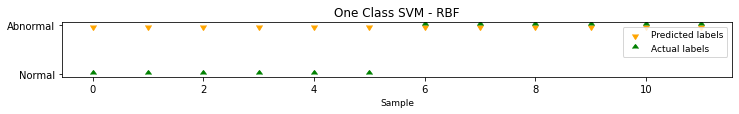

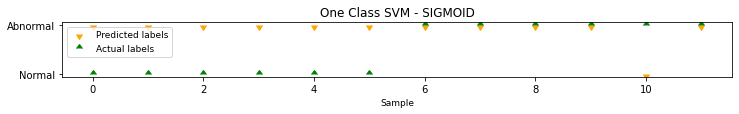

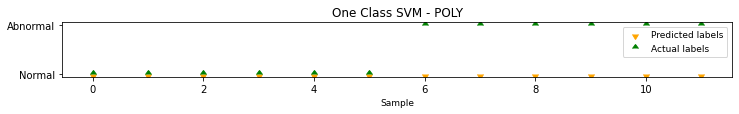

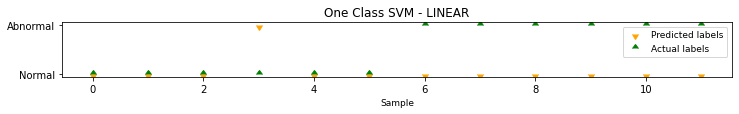

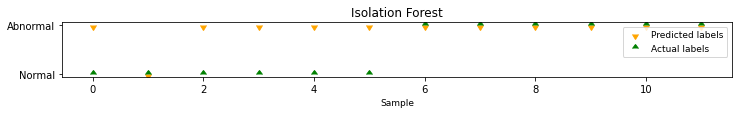

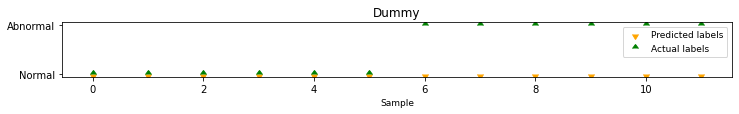

instance 4: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\1\WELL-00006_20170802123000.csv


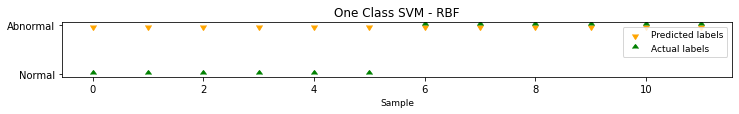

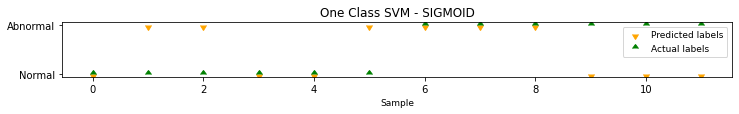

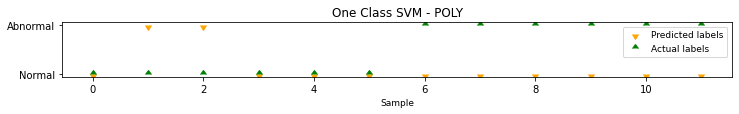

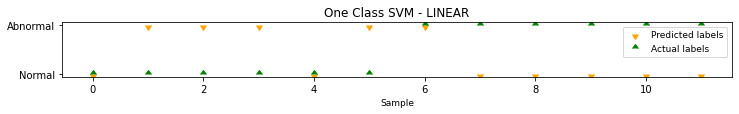

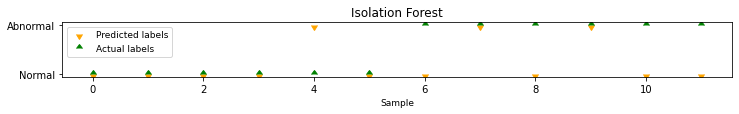

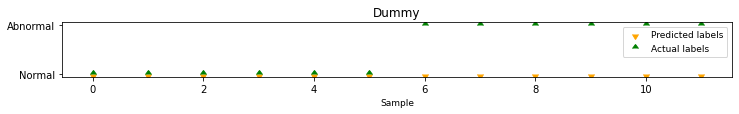

instance 5: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\1\WELL-00006_20180618060245.csv


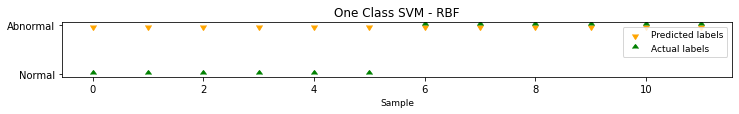

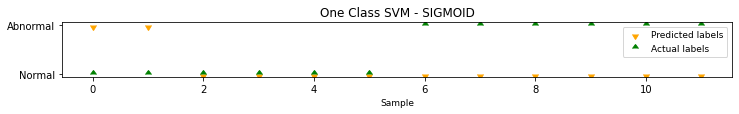

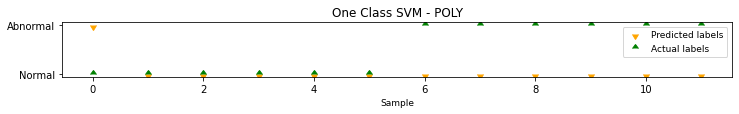

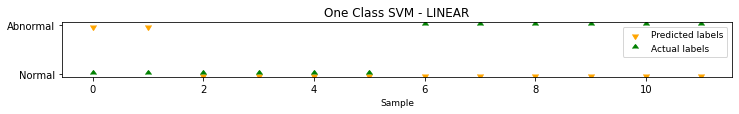

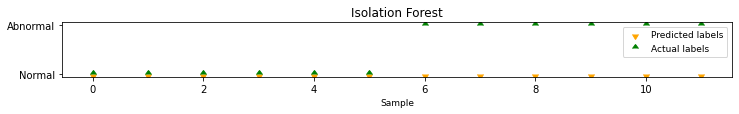

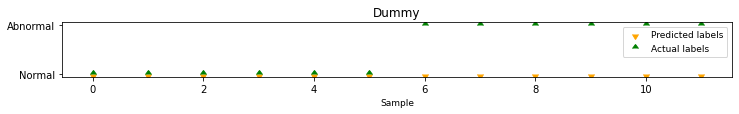

instance 6: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00002_20131104014101.csv


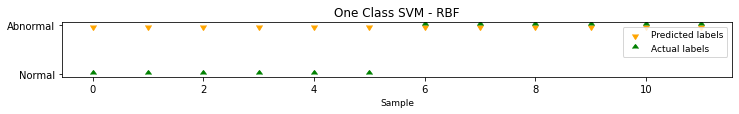

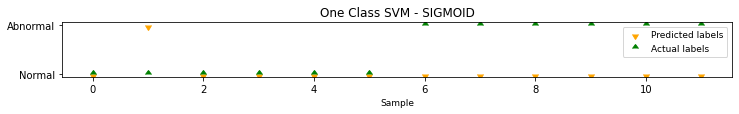

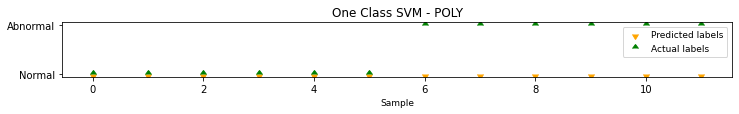

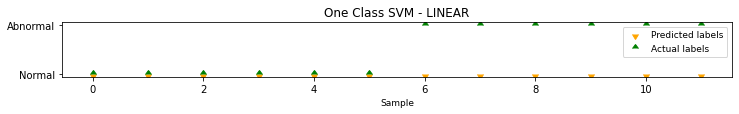

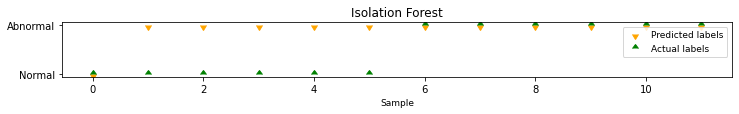

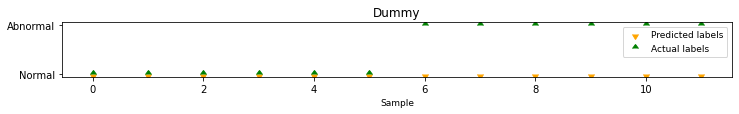

instance 7: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00003_20141122214325.csv


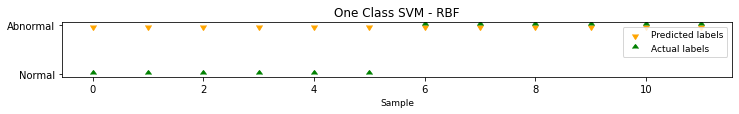

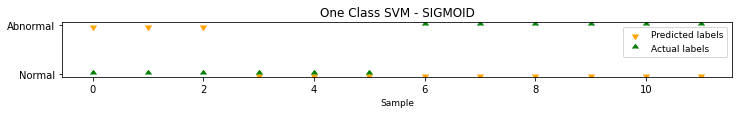

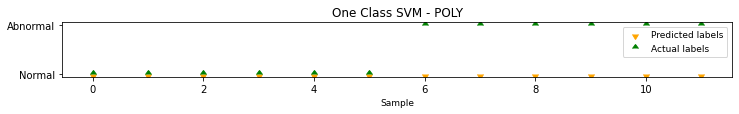

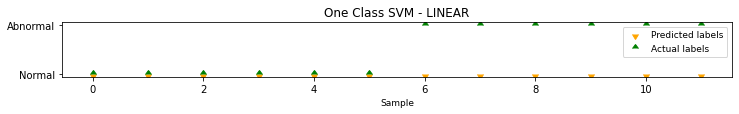

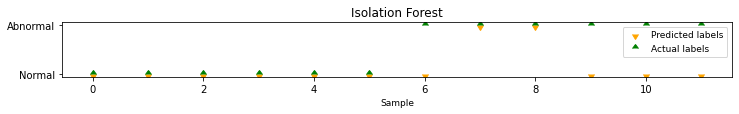

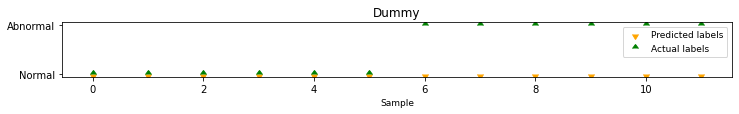

instance 8: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00003_20170728150240.csv


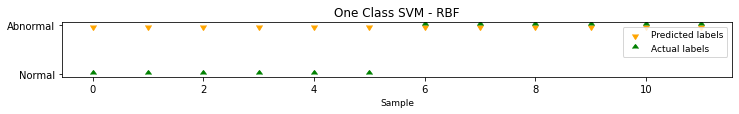

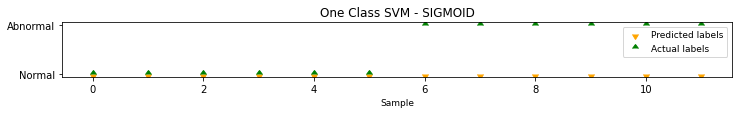

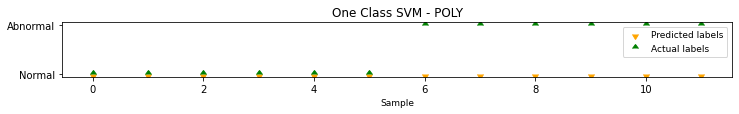

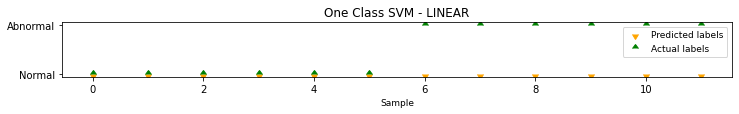

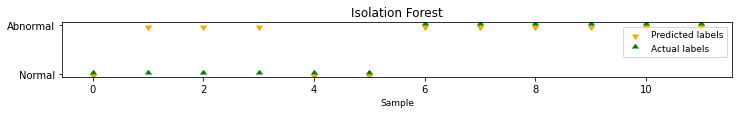

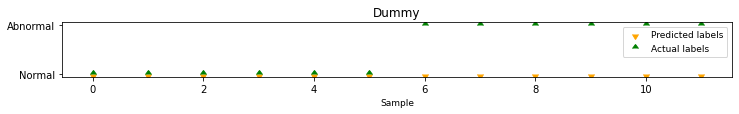

instance 9: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00003_20180206182917.csv
	skipped because normal_period_size is insufficient for training (586)
instance 10: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00009_20170313160804.csv


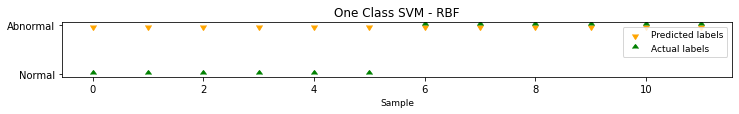

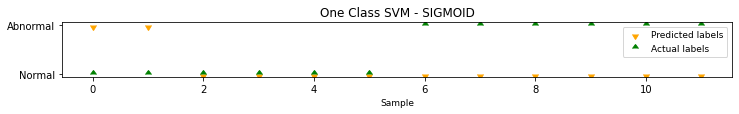

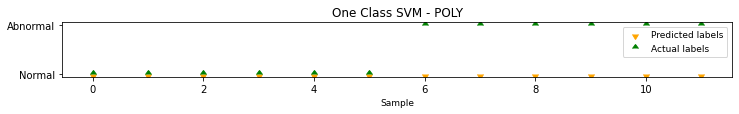

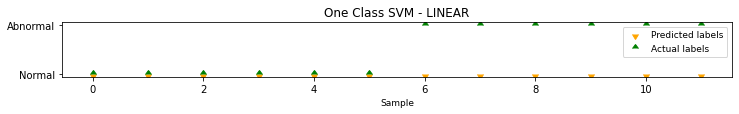

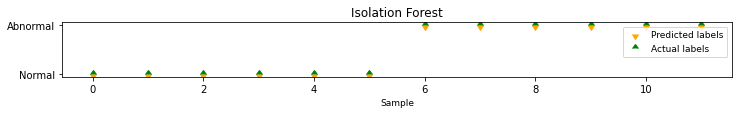

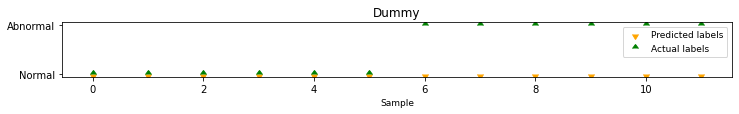

instance 11: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00010_20171218200131.csv


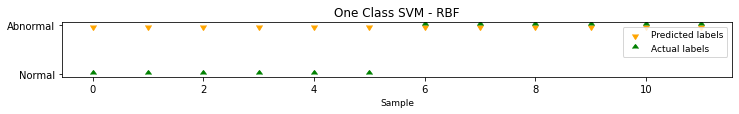

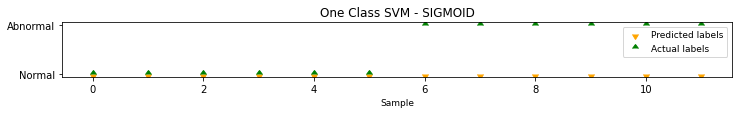

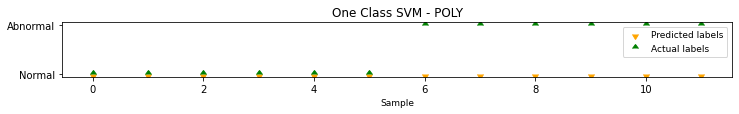

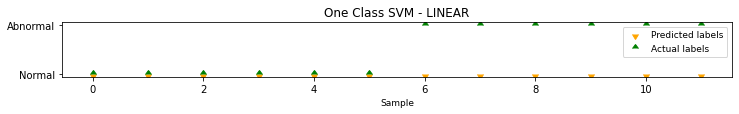

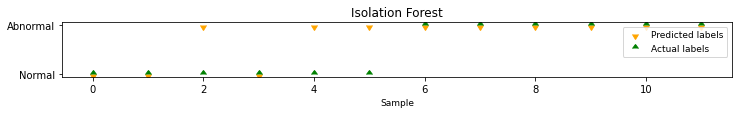

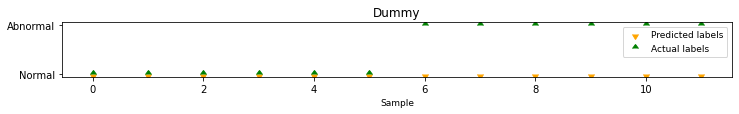

instance 12: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140515110134.csv


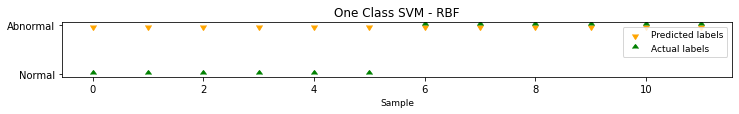

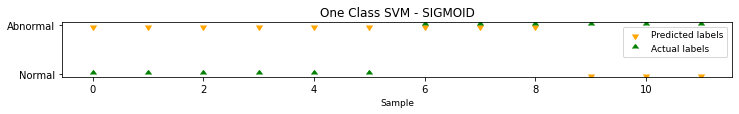

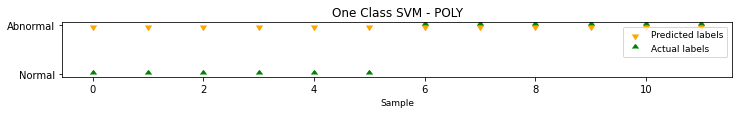

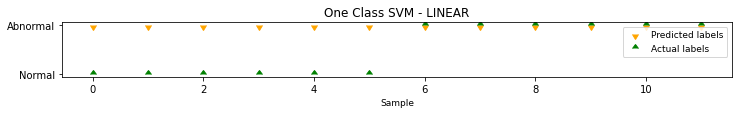

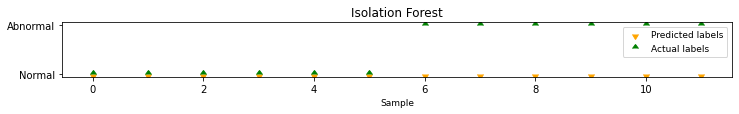

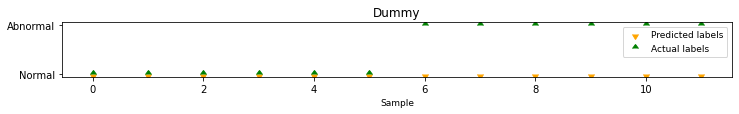

instance 13: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140530100015.csv
	skipped because normal_period_size is insufficient for training (482)
instance 14: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140606230115.csv


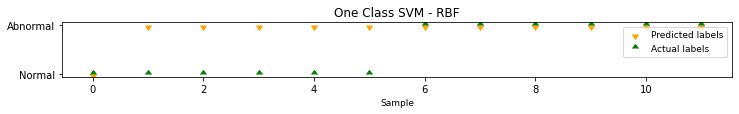

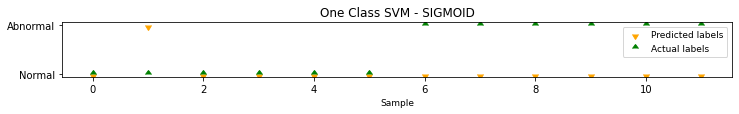

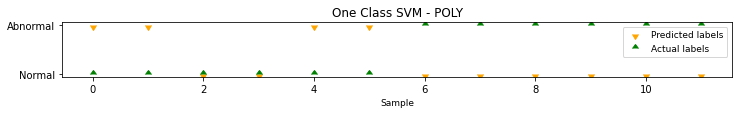

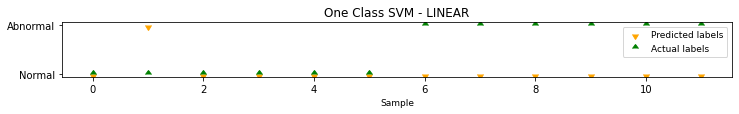

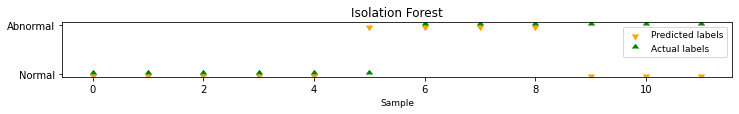

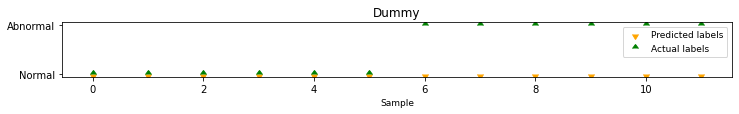

instance 15: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140720120102.csv


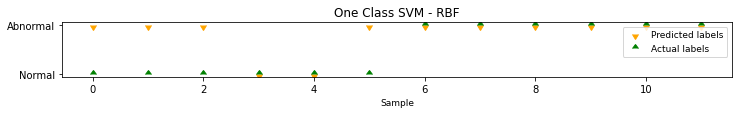

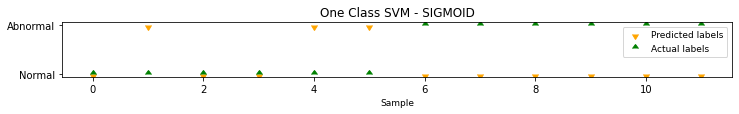

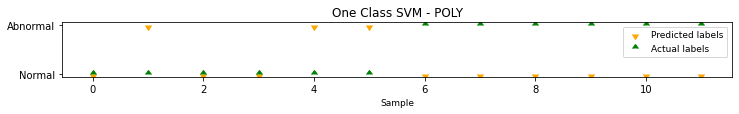

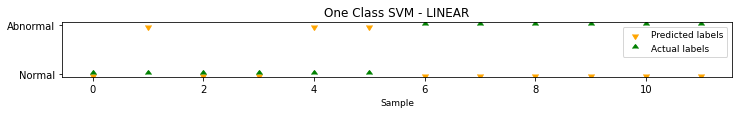

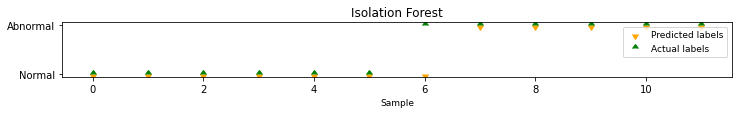

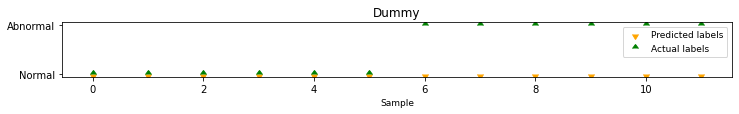

instance 16: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140726180015.csv
	skipped because normal_period_size is insufficient for training (900)
instance 17: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140824000118.csv


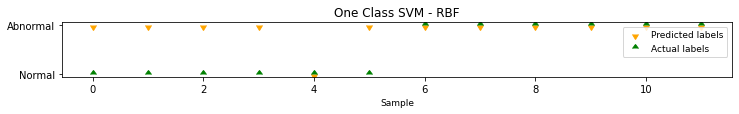

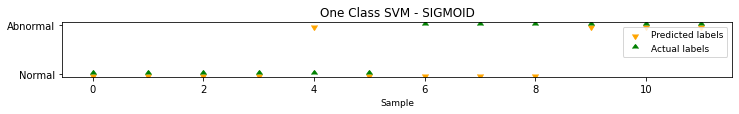

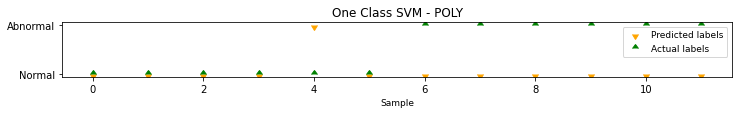

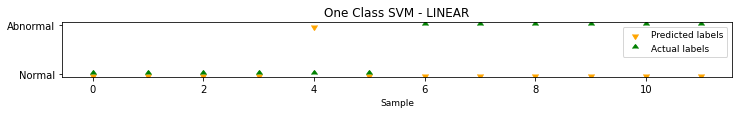

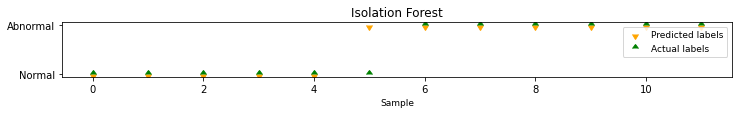

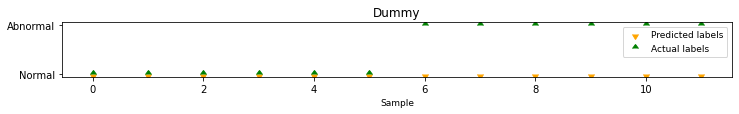

instance 18: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140916060300.csv


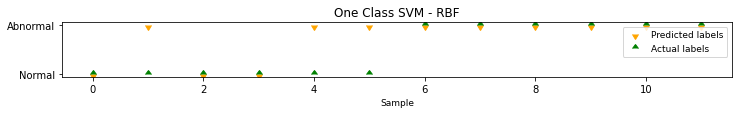

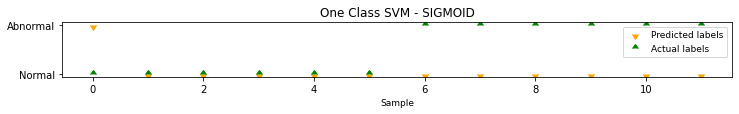

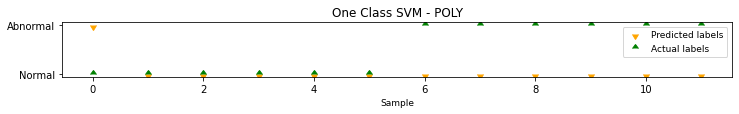

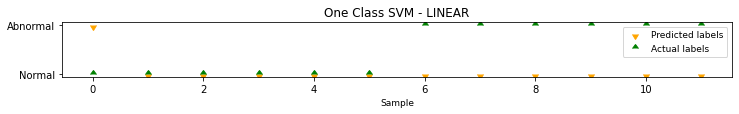

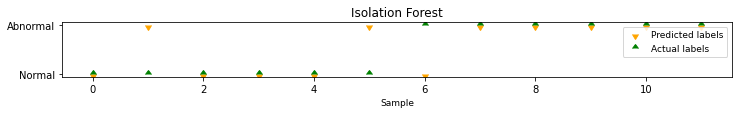

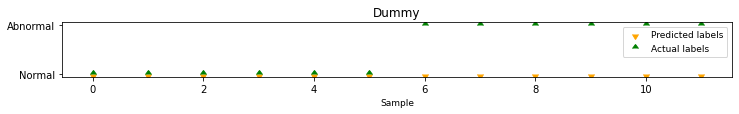

instance 19: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140921200031.csv
	skipped because normal_period_size is insufficient for training (695)
instance 20: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140928100056.csv


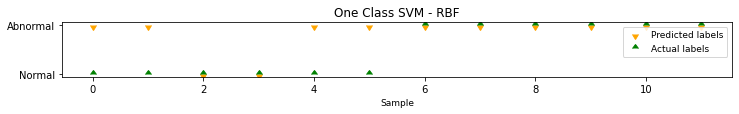

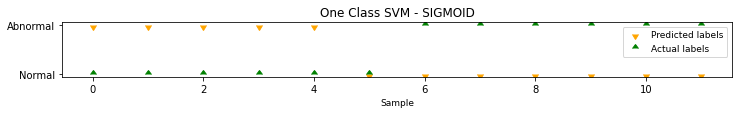

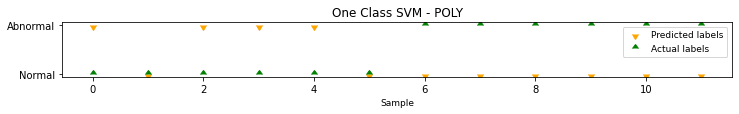

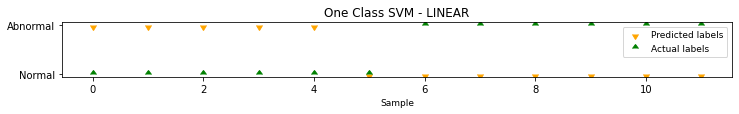

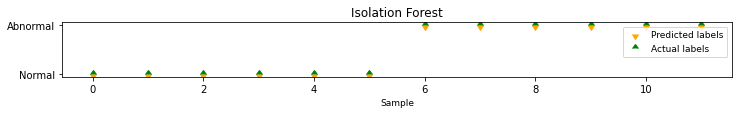

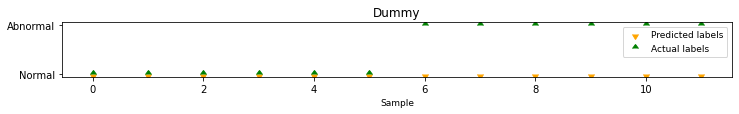

instance 21: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140929170028.csv
	skipped because normal_period_size is insufficient for training (975)
instance 22: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20140929220121.csv


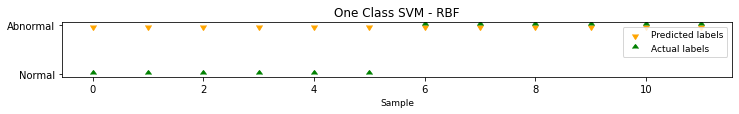

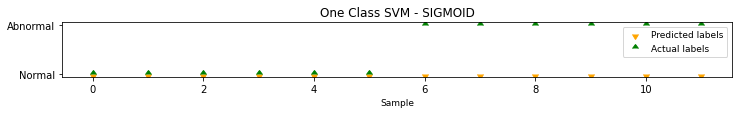

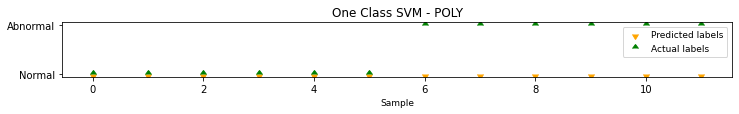

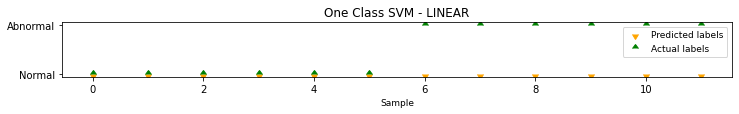

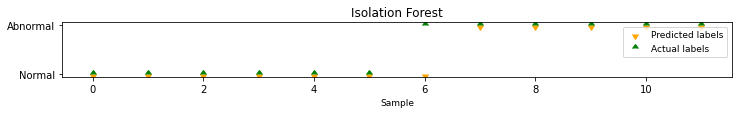

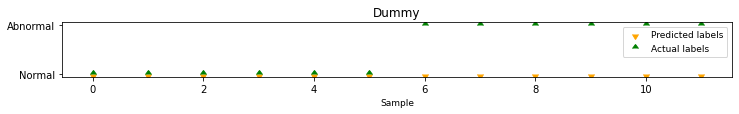

instance 23: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20141005170056.csv


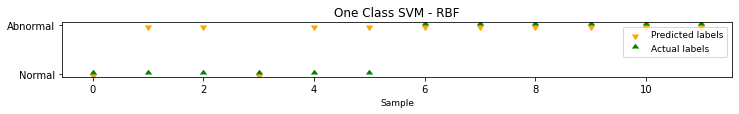

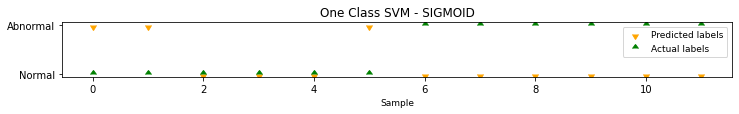

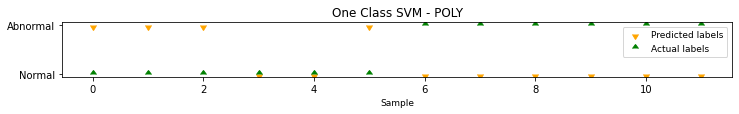

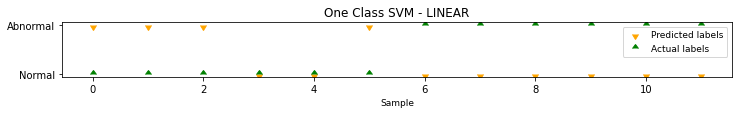

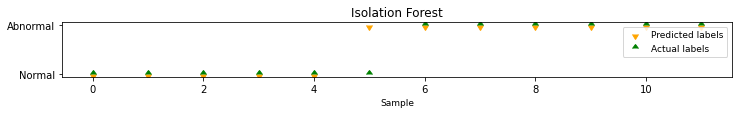

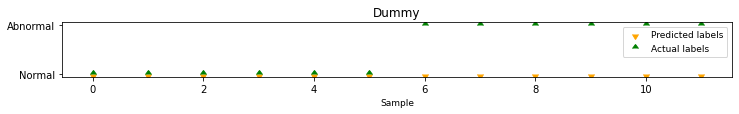

instance 24: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00011_20141006160121.csv


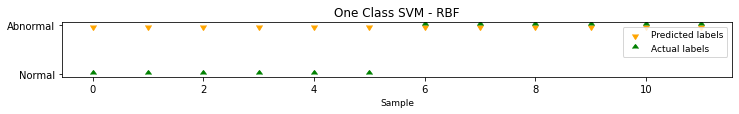

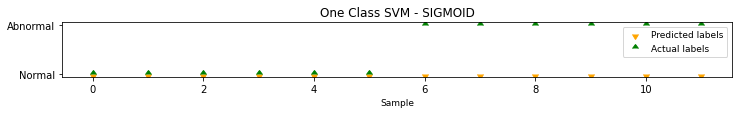

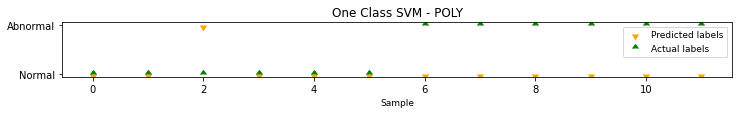

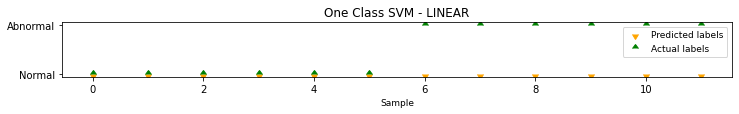

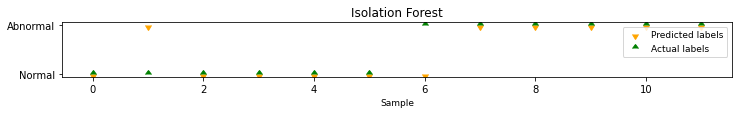

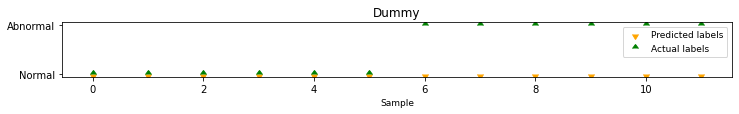

instance 25: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00012_20170320033022.csv
	skipped because normal_period_size is insufficient for training (773)
instance 26: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00012_20170320143144.csv


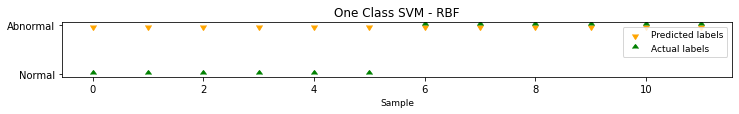

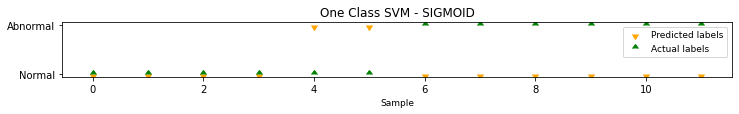

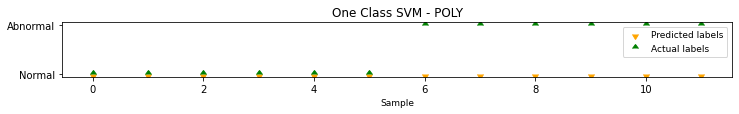

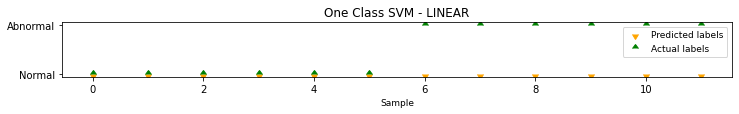

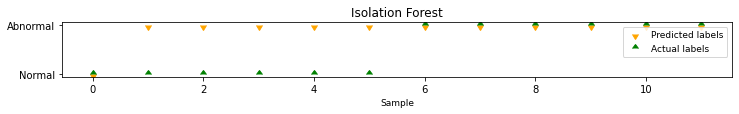

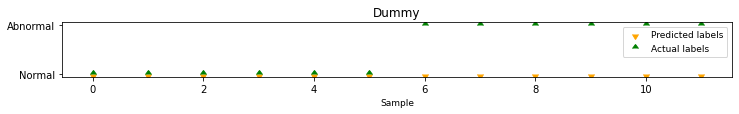

instance 27: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\2\WELL-00013_20170329020229.csv


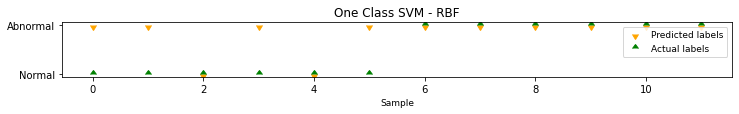

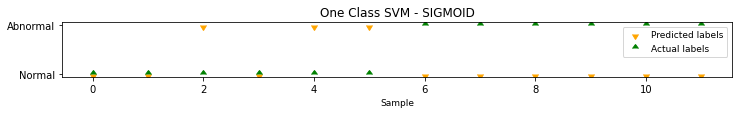

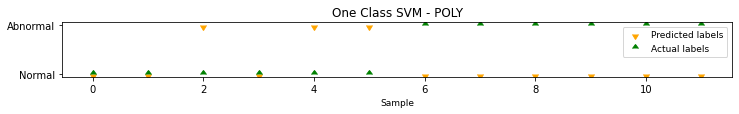

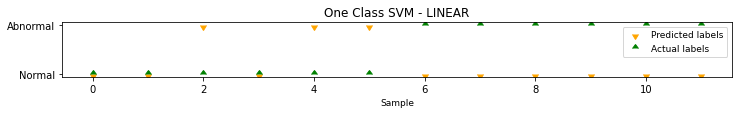

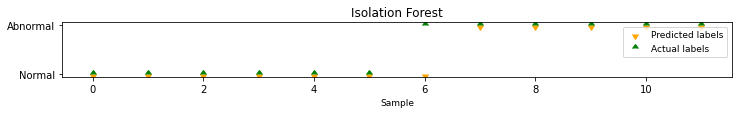

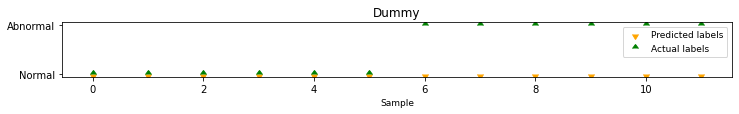

instance 28: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00015_20170620160349.csv


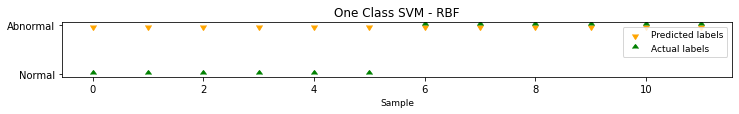

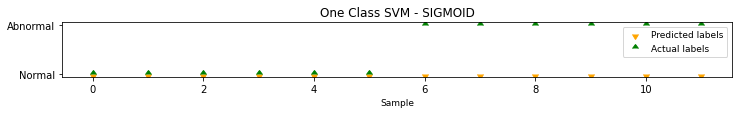

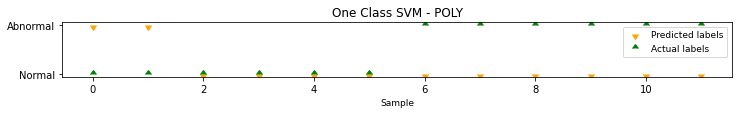

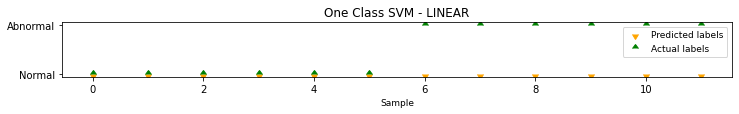

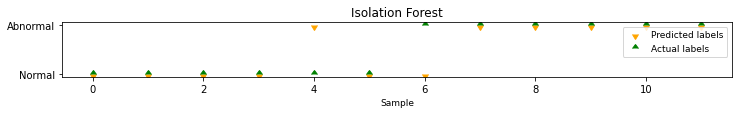

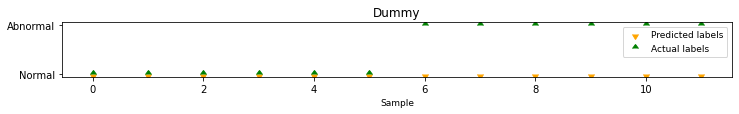

instance 29: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00015_20171013140047.csv


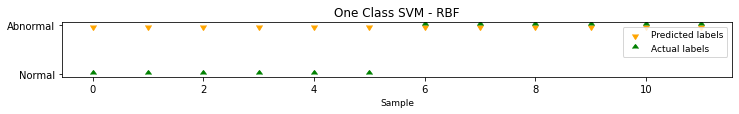

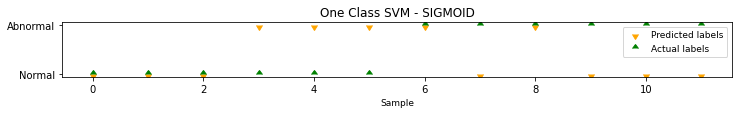

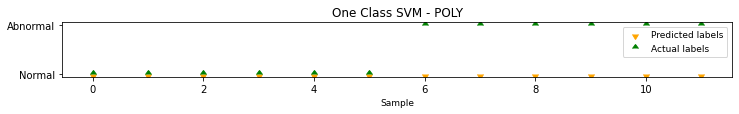

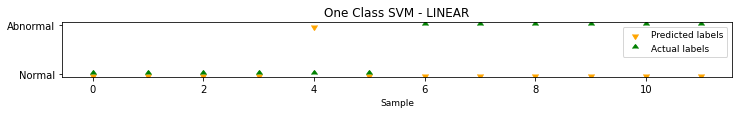

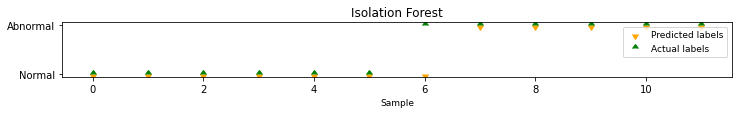

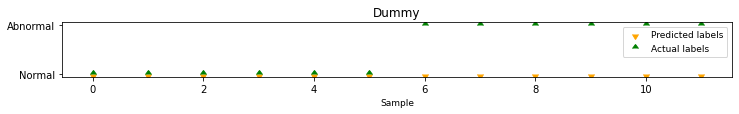

instance 30: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00016_20180405020345.csv
	skipped because normal_period_size is insufficient for training (1145)
instance 31: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00016_20180426142005.csv
	skipped because normal_period_size is insufficient for training (321)
instance 32: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00016_20180426145108.csv
	skipped because normal_period_size is insufficient for training (376)
instance 33: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00016_20180517222322.csv


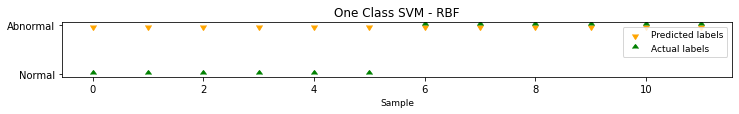

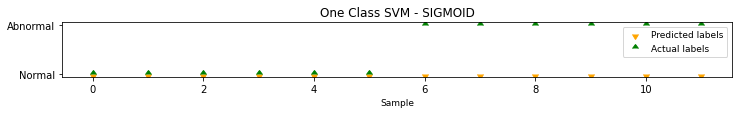

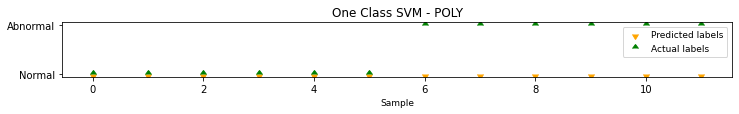

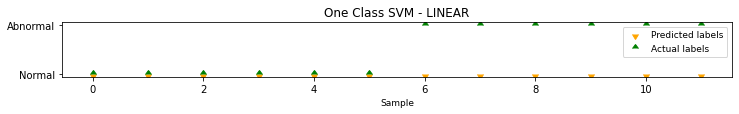

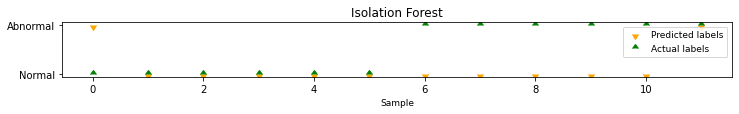

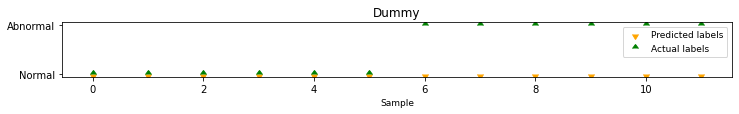

instance 34: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140314180000.csv
	skipped because normal_period_size is insufficient for training (0)
instance 35: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140317151743.csv


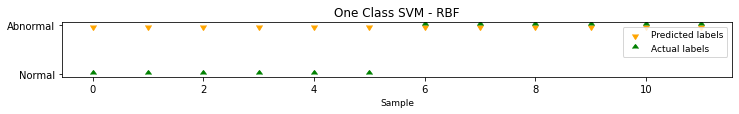

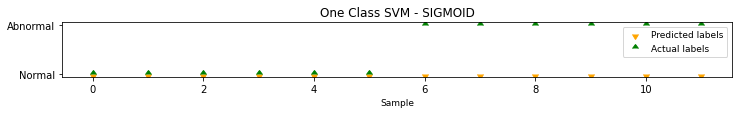

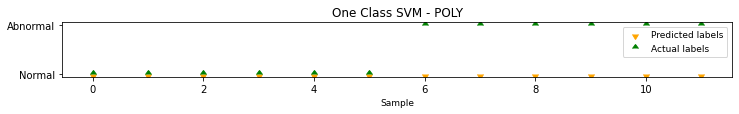

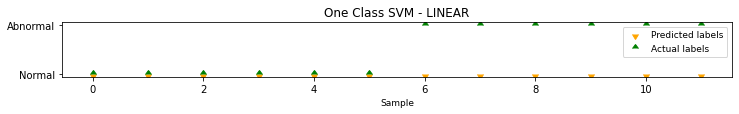

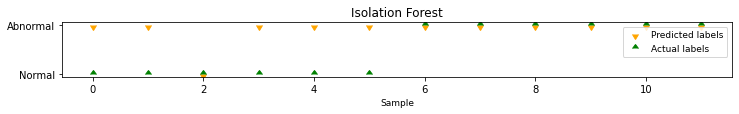

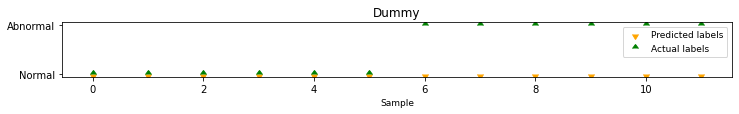

instance 36: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140318023141.csv


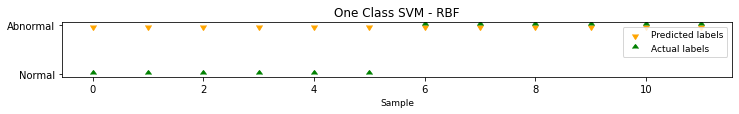

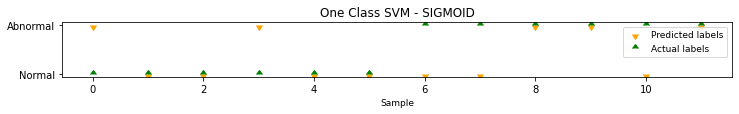

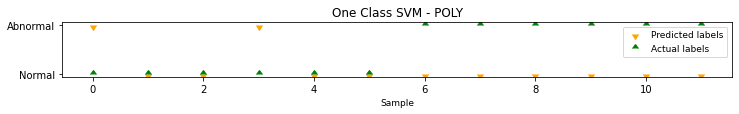

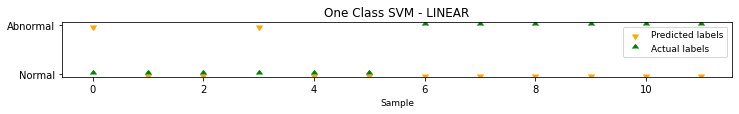

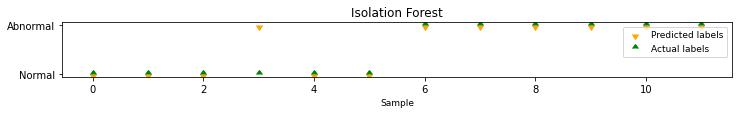

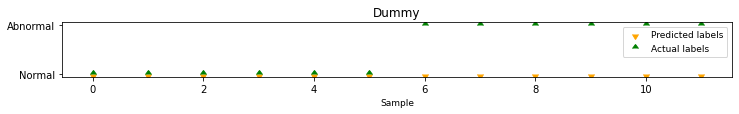

instance 37: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140318160220.csv


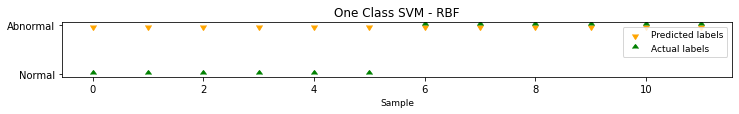

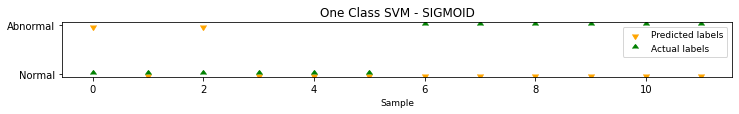

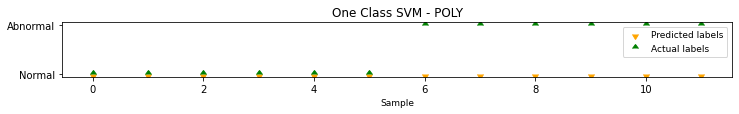

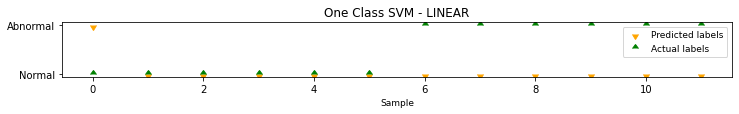

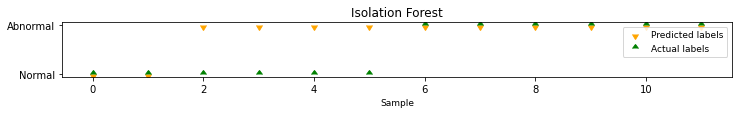

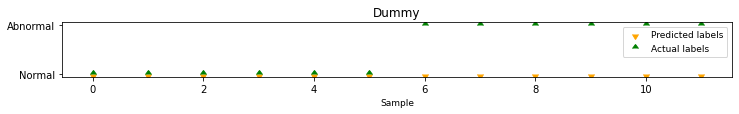

instance 38: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140319040453.csv


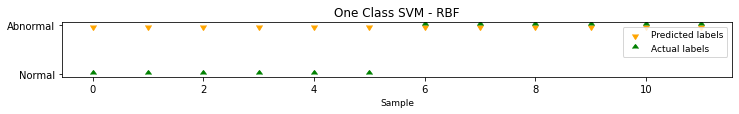

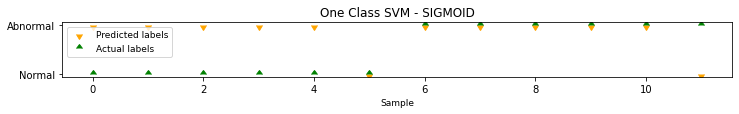

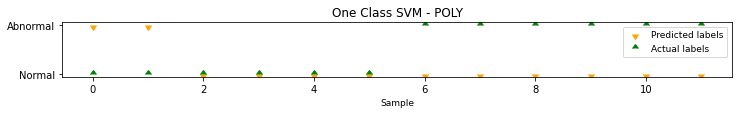

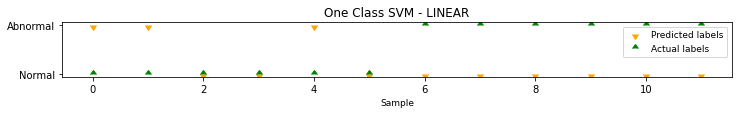

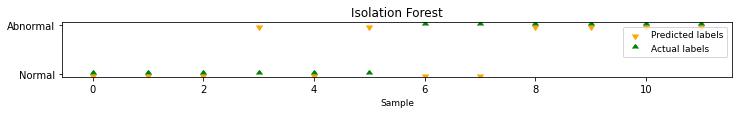

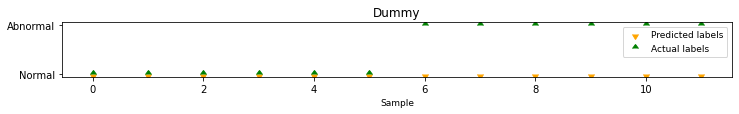

instance 39: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\5\WELL-00017_20140319141450.csv


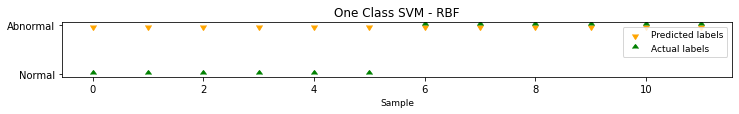

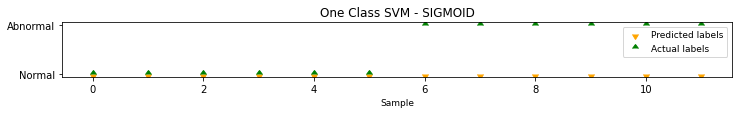

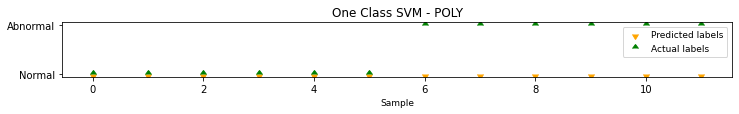

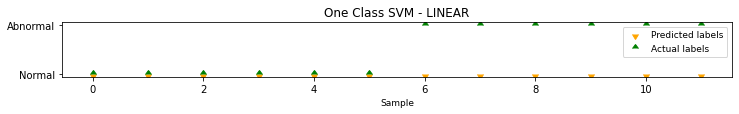

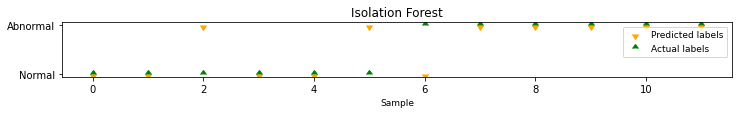

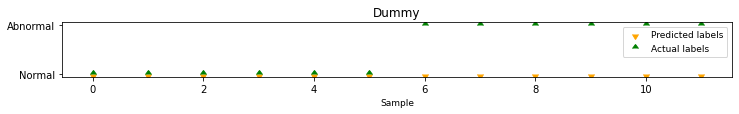

instance 40: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00002_20140212170333.csv


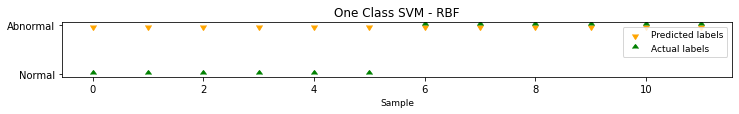

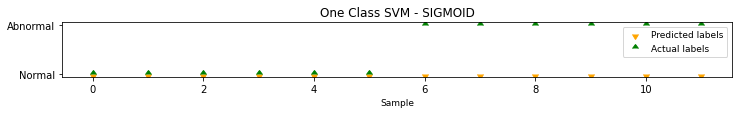

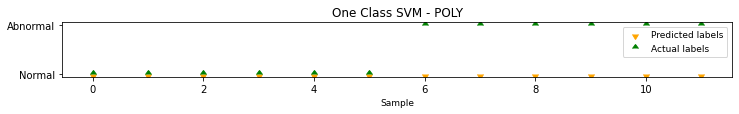

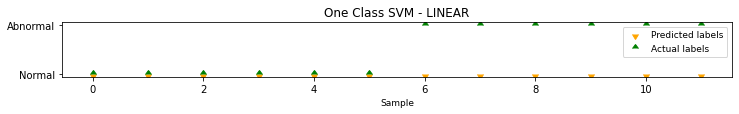

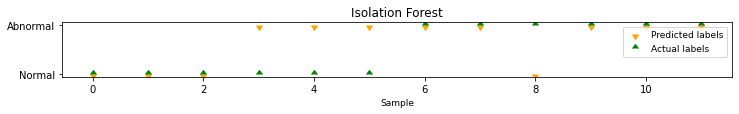

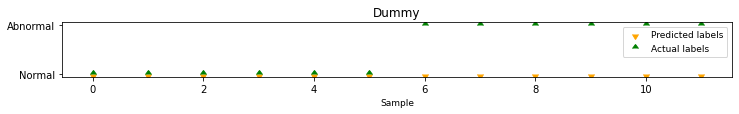

instance 41: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00002_20140301151700.csv


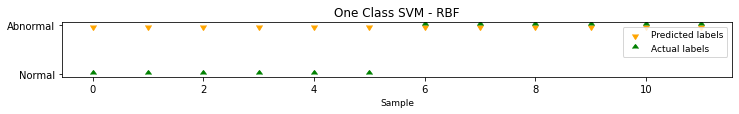

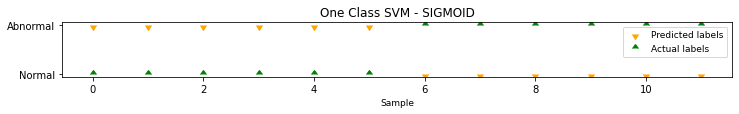

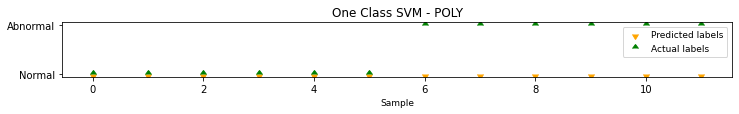

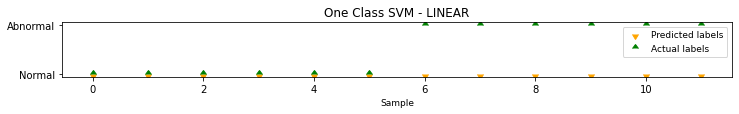

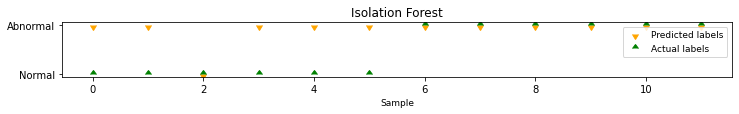

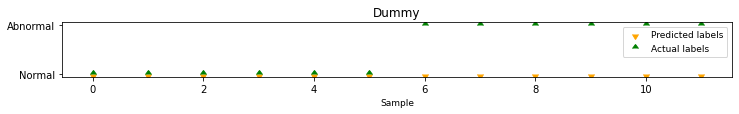

instance 42: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00002_20140325170304.csv


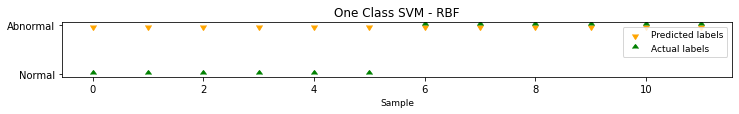

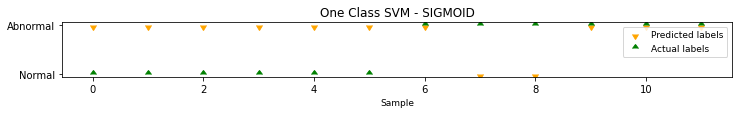

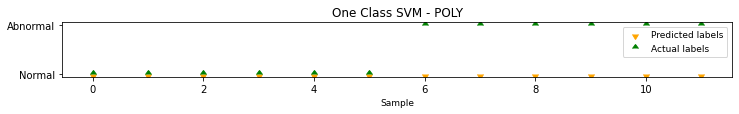

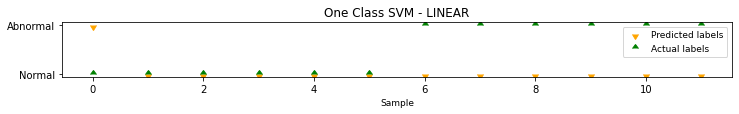

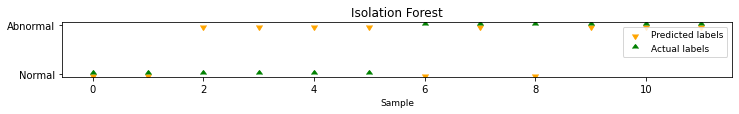

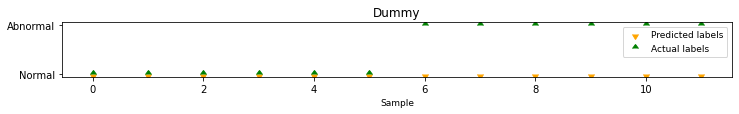

instance 43: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00004_20171031181509.csv


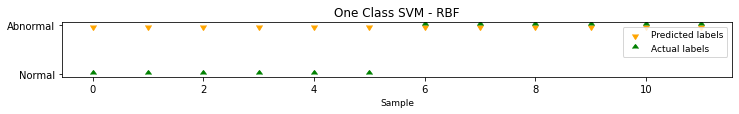

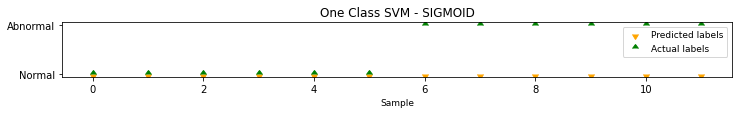

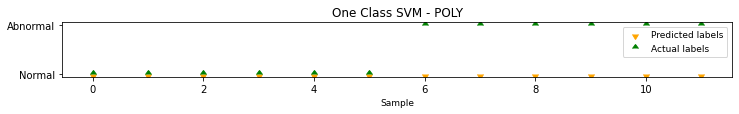

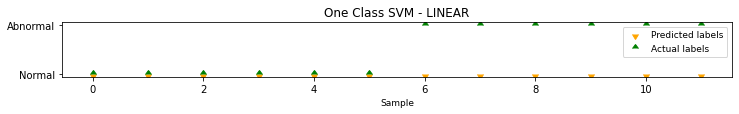

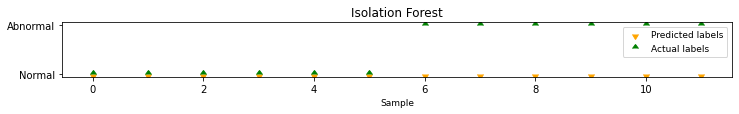

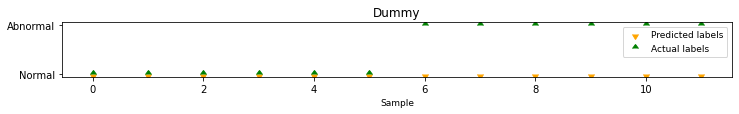

instance 44: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00004_20171031193025.csv
	skipped because normal_period_size is insufficient for training (414)
instance 45: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\6\WELL-00004_20171031200059.csv
	skipped because normal_period_size is insufficient for training (845)
instance 46: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\7\WELL-00001_20170226220309.csv


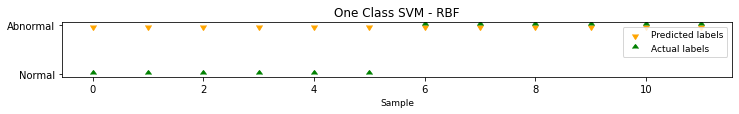

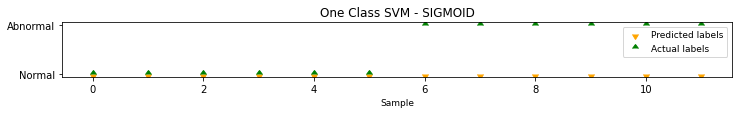

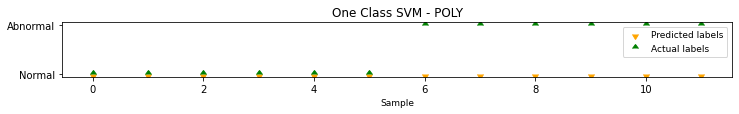

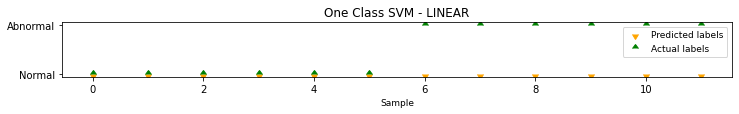

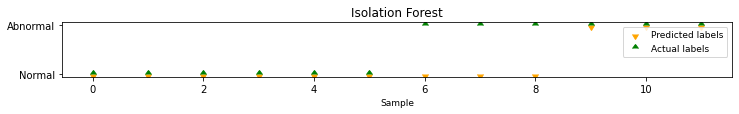

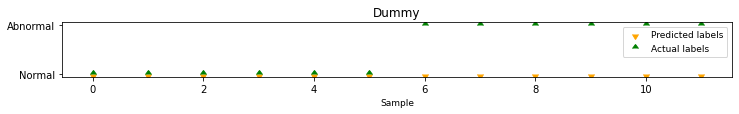

instance 47: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\7\WELL-00006_20180618110721.csv


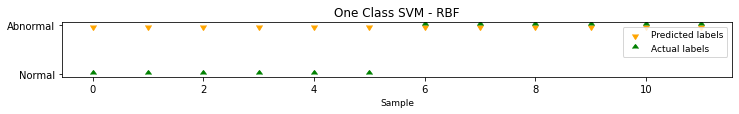

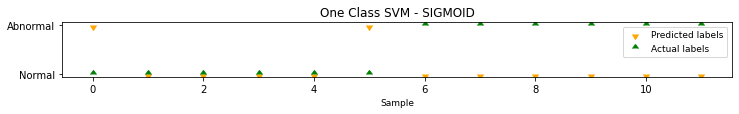

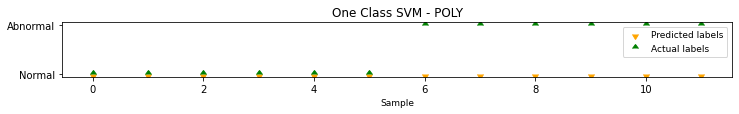

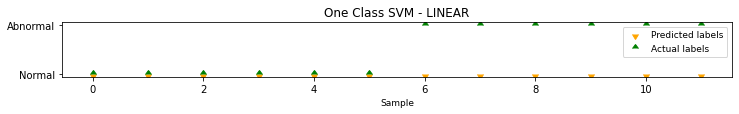

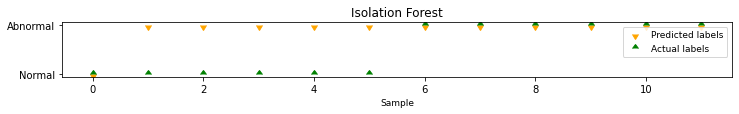

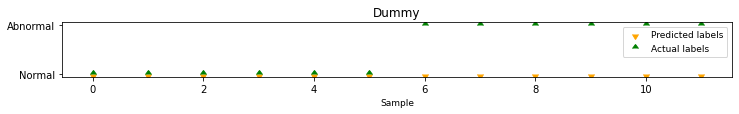

instance 48: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\7\WELL-00006_20180620181348.csv


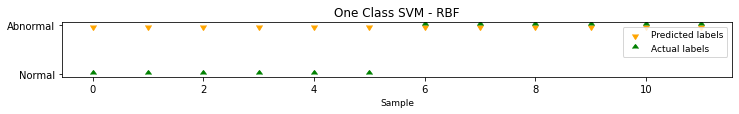

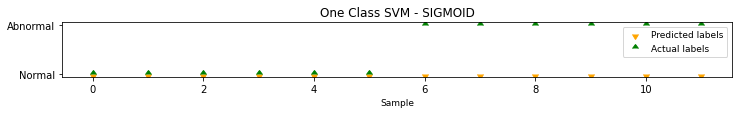

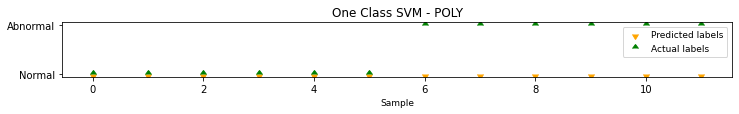

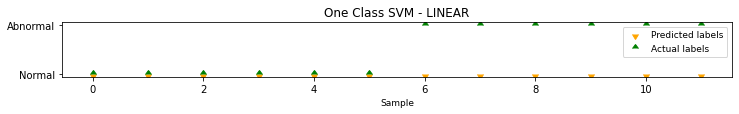

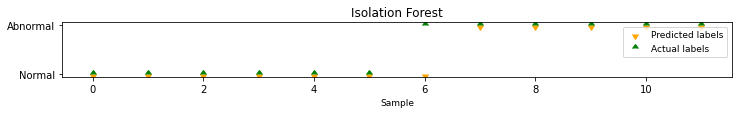

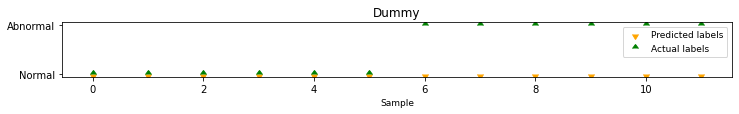

instance 49: C:\Users\leonardo.pinheiro\Downloads\PUC-Minas\16 - Projeto Integrado\3W-master\dataset\7\WELL-00018_20180611040207.csv
	skipped because normal_period_size is insufficient for training (0)


In [105]:
# For each real instance with any type of undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    print('instance {}: {}'.format(i+1, instance_path))
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print('\tskipped because normal_period_size is insufficient for training ({})'
              .format(normal_period_size))
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret

    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # We want binary classification: 1 for inliers (negative class = normal instance) and
    # -1 for outliers (positive class = instance with anomaly) (sklearn's requirement)
    y_test[y_test!=normal_class_code] = -1
    y_test[y_test==normal_class_code] = 1
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)
    
    # Trains, tests and calculates the scores
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

In [106]:
print('number of used instances: {}'.format(used_instances))
print('number of ignored instances: {}'.format(ignored_instances))

number of used instances: 34
number of ignored instances: 15


In [107]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'root_mean_square', 'maximum', 'absolute_maximum', 'minimum']


In [108]:
scores.to_csv(r'./demo_2_benchmark_anomaly_detection_scores.csv')

<h1>Métricas em Formato de Tabela</h1>
<br>
As tabelas a seguir apresentam as médias e desvios padrões, respectivamente, das métricas por classificador e ordenadas por medida F.

In [109]:
score_table = scores[["CLASSIFIER","F1","PRECISION","RECALL"]].groupby('CLASSIFIER').mean().sort_values(by=['F1'], ascending=False)
score_table

F1  PRECISION    RECALL
CLASSIFIER                                            
Isolation Forest         0.725490   0.725490  0.725490
One Class SVM - RBF      0.531863   0.531863  0.531863
Dummy                    0.500000   0.500000  0.500000
One Class SVM - POLY     0.426471   0.426471  0.426471
One Class SVM - LINEAR   0.421569   0.421569  0.421569
One Class SVM - SIGMOID  0.401961   0.401961  0.401961

In [110]:
score_table_std = scores[["CLASSIFIER","F1","PRECISION","RECALL"]].groupby('CLASSIFIER').std().sort_values(by=['F1'], ascending=True)
score_table_std

F1  PRECISION    RECALL
CLASSIFIER                                            
Dummy                    0.000000   0.000000  0.000000
One Class SVM - RBF      0.068087   0.068087  0.068087
One Class SVM - POLY     0.111925   0.111925  0.111925
One Class SVM - LINEAR   0.114116   0.114116  0.114116
One Class SVM - SIGMOID  0.139851   0.139851  0.139851
Isolation Forest         0.163517   0.163517  0.163517

<h1>Análise de Comparação Múltipla Não Paramétrica</h1>
<br>A saída a seguir (p_value < 5%) revela que a hipótese nula de que todos os classificadores têm o mesmo desempenho é falsa. Isso significa que pelo menos um deles tem, com alta probabilidade, valores médios de F1 diferentes dos demais.

In [111]:
import nonparametric_tests as stac

In [112]:
clfs_names = list(clfs.keys())
f1s = [scores.loc[scores['CLASSIFIER']==cn, 'F1'].values for cn in clfs_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 1.1102230246251565e-16


<br>Agora investigamos quais classificadores têm valores médios de medida F estatisticamente diferentes em comparação com o classificador DUMMY (sempre prevê a classe majoritária = normal). Os p_values e adj_p_values indicam que "Isolation Forest" e o "One Class SVM - SIGMOID" são os únicos que possuem desempenho estatisticamente melhor, com alta probabilidade, em relação ao classificador DUMMY (< 5%).

In [113]:
ret = holm_test_local(len(pivots), pivots, clfs_names, 'Dummy')
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print('{}: \n\tp_values: {}\n\tadj_p_values: {}'.format(comp[i], p_values[i], adj_p_values[i])) 

Dummy vs Isolation Forest: 
	p_values: 4.179582467012111e-06
	adj_p_values: 2.0897912335060553e-05
Dummy vs One Class SVM - SIGMOID: 
	p_values: 0.008659170490455725
	adj_p_values: 0.0346366819618229
Dummy vs One Class SVM - LINEAR: 
	p_values: 0.023285782558538415
	adj_p_values: 0.06985734767561524
Dummy vs One Class SVM - POLY: 
	p_values: 0.08009242468403466
	adj_p_values: 0.16018484936806932
Dummy vs One Class SVM - RBF: 
	p_values: 0.6268588388388538
	adj_p_values: 0.6268588388388538


<h1>Métricas em Boxplots</h1>
<br>
Os boxplots apresentados a seguir são ordenados por valores médios da medida F dos classificadores considerados

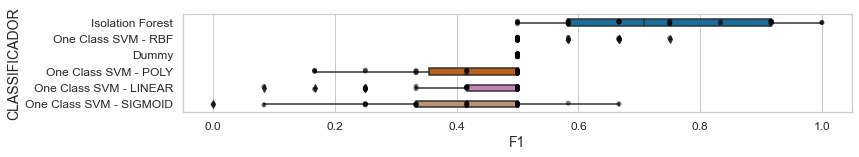

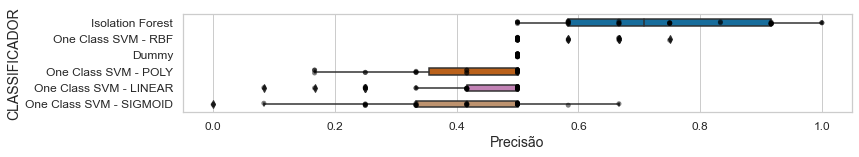

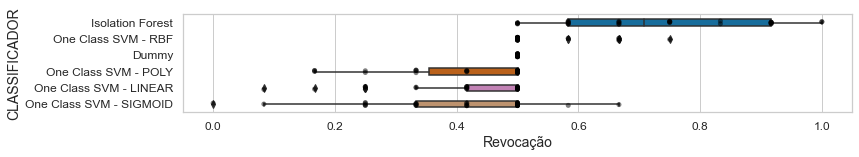

In [114]:
sns.set(font_scale=0.75, style="whitegrid")
i = 0
for score in scores.columns.drop(['CLASSIFIER']):
    if i < 3:
        plt.figure(figsize=(12,1.8))
        if i == 0: xlabel = "F1"
        if i == 1: xlabel = "Precisão"
        if i == 2: xlabel = "Revocação"
        bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4, 
                          palette='colorblind', order=list(score_table.index));
        bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o', 
                            alpha=0.5, color='black', order=list(score_table.index))
        bplot.set_xlabel(xlabel,fontsize=14)
        bplot.set_ylabel("CLASSIFICADOR",fontsize=14)
        bplot.tick_params(labelsize=12)
    plt.savefig("box_plot_benchmark_2"+bplot.get_xlabel()+".png", dpi=600, bbox_inches='tight')
#    plt.savefig("box_plot_benchmark_2"+bplot.get_xlabel()+".png".format(y=y))
    i=i+1

<h1>Conclusões</h1>
<br>Diante dos resultados apresentados para a análise 1 acima, podemos afirmar que o classificador "IsolationForest" apresenta melhor desempenho em termos de médias das métricas F1, PRECISION e RECALL, mas não em termos de desvio padrão dessas métricas.

Após uma análise de comparação múltipla não paramétrica, verificamos que o classificador "IsolationForest" produz valor médio F1 estatisticamente diferente em relação ao classificador DUMMY.

Portanto, está provado que o algoritmo de aprendizado de máquina pode ser usado para detectar anomalias em poços de petróleo.

<h1>Análise 2</h1>

<br>Verificar o impacto do uso de instâncias simuladas e desenhadas à mão na detecção de anomalias raras em instâncias reais

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

In [116]:
random_state = 1
n_jobs = None
clfs2 = {'Decision Tree':     DecisionTreeClassifier(random_state=random_state),
        'AdaBoost':          AdaBoostClassifier(random_state=random_state),
        'Random Forest':     RandomForestClassifier(n_jobs=n_jobs, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class']
normal_class_code = 0
undesirable_event_code = 1      # Undesirable event of interest
downsample_rate = 60            # Adjusts frequency of sampling to the dynamics 
                                # of the undesirable event of interest
sample_size_default = 60        # In observations (after downsample)
sample_size_normal_period = 5   # In observations (after downsample)
max_samples_per_period = 15     # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
max_nan_percent = 0.1           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

In [117]:
def get_instances_with_undesirable_event(data_path, undesirable_event_code,
                                         real, simulated, drawn):
    instances = pd.DataFrame(class_and_file_generator(data_path,
                                                      real=real,
                                                      simulated=simulated, 
                                                      drawn=drawn),
                             columns=['class_code', 'instance_path'])
    idx = instances['class_code'] == undesirable_event_code
    return instances.loc[idx].reset_index(drop=True)

In [118]:
def load_and_downsample_instances(instances, downsample_rate, source, instance_id):
    df_instances = pd.DataFrame()
    for _, row in instances.iterrows():
        _, instance_path = row
        df = load_instance(instance_path).iloc[::downsample_rate, :]
        df['instance_id'] = instance_id
        instance_id += 1
        df_instances = pd.concat([df_instances, df])
    df_instances['source'] = source
    return df_instances.reset_index(drop=True), instance_id

In [119]:
def loio(n):
    all_i = range(n)
    for i in all_i:
        test_i = set([i])
        train_i = set(all_i)-test_i
        yield train_i, test_i

In [120]:
def extract_samples_train(df, df_samples_train, df_y_train, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)

    # Extracts samples from the normal period (if it exists)
    #
    if normal_class_code in set_ols:
        # Gets indexes (first and last) without overlap with other periods
        f_idx = ols.index(normal_class_code)
        l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_normal_period
        if (max_samples) > 0:  
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_normal_period
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = l_idx-sample_size_normal_period+1-(num_samples-1-idx)*step
                l_idx_c = f_idx_c+sample_size_normal_period
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':normal_class_code},
                                               ignore_index=True)
                sample_id += 1

    # Extracts samples from the transient period (if it exists)
    #
    transient_code = undesirable_event_code + 100
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
    
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0:
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = np.inf
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':transient_code},
                                               ignore_index=True)
                sample_id += 1
    
    # Extracts samples from the in-regime period (if it exists)
    #
    if undesirable_event_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(undesirable_event_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(undesirable_event_code)
        if l_idx+(sample_size_default-1) < len(ols)-1:
            l_idx = l_idx+(sample_size_default-1) 
        else:
            l_idx = len(ols)-1
  
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0 :
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_default
            step = min(step_wanted, step_max)
    
            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':undesirable_event_code}, 
                                               ignore_index=True)
                sample_id += 1
    
    return df_samples_train, df_y_train, sample_id 

In [121]:
def extract_samples_test(df, df_samples_test, df_y_test, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels
    ols = list(df['class'].fillna(method='ffill'))    
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)    
    
    # Extracts samples from the instance as a whole
    f_idx = 0
    l_idx = len(df)-1  

    # Defines the proper step and extracts samples
    max_samples = l_idx-f_idx+1-sample_size_default
    if (max_samples) > 0:
        num_samples = min(3*max_samples_per_period, max_samples)
        if num_samples == max_samples:
            step_max = 1 
        else:
            step_max = (max_samples-1) // (3*max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)

        # Extracts samples
        for idx in range(num_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size_default
            f_idxs.append(f_idx_c)
            l_idxs.append(l_idx_c)                
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            df_y_test = df_y_test.append({'instance':instance, 'y':ols[l_idx_c]},
                                         ignore_index=True)
            sample_id += 1
            
    return df_samples_test, df_y_test, sample_id

In [122]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs, scenario):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            clf.fit(X_train, y_train)
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(y_pred, marker=11, color='orange', linestyle='')
            plt.plot(y_test, marker=10, color='green', linestyle='')            
            ax.grid(False)
            ax.set_yticks([0, undesirable_event_code])
            ax.set_yticklabels([normal_class_code, undesirable_event_code])
            ax.set_title(clf_name)
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()
                  
            # Calculates the considered scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
            p, r, f1, _ = ret
            scores = scores.append({'SCENARIO': scenario,
                                    'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAINING[s]': t_train, 
                                    'TESTING[s]': t_test}, ignore_index=True)
                                      
        except Exception as e:
            print('error in training/testing classifier: {}'.format(e))
            scores = scores.append({'SCENARIO': scenario,
                                    'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAINING[s]': np.nan, 
                                    'TESTING[s]': np.nan}, ignore_index=True)
            
    return scores

In [123]:
real_instances = get_instances_with_undesirable_event(data_path, 
                                                      undesirable_event_code,
                                                      real=True,
                                                      simulated=False, 
                                                      drawn=False)
simul_instances = get_instances_with_undesirable_event(data_path,
                                                       undesirable_event_code,
                                                       real=False,
                                                       simulated=True, 
                                                       drawn=False)
drawn_instances = get_instances_with_undesirable_event(data_path,
                                                       undesirable_event_code,
                                                       real=False,
                                                       simulated=False, 
                                                       drawn=True)

In [124]:
instance_id = 0
df_real_instances, instance_id  = load_and_downsample_instances(real_instances,
                                                                downsample_rate,
                                                                'real', 
                                                                instance_id)
df_simul_instances, instance_id = load_and_downsample_instances(simul_instances, 
                                                                downsample_rate,
                                                                'simulated', 
                                                                instance_id)
df_drawn_instances, instance_id = load_and_downsample_instances(drawn_instances,
                                                                downsample_rate,
                                                                'drawn', 
                                                                instance_id)
df_instances = pd.concat([df_real_instances, df_simul_instances, df_drawn_instances])

current testing instance: 0
	scenario 1 -> training with real {1, 2, 3, 4} +  instances


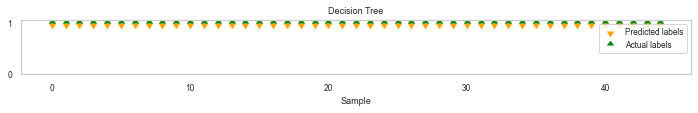

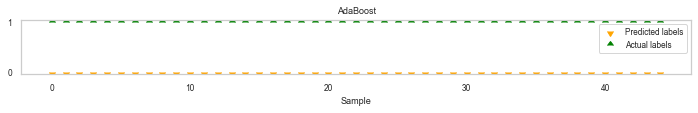

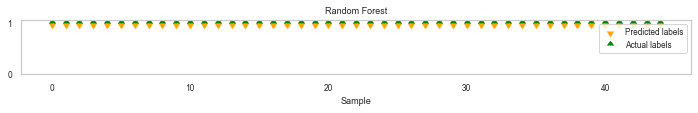

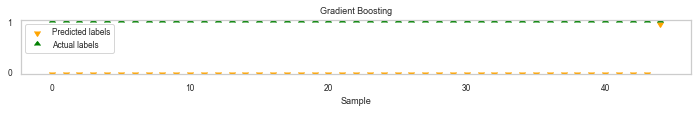

	scenario 2 -> training with simulated instances


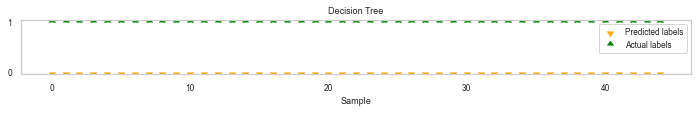

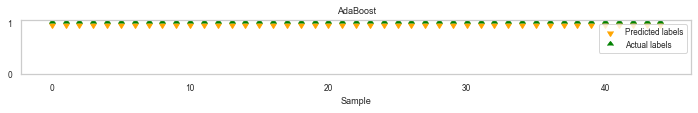

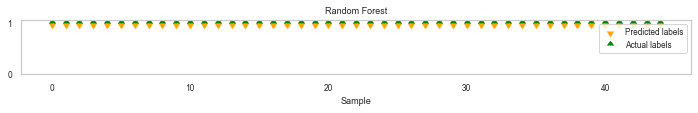

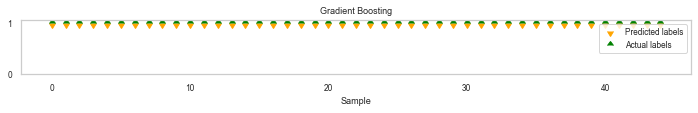

	scenario 3 -> training with drawn instances


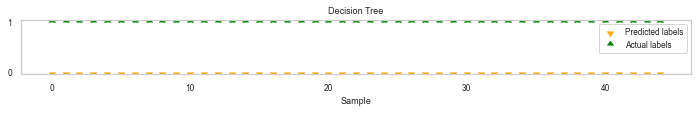

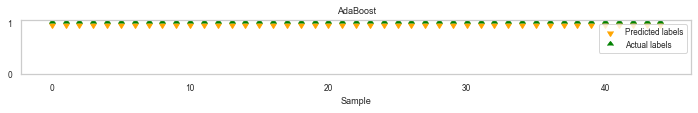

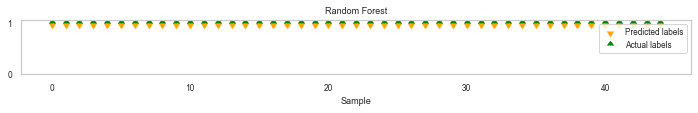

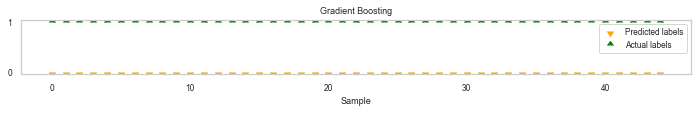

	scenario 4 -> training with real {1, 2, 3, 4} + simulated instances


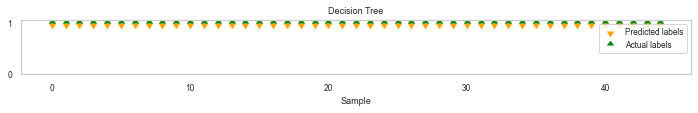

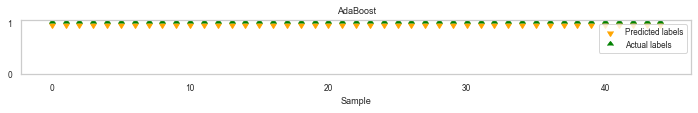

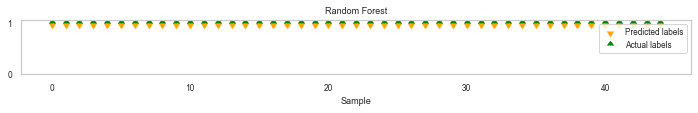

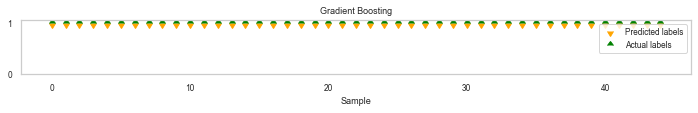

	scenario 5 -> training with real {1, 2, 3, 4} + drawn instances


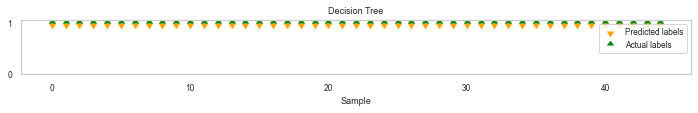

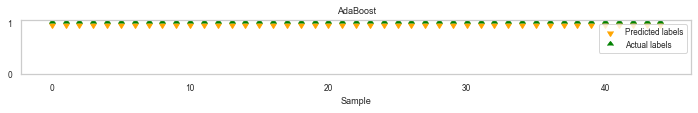

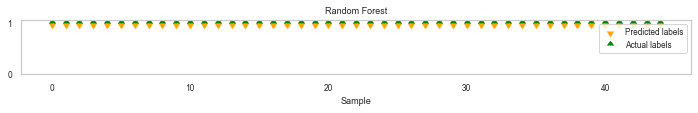

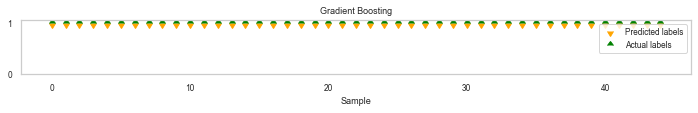

	scenario 6 -> training with simulated + drawn instances


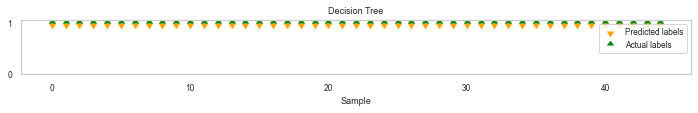

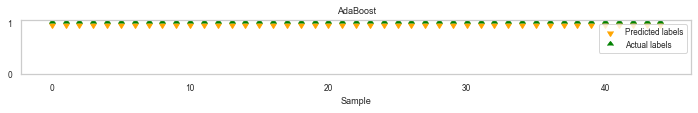

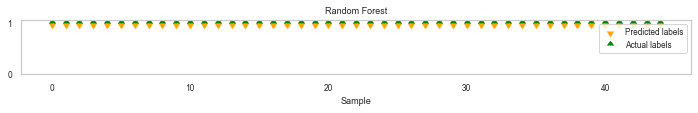

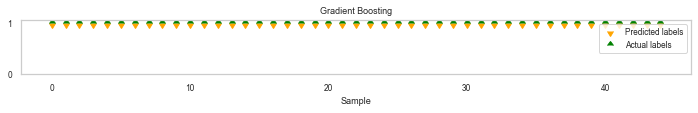

	scenario 7 -> training with real {1, 2, 3, 4} + simulated + drawn instances


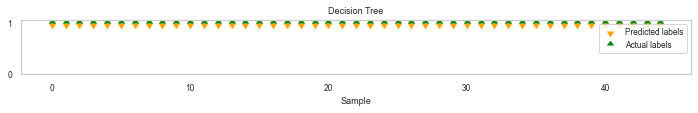

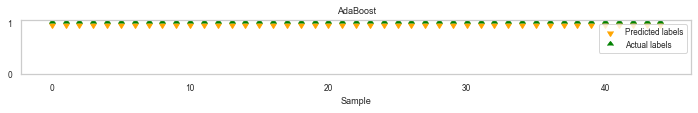

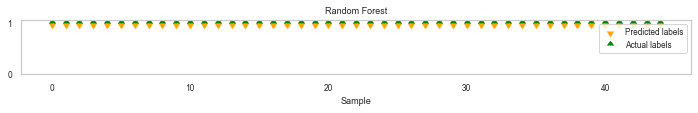

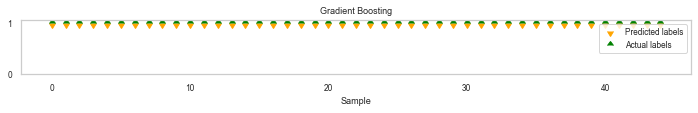

current testing instance: 1
	scenario 1 -> training with real {0, 2, 3, 4} +  instances


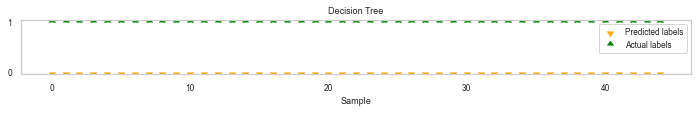

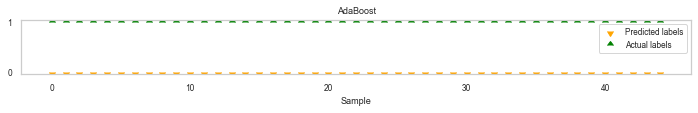

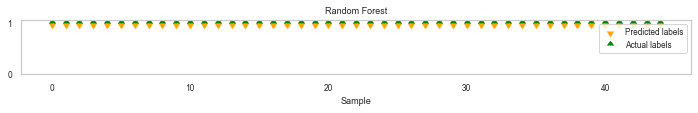

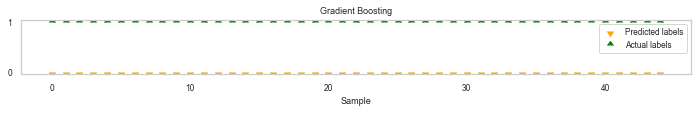

	scenario 2 -> training with simulated instances


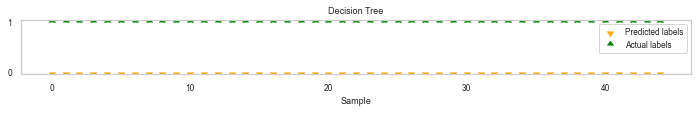

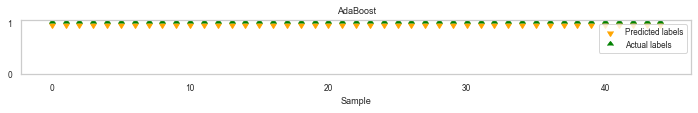

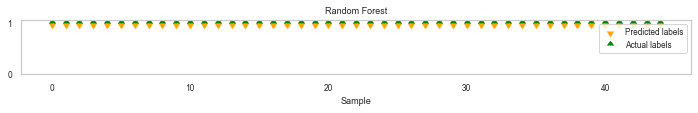

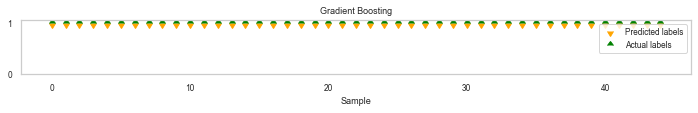

	scenario 3 -> training with drawn instances


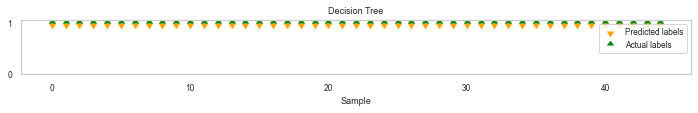

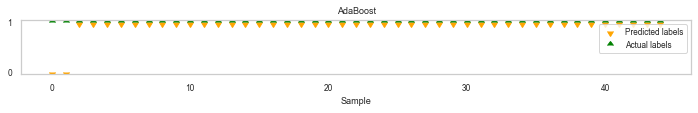

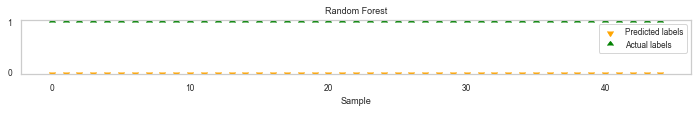

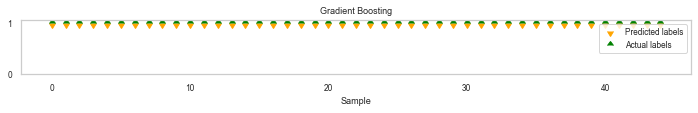

	scenario 4 -> training with real {0, 2, 3, 4} + simulated instances


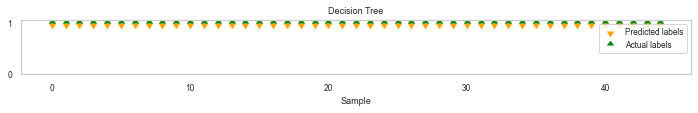

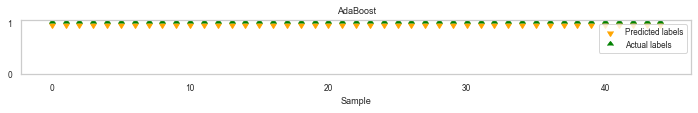

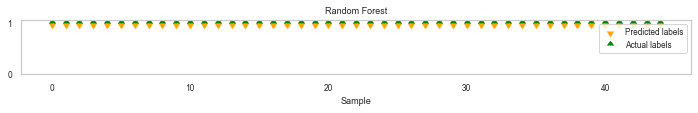

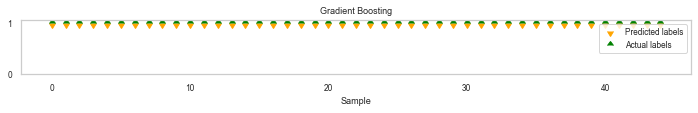

	scenario 5 -> training with real {0, 2, 3, 4} + drawn instances


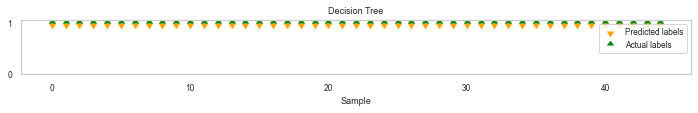

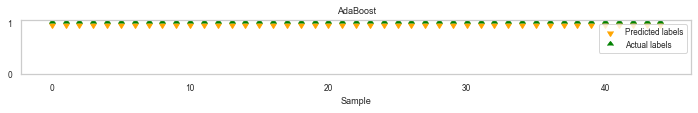

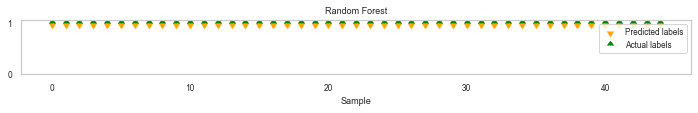

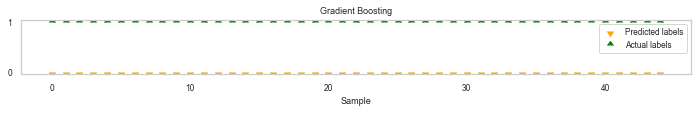

	scenario 6 -> training with simulated + drawn instances


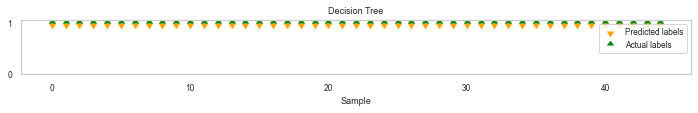

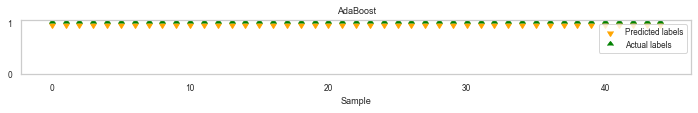

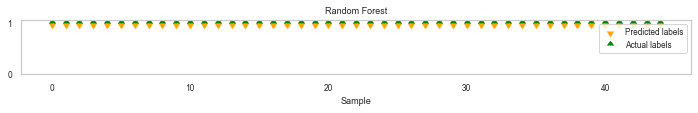

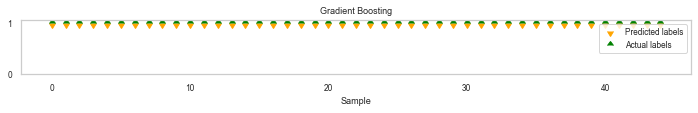

	scenario 7 -> training with real {0, 2, 3, 4} + simulated + drawn instances


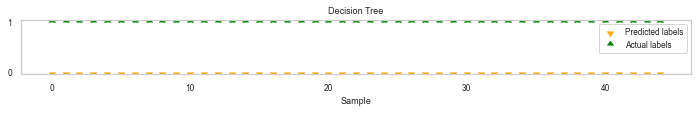

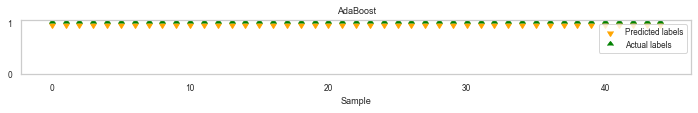

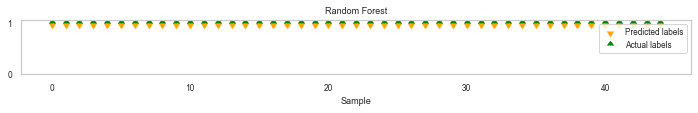

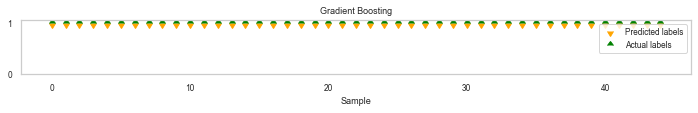

current testing instance: 2
	scenario 1 -> training with real {0, 1, 3, 4} +  instances


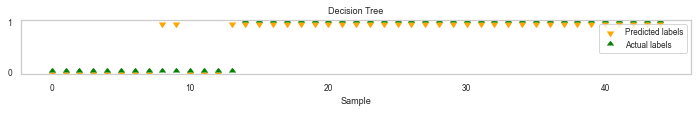

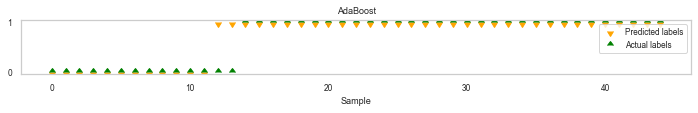

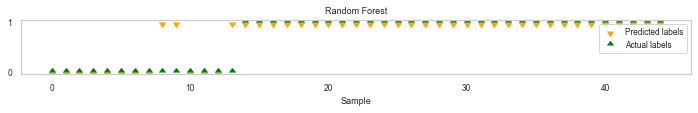

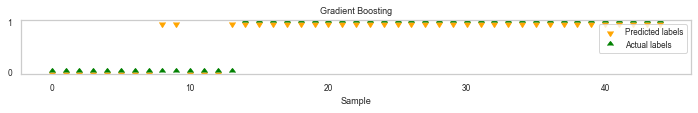

	scenario 2 -> training with simulated instances


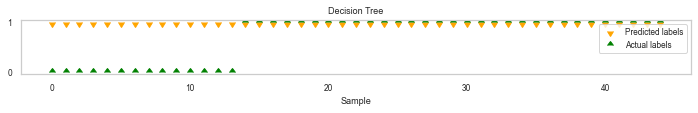

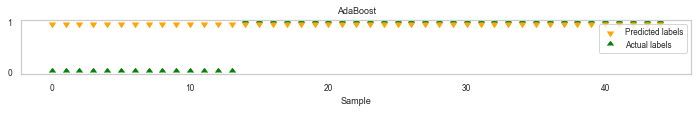

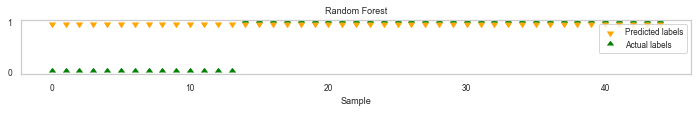

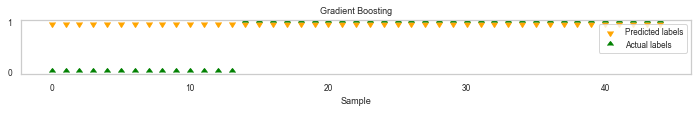

	scenario 3 -> training with drawn instances


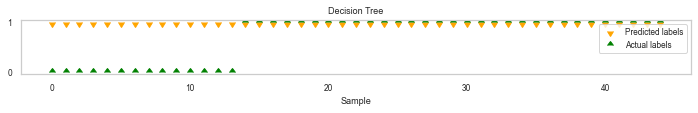

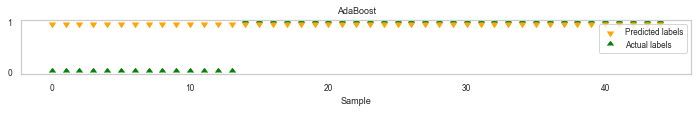

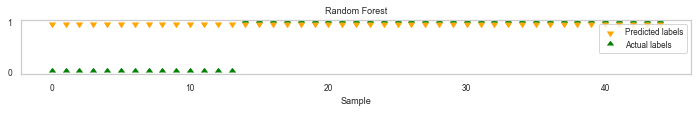

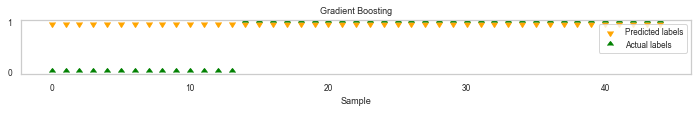

	scenario 4 -> training with real {0, 1, 3, 4} + simulated instances


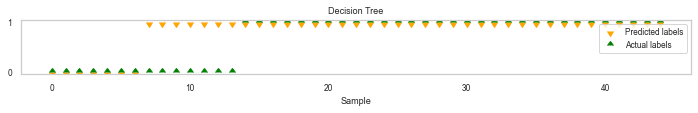

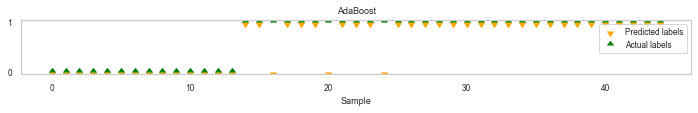

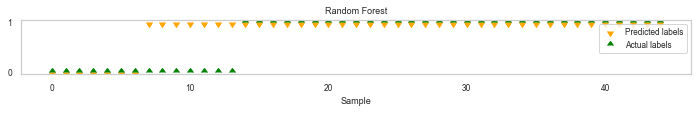

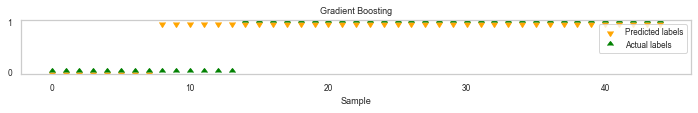

	scenario 5 -> training with real {0, 1, 3, 4} + drawn instances


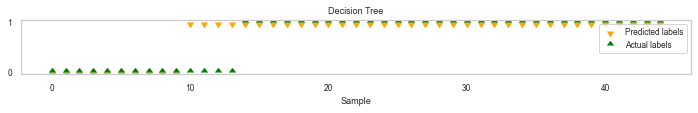

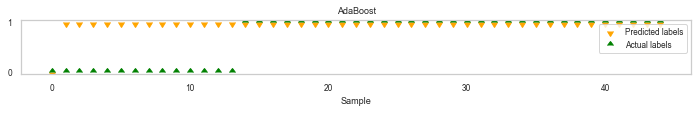

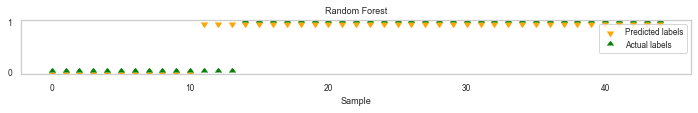

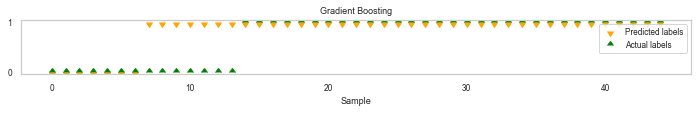

	scenario 6 -> training with simulated + drawn instances


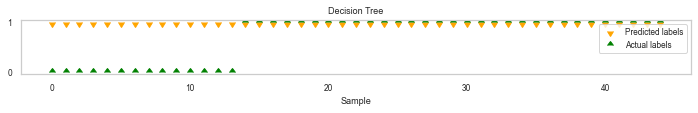

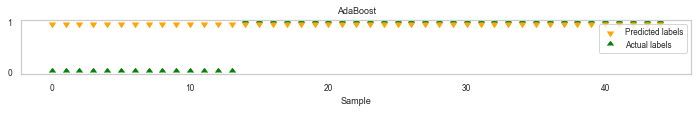

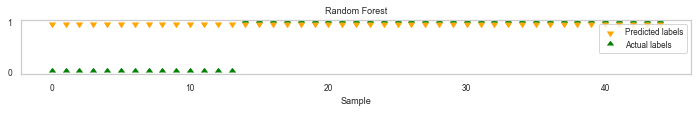

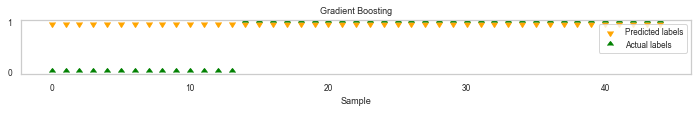

	scenario 7 -> training with real {0, 1, 3, 4} + simulated + drawn instances


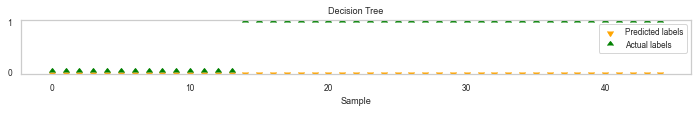

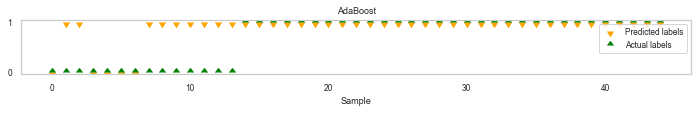

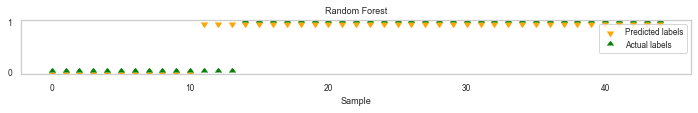

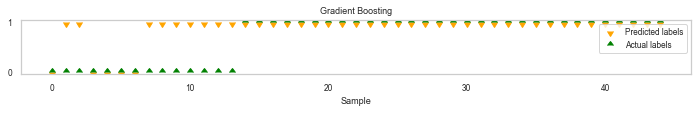

current testing instance: 3
	scenario 1 -> training with real {0, 1, 2, 4} +  instances


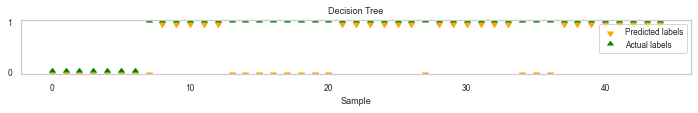

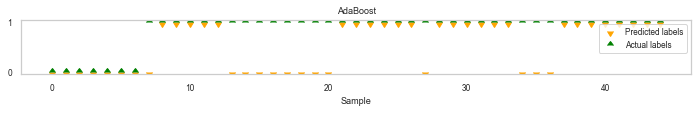

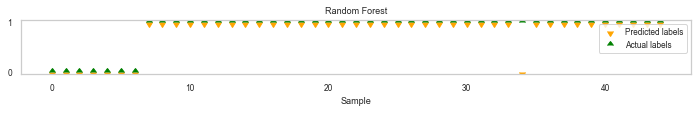

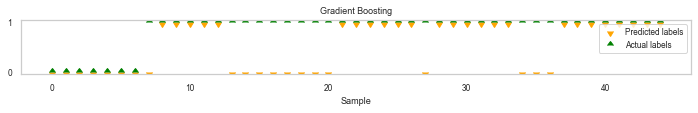

	scenario 2 -> training with simulated instances


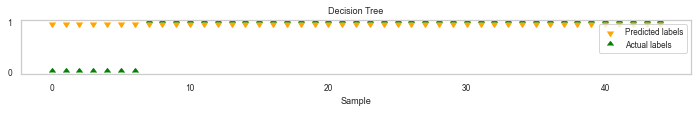

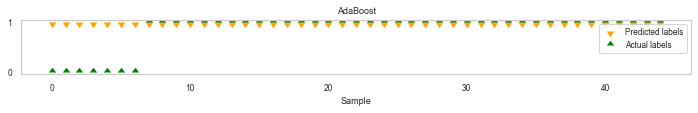

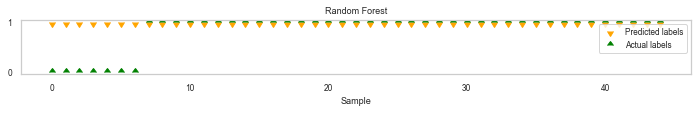

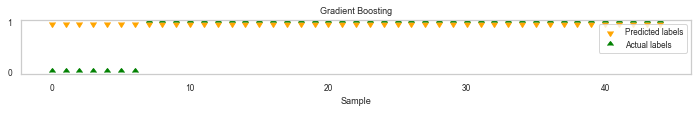

	scenario 3 -> training with drawn instances


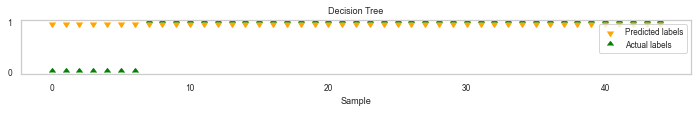

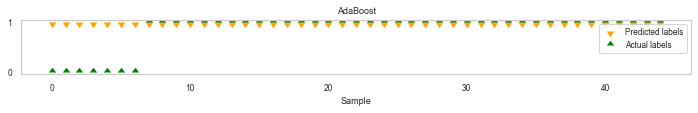

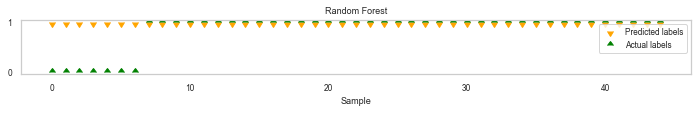

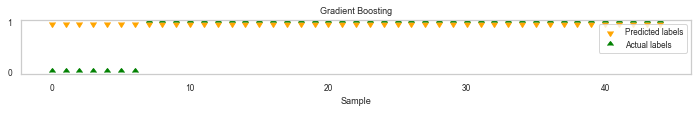

	scenario 4 -> training with real {0, 1, 2, 4} + simulated instances


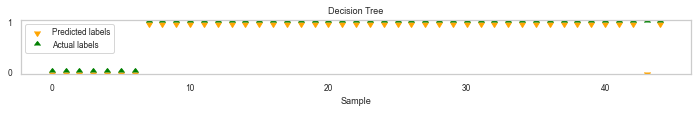

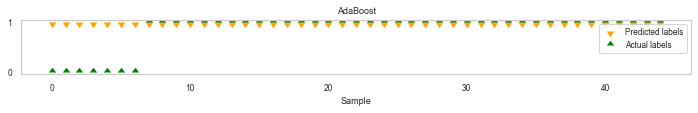

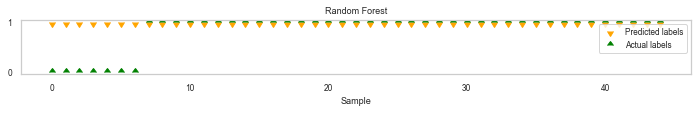

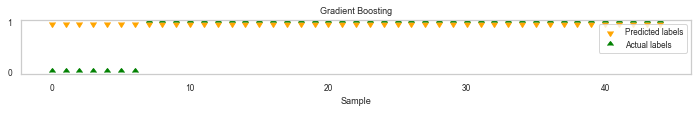

	scenario 5 -> training with real {0, 1, 2, 4} + drawn instances


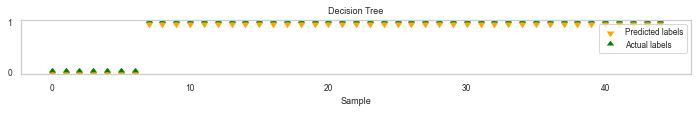

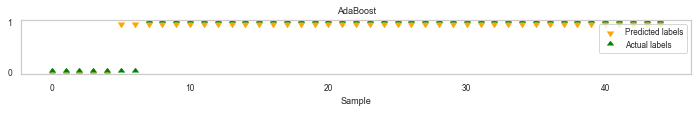

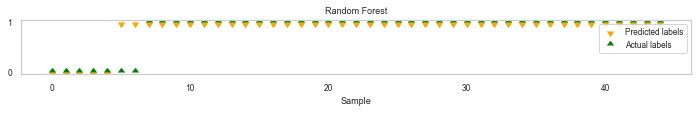

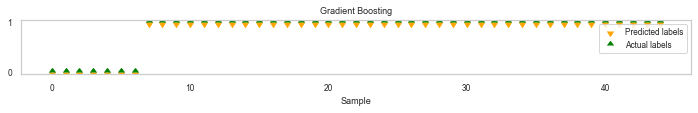

	scenario 6 -> training with simulated + drawn instances


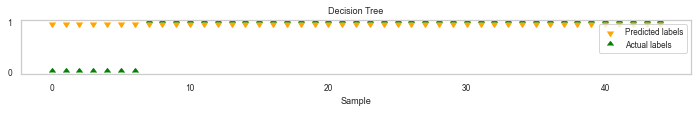

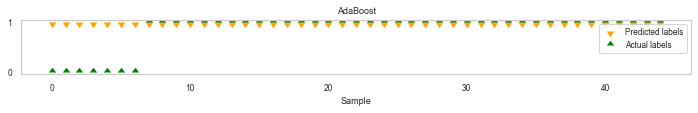

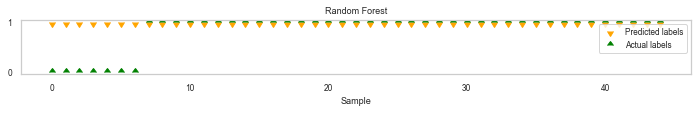

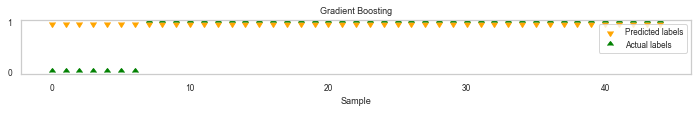

	scenario 7 -> training with real {0, 1, 2, 4} + simulated + drawn instances


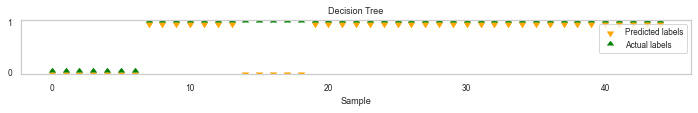

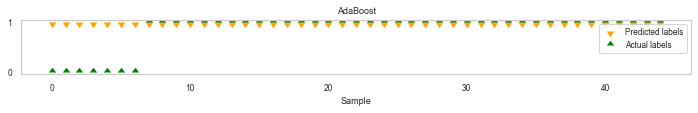

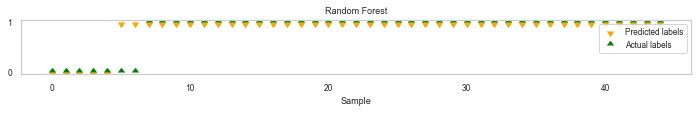

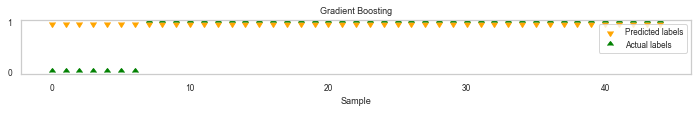

current testing instance: 4
	scenario 1 -> training with real {0, 1, 2, 3} +  instances


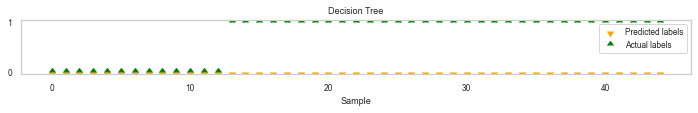

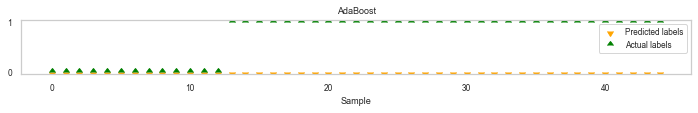

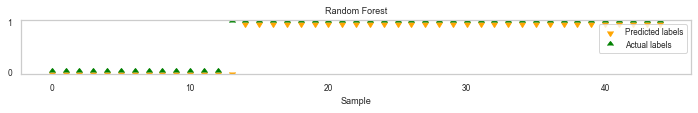

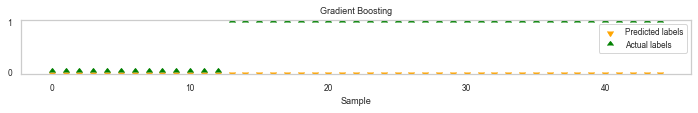

	scenario 2 -> training with simulated instances


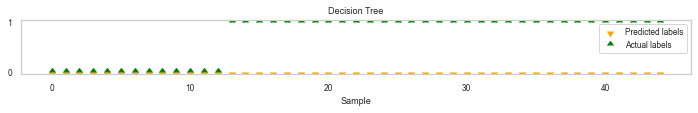

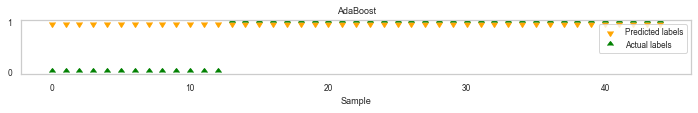

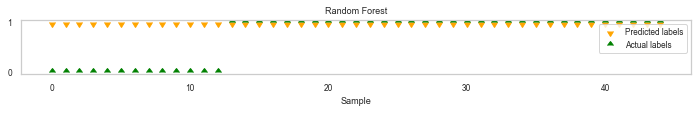

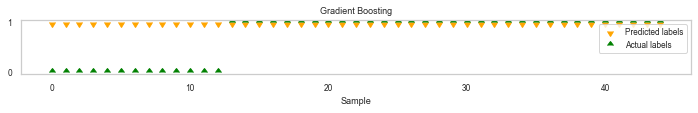

	scenario 3 -> training with drawn instances


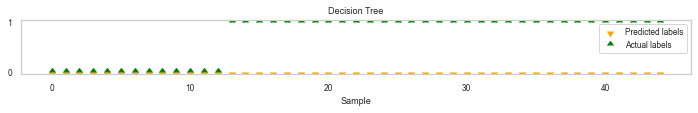

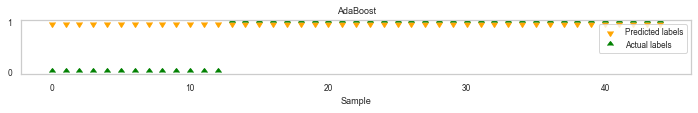

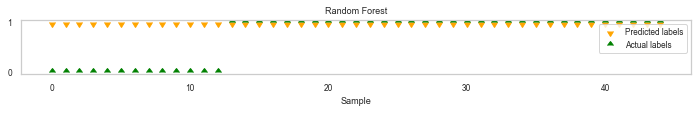

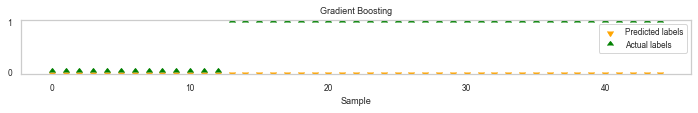

	scenario 4 -> training with real {0, 1, 2, 3} + simulated instances


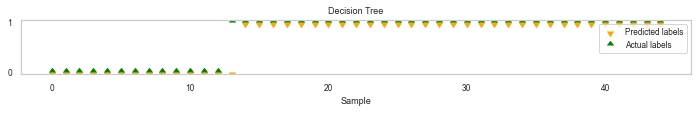

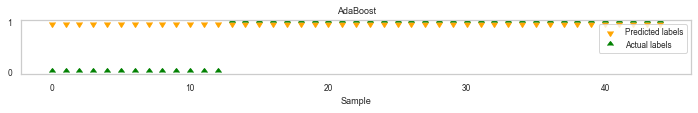

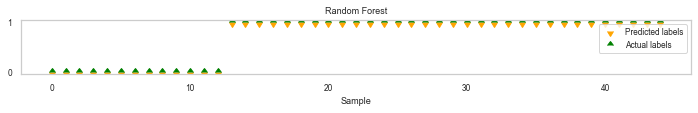

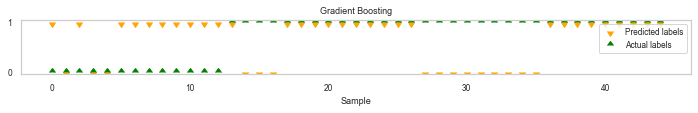

	scenario 5 -> training with real {0, 1, 2, 3} + drawn instances


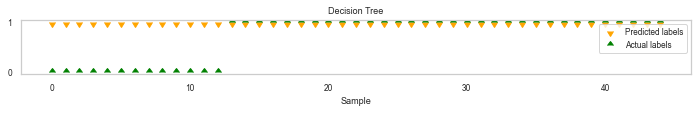

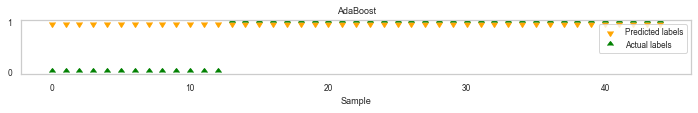

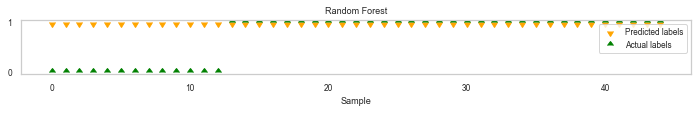

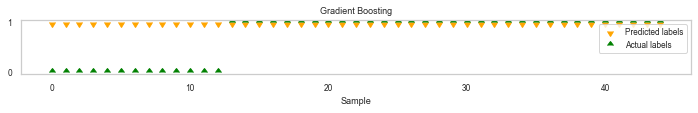

	scenario 6 -> training with simulated + drawn instances


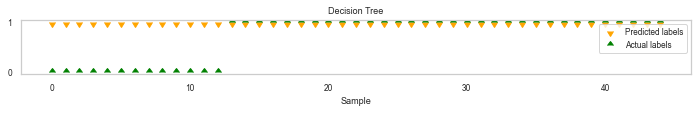

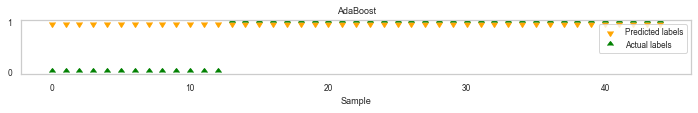

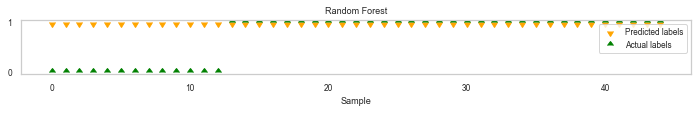

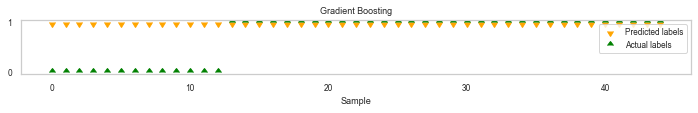

	scenario 7 -> training with real {0, 1, 2, 3} + simulated + drawn instances


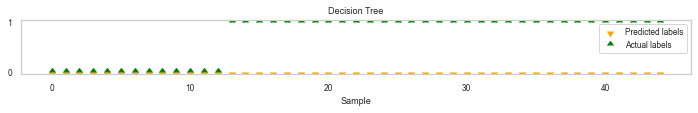

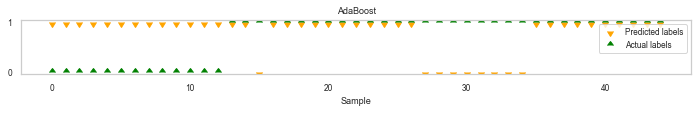

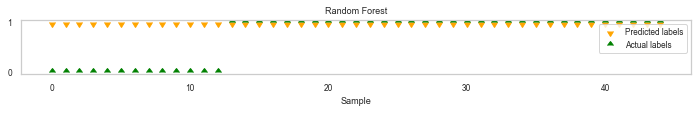

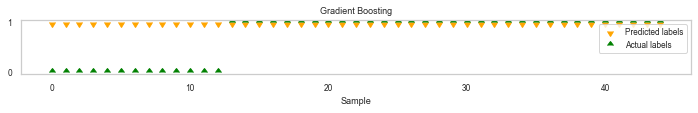

In [125]:
# Para cada rodada de validação cruzada com o esquema 'leave one instance out'
cols = ['SCENARIO', 'CLASSIFIER', 'F1', 'PRECISION', 'RECALL', 'TRAINING[s]', 'TESTING[s]']
scores = pd.DataFrame(columns=cols)
scores['SCENARIO'] = scores['SCENARIO'].astype(int)
add_real = [True, False, False, True, True, False, True]
add_source = {0: [],
              1: ['simulated'],
              2: ['drawn'],
              3: ['simulated'],
              4: ['drawn'],
              5: ['simulated', 'drawn'],
              6: ['simulated', 'drawn']}
added_source = ['', 
                'simulated', 
                'drawn', 
                'simulated', 
                'drawn',
                'simulated + drawn',
                'simulated + drawn']
scaler = preprocessing.StandardScaler()
for train_i, test_i in loio(len(real_instances)):
    print('current testing instance: {}'.format(list(test_i)[0]))

    # Drops the bad vars
    idxs = (df_instances['source']=='real') & (df_instances['instance_id'].isin(train_i))
    good_vars = np.isnan(df_instances.loc[idxs][vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_instances.loc[idxs][vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_instances_good_vars = df_instances.drop(columns=bad_vars, errors='ignore')
    
    # For each considered scenario
    for s in range(len(add_source)):
        idxs_test = (df_instances_good_vars['source']=='real') & \
                    (df_instances_good_vars['instance_id'].isin(test_i))
        if add_real[s]:
            print('\tscenario {} -> training with real {} + {} instances'.format(s+1, train_i, added_source[s]))
            idxs_train = (df_instances_good_vars['source']=='real') & \
                         (df_instances_good_vars['instance_id'].isin(train_i))
        else:
            print('\tscenario {} -> training with {} instances'.format(s+1, added_source[s]))
            idxs_train = df_instances_good_vars['source'].isin(['NoSource']) # Series with only False itens
        idxs_train |= df_instances_good_vars['source'].isin(add_source[s])
        #print('# observations in idxs_test: {}'.format(sum(idxs_test)))
        #print('# observations in idxs_train: {}'.format(sum(idxs_train)))

        df_instances_test  = df_instances_good_vars.loc[idxs_test].reset_index(drop=True)
        df_instances_train = df_instances_good_vars.loc[idxs_train].reset_index(drop=True)
        
        df_instances_train[good_vars] = scaler.fit_transform(df_instances_train[good_vars])
        df_instances_test[good_vars] = scaler.transform(df_instances_test[good_vars])
        
        df_samples_train = pd.DataFrame()
        df_samples_test  = pd.DataFrame()
        df_y_train = pd.DataFrame()
        df_y_test  = pd.DataFrame()
        sample_id = 0
        
        # Extracts samples from each training instance
        for instance in set(df_instances_train['instance_id']):
            #print('extracting samples from instance {}'.format(instance))            
            df = df_instances_train.loc[df_instances_train['instance_id']==instance]
            ret = extract_samples_train(df, df_samples_train, df_y_train, sample_id)
            df_samples_train, df_y_train, sample_id = ret

        # Extracts samples from the testing instance            
        ret = extract_samples_test(df_instances_test, df_samples_test, df_y_test, sample_id)
        df_samples_test, df_y_test, sample_id = ret
        
        # Drops the unnecessary columns
        df_samples_train = df_samples_train.drop(['instance_id'], axis=1)
        df_samples_test  = df_samples_test.drop(['instance_id'], axis=1)
        
        # Changes types of the good vars to avoid problems with inf
        df_samples_train[good_vars] = df_samples_train[good_vars].astype('float32')
        df_samples_test[good_vars]  = df_samples_test[good_vars].astype('float32')
                
        # Changes types of the labels (tsfresh's requirement)
        y_train = np.array(df_y_train['y'], dtype=int)
        y_test  = np.array(df_y_test['y'], dtype=int)
        
        # Groups the transient and the in-regime periods as undesirable event
        y_train[y_train==100+undesirable_event_code] = undesirable_event_code
        y_test[y_test  ==100+undesirable_event_code] = undesirable_event_code
        
        # Extracts features from samples
        X_train = extract_features(df_samples_train, 
                                   column_id='id', 
                                   column_sort='timestamp', 
                                   default_fc_parameters=df_fc_p,
                                   impute_function=impute,
                                   n_jobs=0,
                                   disable_progressbar=disable_progressbar)
        X_train = X_train.reset_index(drop=True)
        X_test = extract_features(df_samples_test, 
                                  column_id='id', 
                                  column_sort='timestamp',
                                  default_fc_parameters=df_fc_p,
                                  impute_function=impute,
                                  n_jobs=0,
                                  disable_progressbar=disable_progressbar)
        X_test = X_test.reset_index(drop=True) 
        
        # Trains, tests and calculates the scores
        scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs2, s+1) 

In [126]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'root_mean_square', 'maximum', 'absolute_maximum', 'minimum']


In [127]:
scores.to_csv(r'./demo_1_benchmark_impact_of_using_simulated_and_hand-drawn_instances_scores.csv')

<h1>Métricas em Formato de Tabela</h1>
<br>
As tabelas a seguir apresentam as médias e desvios padrões, respectivamente, das métricas agrupadas por cenário e ordenadas por medida F.

In [128]:
score_table = scores.drop(['CLASSIFIER'], axis=1).groupby(['SCENARIO']).mean().sort_values(by=['F1'], ascending=False)
score_table

F1  PRECISION    RECALL  TRAINING[s]  TESTING[s]
SCENARIO                                                        
4         0.910000   0.910000  0.910000     2.171269    0.012452
5         0.857778   0.857778  0.857778     0.264623    0.009952
6         0.848889   0.848889  0.848889     2.424520    0.017901
7         0.780000   0.780000  0.780000     2.395399    0.012201
2         0.727778   0.727778  0.727778     2.249120    0.013548
3         0.654444   0.654444  0.654444     0.240302    0.011599
1         0.586667   0.586667  0.586667     0.185211    0.012300

In [129]:
score_table_std = scores.drop(['CLASSIFIER'], axis=1).groupby(['SCENARIO']).std().sort_values(by=['F1'], ascending=True)
score_table_std

F1  PRECISION    RECALL  TRAINING[s]  TESTING[s]
SCENARIO                                                        
4         0.126630   0.126630  0.126630     2.600783    0.012696
6         0.137857   0.137857  0.137857     2.758785    0.030494
5         0.235443   0.235443  0.235443     0.187845    0.007776
7         0.287030   0.287030  0.287030     2.708333    0.010199
2         0.304173   0.304173  0.304173     2.671485    0.014049
3         0.346108   0.346108  0.346108     0.176184    0.009986
1         0.418196   0.418196  0.418196     0.146489    0.012286

In [130]:
score_table_clfs2 = scores.drop(['SCENARIO'], axis=1).groupby(['CLASSIFIER']).mean().sort_values(by=['F1'], ascending=False)
score_table_clfs2

F1  PRECISION    RECALL  TRAINING[s]  TESTING[s]
CLASSIFIER                                                               
Random Forest      0.871746   0.871746  0.871746     0.728223    0.024887
AdaBoost           0.790476   0.790476  0.790476     1.017323    0.018599
Gradient Boosting  0.725714   0.725714  0.725714     3.870922    0.004000
Decision Tree      0.678095   0.678095  0.678095     0.058071    0.003915

In [131]:
score_table_clfs2_std = scores.drop(['SCENARIO'], axis=1).groupby(['CLASSIFIER']).std().sort_values(by=['F1'], ascending=True)
score_table_clfs2_std

F1  PRECISION    RECALL  TRAINING[s]  TESTING[s]
CLASSIFIER                                                               
Random Forest      0.193360   0.193360  0.193360     0.501346    0.023075
AdaBoost           0.257483   0.257483  0.257483     0.824434    0.009342
Gradient Boosting  0.320310   0.320310  0.320310     3.297513    0.002086
Decision Tree      0.365163   0.365163  0.365163     0.049311    0.001915

<h1>Análise de Comparação Múltipla Não Paramétrica</h1>
<br>
A saída a seguir (p_value < 5%) revela que a hipótese nula em que todos os cenários têm o mesmo desempenho é falsa, o que significa que ao menos um dele possui, com alta probabilidade, diferentes valores médios de F1 score quando comparados aos demais

In [132]:
c_names = [c+1 for c in add_source.keys()]
f1s = [scores.loc[scores['SCENARIO']==cn, 'F1'].values for cn in c_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 0.013064162476404406


<br>
Agora investigamos quais cenários possuem valores médios de medida F estatisticamente diferentes em relação ao cenário 1 (treinamento apenas com instâncias reais). Os p_values e adj_p_values indicam que os cenários 4 e 5 têm desempenhos estatisticamente melhores, com alta probabilidade, em comparação ao cenário 1 (< 5%).

In [133]:
c_names_2 = ['scenario {}'.format(cn) for cn in c_names]
ret = stac.holm_test(len(pivots), pivots, c_names_2, 'scenario 1')
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print('{}: \n\tp_values: {}\n\tadj_p_values: {}'.format(comp[i], p_values[i], adj_p_values[i])) 

scenario 1 vs scenario 5: 
	p_values: 0.017371150054409146
	adj_p_values: 0.10422690032645487
scenario 1 vs scenario 4: 
	p_values: 0.03378883938366939
	adj_p_values: 0.16894419691834694
scenario 1 vs scenario 7: 
	p_values: 0.32310425172612867
	adj_p_values: 1
scenario 1 vs scenario 6: 
	p_values: 0.4207518433669326
	adj_p_values: 1
scenario 1 vs scenario 3: 
	p_values: 0.46421431277103187
	adj_p_values: 1
scenario 1 vs scenario 2: 
	p_values: 0.9416529301610357
	adj_p_values: 1


In [134]:
c_names = [c for c in clfs2.keys()]
f1s = [scores.loc[scores['CLASSIFIER']==cn, 'F1'].values for cn in c_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 0.27087080037282996


<h1>Métricas em Boxplots</h1>
<br>
Os boxplots apresentados a seguir são ordenados por valores médios da medida F dos cenários considerados

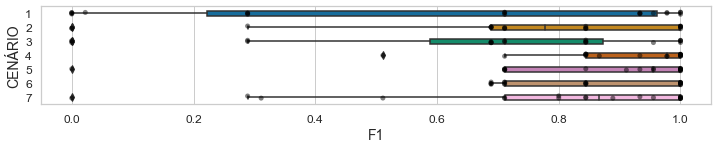

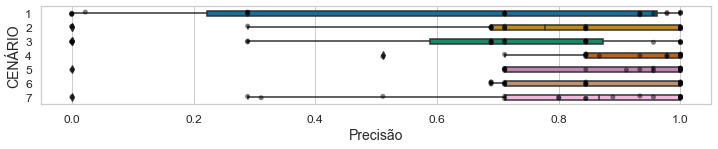

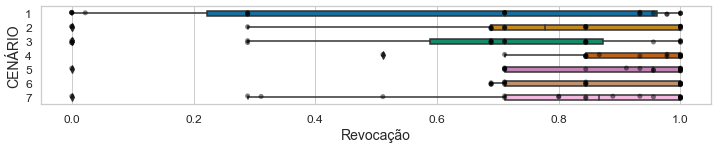

In [135]:
sns.set(font_scale=0.75, style="whitegrid")
i = 0
for score in scores.columns.drop(['CLASSIFIER', 'SCENARIO']):
    if i<3:
        plt.figure(figsize=(12,1.8))
        if i == 0: xlabel = "F1"
        if i == 1: xlabel = "Precisão"
        if i == 2: xlabel = "Revocação"
        bplot=sns.boxplot(y='SCENARIO', x=score, data=scores, width=0.4,
                          palette='colorblind', orient='h');
        bplot=sns.stripplot(y='SCENARIO', x=score, data=scores, jitter=True, marker='o',
                            alpha=0.5, color='black', orient='h')
        bplot.set_xlabel(xlabel,fontsize=14)
        bplot.set_ylabel("CENÁRIO",fontsize=14)
        bplot.tick_params(labelsize=12)
    plt.savefig("box_plot_benchmark_1"+bplot.get_xlabel()+".png", dpi=600, bbox_inches='tight')
    i=i+1


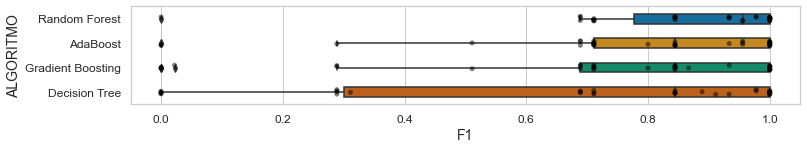

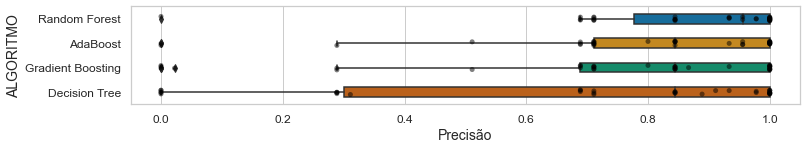

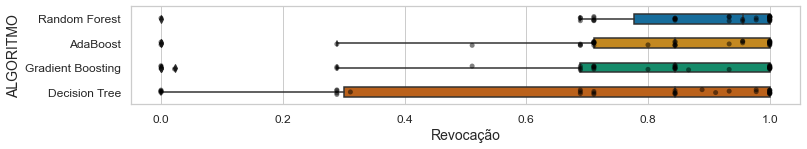

In [136]:
sns.set(font_scale=0.75, style="whitegrid")
i = 0
for score in scores.columns.drop(['CLASSIFIER', 'SCENARIO']):
    if i<3:
        plt.figure(figsize=(12,1.8))
        if i == 0: xlabel = "F1"
        if i == 1: xlabel = "Precisão"
        if i == 2: xlabel = "Revocação"
        bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4,
                          palette='colorblind', order=list(score_table_clfs2.index), orient='h');
        bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o',
                            alpha=0.5, color='black', order=list(score_table_clfs2.index), orient='h')
        bplot.set_xlabel(xlabel,fontsize=14)
        bplot.set_ylabel("ALGORITMO",fontsize=14)
        bplot.tick_params(labelsize=12)
    plt.savefig("box_plot_benchmark_1_algoritmo"+bplot.get_xlabel()+".png", dpi=600, bbox_inches='tight')
    i=i+1


<h1>Conclusões</h1>
<br>Diante dos resultados apresentados para a análise 2 acima, podemos afirmar que o classificador "Random Forest" apresenta melhor desempenho em termos de média e desvio padrão das métricas F1, PRECISION e RECALL. Também podemos afirmar que o cenário 1 apresenta os piores desempenhos em relação às médias e desvio padrão das métricas F1, PRECISION e RECALL.

Após uma análise de comparação múltipla não paramétrica, verificamos que todos os classificadores possuem, com alta probabilidade, valores médios F1 estatisticamente compatíveis. Também verificamos que dois cenários 4 (treinamento com instâncias reais e simuladas) e 5 (treinamento com instâncias reais e desenhadas à mão) apresentam desempenhos estatisticamente melhores, com alta probabilidade, em relação ao cenário 1 (treinamento apenas com instância real).

Portanto, podemos afirmar que o uso de instâncias simuladas e desenhadas à mão no treinamento de algoritmos de aprendizado de máquina, especialmente em conjunto com instâncias reais, tem um impacto positivo para detecções de anomalias em outras instâncias reais.